In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_row', 50)
pd.set_option('display.max_column', 150)

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
Submission = pd.read_csv("sampleSubmission.csv")

In [3]:
train_x = train.drop("revenue",axis=1)
train_y = pd.DataFrame(train["revenue"])

In [4]:
print(train_x.shape)
print(test.shape)

(137, 42)
(100000, 42)


In [5]:
data = pd.concat([train_x,test])
print(data.shape)
print(data.isnull().sum().sum())

(100137, 42)
0


In [6]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def feature_engineer(df):
    df = df.astype(float,errors="ignore")
    df["Open Date"] = pd.to_datetime(df["Open Date"], format='%m/%d/%Y')
    df = df.set_index("Open Date")
    df["Open_Year"] = df.index.year
    df["Open_Month"] = df.index.month
    df = df.reset_index(drop=True)
    df = create_dummies(df,"Type")
    df = create_dummies(df,"City Group")
    df = create_dummies(df,"City")
    df = create_dummies(df,"Open_Year")
    df = create_dummies(df,"Open_Month")
    df = df.drop(["City","City Group","Type","Open_Year","Open_Month"],axis=1)
    return df

In [8]:
data_rf = feature_engineer(data)

In [9]:
train_rf_x = data_rf[:137]
test_x = data_rf[137:]
print(train_rf_x.shape)
print(test_x.shape)

(137, 139)
(100000, 139)


In [10]:
train_rf_x = train_rf_x.drop("Id",axis=1)
Submission_id = pd.DataFrame(test_x["Id"]).astype(int).reset_index(drop=True)
test_rf_x = test_x.drop("Id",axis=1).reset_index(drop=True)

In [11]:
print(train_rf_x.shape) # Perform features normalization
print(train_y.shape)
print(test_rf_x.shape) # Perform features normalization
print(Submission_id.shape)

(137, 138)
(137, 1)
(100000, 138)
(100000, 1)


In [12]:
# Transform features only, and need no inverse_transform back
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
train_score_scaler = MinMaxScaler()
test_score_scaler = MinMaxScaler()
normalize_train = pd.DataFrame(train_score_scaler.fit_transform(train_rf_x.loc[:,"P1":"P37"]),columns = train_rf_x.loc[:,"P1":"P37"].columns)
normalize_test = pd.DataFrame(test_score_scaler.fit_transform(test_rf_x.loc[:,"P1":"P37"]),columns = test_rf_x.loc[:,"P1":"P37"].columns)
# z- score transformation for train_rf_x & test_rf_x
train_rf_x.loc[:,"P1":"P37"] = normalize_train
test_rf_x.loc[:,"P1":"P37"] = normalize_test
print(test_rf_x.isnull().sum().sum())
print(train_rf_x.loc[:,"P1":"P37"].equals(normalize_train))

0
True


In [13]:
# transformation for Train_y
train_y_scaler = StandardScaler()
normalize_train_y = pd.DataFrame(train_y_scaler.fit_transform(train_y),columns = train_y.columns)
log_transform_y = train_y.apply(np.log)

# Feature Engineering Part_1: Drop Non-Mutual Features
### As there are features available on test set only but not on training set

In [14]:
drop_columns = (train_rf_x.sum()==0)
drop_columns = drop_columns[drop_columns].index

In [15]:
train_rf_x_drop = train_rf_x.drop(drop_columns,axis=1)
test_rf_x_drop = test_rf_x.drop(drop_columns,axis=1)
print(train_rf_x_drop.shape)
print(test_rf_x_drop.shape)

(137, 105)
(100000, 105)


# Features for Training & Forecast

In [16]:
print(train_rf_x_drop.shape)
print(log_transform_y.shape)
print(test_rf_x_drop.shape)

(137, 105)
(137, 1)
(100000, 105)


# Neural Network

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras import regularizers
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.2.5
1.13.1


## To have Reproducible Result with keras

In [18]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
backend.set_session(sess)

In [19]:
# Reset NN model weights
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [34]:
reset_weights(model)

In [20]:
from keras import backend
# Custom RMSE metrics for log_transformed_y
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(backend.exp(y_pred) - backend.exp(y_true)), axis=-1))

In [21]:
# define model
model = Sequential()
model.add(Dense(units=8, kernel_regularizer=regularizers.l2(1.8), input_dim=105))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5))
model.add(Dense(units=8, kernel_regularizer=regularizers.l2(1.8)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5))
model.add(Dense(units=8, kernel_regularizer=regularizers.l2(1.8)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5))
model.add(Dense(1, activation = "relu"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 848       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                

In [23]:
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False, decay = 0.0001)

In [24]:
model.compile(optimizer=adam, loss='mse', metrics = [rmse])

In [25]:
print(backend.eval(model.optimizer.lr))

0.01


In [26]:
model.fit(train_rf_x_drop,log_transform_y,validation_split=0.10,
          batch_size=(int(train_rf_x_drop.shape[0]*0.5)),
          epochs=8000,verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 123 samples, validate on 14 samples
Epoch 1/8000
123/123 [==============================] - 1s 8ms/step - loss: 269.0660 - rmse: 4403216.0976 - val_loss: 277.8728 - val_rmse: 4895552.5000
Epoch 2/8000
123/123 [==============================] - 0s 59us/step - loss: 258.8364 - rmse: 4403199.2846 - val_loss: 271.7746 - val_rmse: 4895552.5000
Epoch 3/8000
123/123 [==============================] - 0s 62us/step - loss: 254.6049 - rmse: 4403212.2683 - val_loss: 264.1456 - val_rmse: 4895552.0000
Epoch 4/8000
123/123 [==============================] - 0s 50us/step - loss: 241.8599 - rmse: 4403181.8740 - val_loss: 257.8620 - val_rmse: 4895552.0000
Epoch 5/8000
123/123 [==============================] - 0s 50us/step - loss: 236.2610 - rmse: 4403065.3089 - val_loss: 251.8581 - val_rmse: 4895551.5000
Epoch 6/8000
123/123 [==============================] - 0s 52us/step - loss: 225.8671 - rmse: 4403134.8577 - val_loss: 244.0742 - val_rmse: 489

Epoch 104/8000
123/123 [==============================] - 0s 48us/step - loss: 46.0450 - rmse: 1274558324.0325 - val_loss: 29.9948 - val_rmse: 4745317.5000
Epoch 105/8000
123/123 [==============================] - 0s 53us/step - loss: 49.5550 - rmse: 77567207473.9512 - val_loss: 27.8716 - val_rmse: 4731513.5000
Epoch 106/8000
123/123 [==============================] - 0s 53us/step - loss: 40.1876 - rmse: 125175657.1057 - val_loss: 26.3761 - val_rmse: 4715511.0000
Epoch 107/8000
123/123 [==============================] - 0s 62us/step - loss: 47.1718 - rmse: 1965365148.0976 - val_loss: 26.7728 - val_rmse: 4713988.5000
Epoch 108/8000
123/123 [==============================] - 0s 54us/step - loss: 51.3389 - rmse: 71374864.1626 - val_loss: 27.3319 - val_rmse: 4715592.5000
Epoch 109/8000
123/123 [==============================] - 0s 58us/step - loss: 44.1341 - rmse: 454553443.7724 - val_loss: 27.7792 - val_rmse: 4720839.5000
Epoch 110/8000
123/123 [==============================] - 0s 58us/s

Epoch 209/8000
123/123 [==============================] - 0s 53us/step - loss: 33.5408 - rmse: 467553834.4715 - val_loss: 6.8784 - val_rmse: 4388778.5000
Epoch 210/8000
123/123 [==============================] - 0s 54us/step - loss: 39.7118 - rmse: 676626713.7561 - val_loss: 6.2361 - val_rmse: 4311019.5000
Epoch 211/8000
123/123 [==============================] - 0s 53us/step - loss: 35.8093 - rmse: 83913325.6585 - val_loss: 5.6012 - val_rmse: 4209076.0000
Epoch 212/8000
123/123 [==============================] - 0s 67us/step - loss: 30.2318 - rmse: 472274952.1951 - val_loss: 4.9847 - val_rmse: 4076373.2500
Epoch 213/8000
123/123 [==============================] - 0s 54us/step - loss: 29.8004 - rmse: 173130271.4797 - val_loss: 4.3083 - val_rmse: 3869192.5000
Epoch 214/8000
123/123 [==============================] - 0s 62us/step - loss: 23.4612 - rmse: 104021485.4634 - val_loss: 3.7941 - val_rmse: 3637438.2500
Epoch 215/8000
123/123 [==============================] - 0s 45us/step - loss

123/123 [==============================] - 0s 60us/step - loss: 18.3572 - rmse: 503035131.5772 - val_loss: 2.2720 - val_rmse: 3799993.2500
Epoch 316/8000
123/123 [==============================] - 0s 48us/step - loss: 14.9046 - rmse: 446463672.2602 - val_loss: 2.3626 - val_rmse: 3833476.7500
Epoch 317/8000
123/123 [==============================] - 0s 50us/step - loss: 17.6228 - rmse: 474518084.8780 - val_loss: 2.4570 - val_rmse: 3866716.0000
Epoch 318/8000
123/123 [==============================] - 0s 50us/step - loss: 17.1476 - rmse: 605743854.0488 - val_loss: 2.6100 - val_rmse: 3917502.7500
Epoch 319/8000
123/123 [==============================] - 0s 50us/step - loss: 17.6362 - rmse: 753231301.7236 - val_loss: 2.7061 - val_rmse: 3947392.5000
Epoch 320/8000
123/123 [==============================] - 0s 61us/step - loss: 13.3012 - rmse: 93207761.8537 - val_loss: 2.7737 - val_rmse: 3967682.7500
Epoch 321/8000
123/123 [==============================] - 0s 48us/step - loss: 18.5127 - rms

123/123 [==============================] - 0s 58us/step - loss: 11.8061 - rmse: 36926734.6016 - val_loss: 1.5685 - val_rmse: 3495298.7500
Epoch 422/8000
123/123 [==============================] - 0s 50us/step - loss: 13.4363 - rmse: 33540301.9024 - val_loss: 1.5483 - val_rmse: 3482344.5000
Epoch 423/8000
123/123 [==============================] - 0s 53us/step - loss: 16.4086 - rmse: 433075733.7236 - val_loss: 1.5861 - val_rmse: 3503607.5000
Epoch 424/8000
123/123 [==============================] - 0s 53us/step - loss: 16.5418 - rmse: 173818443.5772 - val_loss: 1.6764 - val_rmse: 3553677.5000
Epoch 425/8000
123/123 [==============================] - 0s 45us/step - loss: 14.8609 - rmse: 93583618.9919 - val_loss: 1.7465 - val_rmse: 3590489.2500
Epoch 426/8000
123/123 [==============================] - 0s 53us/step - loss: 14.7625 - rmse: 126977507.3821 - val_loss: 1.8513 - val_rmse: 3643159.5000
Epoch 427/8000
123/123 [==============================] - 0s 46us/step - loss: 13.5187 - rmse:

123/123 [==============================] - 0s 56us/step - loss: 12.7879 - rmse: 67347017.6260 - val_loss: 1.3261 - val_rmse: 3358628.0000
Epoch 528/8000
123/123 [==============================] - 0s 49us/step - loss: 12.1118 - rmse: 63452887.7073 - val_loss: 1.3369 - val_rmse: 3365996.7500
Epoch 529/8000
123/123 [==============================] - 0s 56us/step - loss: 11.8177 - rmse: 174817399.4146 - val_loss: 1.3814 - val_rmse: 3396578.2500
Epoch 530/8000
123/123 [==============================] - 0s 47us/step - loss: 10.2470 - rmse: 41035810.1789 - val_loss: 1.4019 - val_rmse: 3410136.5000
Epoch 531/8000
123/123 [==============================] - 0s 52us/step - loss: 11.5278 - rmse: 50836087.0569 - val_loss: 1.4006 - val_rmse: 3408986.5000
Epoch 532/8000
123/123 [==============================] - 0s 56us/step - loss: 12.0395 - rmse: 42860604.7480 - val_loss: 1.3741 - val_rmse: 3390736.5000
Epoch 533/8000
123/123 [==============================] - 0s 47us/step - loss: 10.8173 - rmse: 3

Epoch 581/8000
123/123 [==============================] - 0s 65us/step - loss: 7.9617 - rmse: 46186613.8862 - val_loss: 1.3386 - val_rmse: 3366234.2500
Epoch 582/8000
123/123 [==============================] - 0s 97us/step - loss: 9.5318 - rmse: 114103299.6748 - val_loss: 1.4327 - val_rmse: 3430058.5000
Epoch 583/8000
123/123 [==============================] - 0s 119us/step - loss: 8.7865 - rmse: 139888168.8455 - val_loss: 1.5623 - val_rmse: 3510125.2500
Epoch 584/8000
123/123 [==============================] - 0s 79us/step - loss: 10.0439 - rmse: 52689119.0894 - val_loss: 1.7156 - val_rmse: 3594996.0000
Epoch 585/8000
123/123 [==============================] - 0s 74us/step - loss: 10.3230 - rmse: 73763051.7398 - val_loss: 1.8320 - val_rmse: 3653447.7500
Epoch 586/8000
123/123 [==============================] - 0s 61us/step - loss: 11.3589 - rmse: 30518400.9268 - val_loss: 1.8918 - val_rmse: 3681714.7500
Epoch 587/8000
123/123 [==============================] - 0s 60us/step - loss: 8.9

Epoch 635/8000
123/123 [==============================] - 0s 69us/step - loss: 6.4864 - rmse: 26630782.4228 - val_loss: 1.2284 - val_rmse: 3278866.7500
Epoch 636/8000
123/123 [==============================] - 0s 59us/step - loss: 8.6171 - rmse: 32747741.0081 - val_loss: 1.2242 - val_rmse: 3276104.7500
Epoch 637/8000
123/123 [==============================] - 0s 77us/step - loss: 8.6411 - rmse: 14513465.8780 - val_loss: 1.2155 - val_rmse: 3269648.5000
Epoch 638/8000
123/123 [==============================] - 0s 52us/step - loss: 9.0713 - rmse: 29131415.8618 - val_loss: 1.2002 - val_rmse: 3257790.7500
Epoch 639/8000
123/123 [==============================] - 0s 74us/step - loss: 8.5795 - rmse: 64623500.5854 - val_loss: 1.1914 - val_rmse: 3251017.2500
Epoch 640/8000
123/123 [==============================] - 0s 52us/step - loss: 9.2766 - rmse: 34151882.6016 - val_loss: 1.1893 - val_rmse: 3249607.5000
Epoch 641/8000
123/123 [==============================] - 0s 63us/step - loss: 7.4079 - 

Epoch 689/8000
123/123 [==============================] - 0s 57us/step - loss: 7.1858 - rmse: 41423664.3740 - val_loss: 1.2768 - val_rmse: 3323110.7500
Epoch 690/8000
123/123 [==============================] - 0s 46us/step - loss: 7.2561 - rmse: 58992242.6016 - val_loss: 1.3144 - val_rmse: 3350720.5000
Epoch 691/8000
123/123 [==============================] - 0s 44us/step - loss: 8.8085 - rmse: 51339785.5285 - val_loss: 1.3790 - val_rmse: 3395889.7500
Epoch 692/8000
123/123 [==============================] - 0s 54us/step - loss: 8.0699 - rmse: 18472875.2846 - val_loss: 1.4034 - val_rmse: 3412344.0000
Epoch 693/8000
123/123 [==============================] - 0s 55us/step - loss: 7.4510 - rmse: 34883094.7317 - val_loss: 1.3953 - val_rmse: 3406958.2500
Epoch 694/8000
123/123 [==============================] - 0s 52us/step - loss: 7.9492 - rmse: 15685653.3902 - val_loss: 1.3866 - val_rmse: 3401018.2500
Epoch 695/8000
123/123 [==============================] - 0s 47us/step - loss: 8.3957 - 

Epoch 743/8000
123/123 [==============================] - 0s 50us/step - loss: 7.7114 - rmse: 14053986.2480 - val_loss: 1.4275 - val_rmse: 3428469.5000
Epoch 744/8000
123/123 [==============================] - 0s 49us/step - loss: 6.4254 - rmse: 16536398.5203 - val_loss: 1.4142 - val_rmse: 3419889.2500
Epoch 745/8000
123/123 [==============================] - 0s 57us/step - loss: 7.5800 - rmse: 27178578.6341 - val_loss: 1.3879 - val_rmse: 3402385.7500
Epoch 746/8000
123/123 [==============================] - 0s 48us/step - loss: 6.5909 - rmse: 14718153.7724 - val_loss: 1.3567 - val_rmse: 3381151.5000
Epoch 747/8000
123/123 [==============================] - 0s 56us/step - loss: 8.2176 - rmse: 22122952.9024 - val_loss: 1.3263 - val_rmse: 3359938.0000
Epoch 748/8000
123/123 [==============================] - 0s 48us/step - loss: 6.8159 - rmse: 18342425.1707 - val_loss: 1.2749 - val_rmse: 3322621.2500
Epoch 749/8000
123/123 [==============================] - 0s 47us/step - loss: 7.8553 - 

Epoch 797/8000
123/123 [==============================] - 0s 55us/step - loss: 5.7705 - rmse: 13331143.5935 - val_loss: 1.4613 - val_rmse: 3446266.7500
Epoch 798/8000
123/123 [==============================] - 0s 52us/step - loss: 6.5192 - rmse: 24408191.1870 - val_loss: 1.3923 - val_rmse: 3400743.5000
Epoch 799/8000
123/123 [==============================] - 0s 53us/step - loss: 5.9337 - rmse: 15416338.8699 - val_loss: 1.3421 - val_rmse: 3365229.7500
Epoch 800/8000
123/123 [==============================] - 0s 52us/step - loss: 6.8422 - rmse: 16765603.7886 - val_loss: 1.3090 - val_rmse: 3340624.2500
Epoch 801/8000
123/123 [==============================] - 0s 44us/step - loss: 5.4370 - rmse: 14754700.1301 - val_loss: 1.2874 - val_rmse: 3324170.2500
Epoch 802/8000
123/123 [==============================] - 0s 56us/step - loss: 7.0753 - rmse: 18178234.3089 - val_loss: 1.2405 - val_rmse: 3288148.0000
Epoch 803/8000
123/123 [==============================] - 0s 54us/step - loss: 6.3256 - 

Epoch 851/8000
123/123 [==============================] - 0s 50us/step - loss: 4.9797 - rmse: 12293398.9837 - val_loss: 1.0212 - val_rmse: 3106721.2500
Epoch 852/8000
123/123 [==============================] - 0s 56us/step - loss: 4.7064 - rmse: 11279091.4959 - val_loss: 1.0392 - val_rmse: 3124006.5000
Epoch 853/8000
123/123 [==============================] - 0s 47us/step - loss: 5.5025 - rmse: 7595122.2724 - val_loss: 1.0261 - val_rmse: 3111682.5000
Epoch 854/8000
123/123 [==============================] - 0s 45us/step - loss: 5.3965 - rmse: 19683546.2114 - val_loss: 1.0131 - val_rmse: 3099186.2500
Epoch 855/8000
123/123 [==============================] - 0s 56us/step - loss: 5.6632 - rmse: 6861763.6911 - val_loss: 0.9688 - val_rmse: 3055176.5000
Epoch 856/8000
123/123 [==============================] - 0s 45us/step - loss: 6.2216 - rmse: 20578925.8537 - val_loss: 0.9063 - val_rmse: 2988770.7500
Epoch 857/8000
123/123 [==============================] - 0s 59us/step - loss: 3.6848 - rm

Epoch 905/8000
123/123 [==============================] - 0s 57us/step - loss: 4.4698 - rmse: 6082451.7033 - val_loss: 0.8060 - val_rmse: 2873699.2500
Epoch 906/8000
123/123 [==============================] - 0s 59us/step - loss: 4.0811 - rmse: 14513027.0610 - val_loss: 0.8369 - val_rmse: 2911564.0000
Epoch 907/8000
123/123 [==============================] - 0s 53us/step - loss: 5.9007 - rmse: 21866468.0000 - val_loss: 0.8504 - val_rmse: 2927500.5000
Epoch 908/8000
123/123 [==============================] - 0s 57us/step - loss: 3.9821 - rmse: 9688056.9248 - val_loss: 0.8587 - val_rmse: 2937269.7500
Epoch 909/8000
123/123 [==============================] - 0s 44us/step - loss: 5.0723 - rmse: 14866013.3659 - val_loss: 0.8569 - val_rmse: 2935058.5000
Epoch 910/8000
123/123 [==============================] - 0s 56us/step - loss: 5.4611 - rmse: 21447807.0407 - val_loss: 0.8669 - val_rmse: 2946628.5000
Epoch 911/8000
123/123 [==============================] - 0s 45us/step - loss: 4.4098 - rm

123/123 [==============================] - 0s 51us/step - loss: 4.0303 - rmse: 8634748.1179 - val_loss: 0.7736 - val_rmse: 2830865.2500
Epoch 960/8000
123/123 [==============================] - 0s 57us/step - loss: 5.5568 - rmse: 8187281.8130 - val_loss: 0.7256 - val_rmse: 2765550.2500
Epoch 961/8000
123/123 [==============================] - 0s 48us/step - loss: 4.3982 - rmse: 14135563.2602 - val_loss: 0.6918 - val_rmse: 2716508.0000
Epoch 962/8000
123/123 [==============================] - 0s 49us/step - loss: 3.6192 - rmse: 10983451.8984 - val_loss: 0.6749 - val_rmse: 2691021.2500
Epoch 963/8000
123/123 [==============================] - 0s 49us/step - loss: 3.3953 - rmse: 9485398.9919 - val_loss: 0.6676 - val_rmse: 2679948.5000
Epoch 964/8000
123/123 [==============================] - 0s 43us/step - loss: 3.6555 - rmse: 14156562.9431 - val_loss: 0.6664 - val_rmse: 2678017.7500
Epoch 965/8000
123/123 [==============================] - 0s 56us/step - loss: 4.0509 - rmse: 13789686.756

Epoch 1067/8000
123/123 [==============================] - 0s 49us/step - loss: 2.9266 - rmse: 6503068.8618 - val_loss: 0.5795 - val_rmse: 2532748.7500
Epoch 1068/8000
123/123 [==============================] - 0s 60us/step - loss: 2.8504 - rmse: 5981691.7154 - val_loss: 0.5670 - val_rmse: 2510118.2500
Epoch 1069/8000
123/123 [==============================] - 0s 51us/step - loss: 3.1004 - rmse: 9937317.0976 - val_loss: 0.5626 - val_rmse: 2503036.0000
Epoch 1070/8000
123/123 [==============================] - 0s 54us/step - loss: 3.2442 - rmse: 7027408.8049 - val_loss: 0.5619 - val_rmse: 2501929.2500
Epoch 1071/8000
123/123 [==============================] - 0s 47us/step - loss: 3.0353 - rmse: 8072553.7033 - val_loss: 0.5652 - val_rmse: 2507382.2500
Epoch 1072/8000
123/123 [==============================] - 0s 47us/step - loss: 3.3393 - rmse: 9015470.0488 - val_loss: 0.5779 - val_rmse: 2530145.2500
Epoch 1073/8000
123/123 [==============================] - 0s 58us/step - loss: 3.1596 -

Epoch 1121/8000
123/123 [==============================] - 0s 56us/step - loss: 2.6811 - rmse: 6881692.5650 - val_loss: 0.6110 - val_rmse: 2589701.7500
Epoch 1122/8000
123/123 [==============================] - 0s 47us/step - loss: 2.5084 - rmse: 6248952.4878 - val_loss: 0.6129 - val_rmse: 2592847.2500
Epoch 1123/8000
123/123 [==============================] - 0s 51us/step - loss: 2.4880 - rmse: 7833660.6992 - val_loss: 0.6125 - val_rmse: 2592224.2500
Epoch 1124/8000
123/123 [==============================] - 0s 52us/step - loss: 2.4696 - rmse: 4968473.1951 - val_loss: 0.5985 - val_rmse: 2568061.2500
Epoch 1125/8000
123/123 [==============================] - 0s 48us/step - loss: 3.0765 - rmse: 6841167.6016 - val_loss: 0.5834 - val_rmse: 2541176.2500
Epoch 1126/8000
123/123 [==============================] - 0s 59us/step - loss: 2.6191 - rmse: 7096609.6341 - val_loss: 0.5758 - val_rmse: 2527470.7500
Epoch 1127/8000
123/123 [==============================] - 0s 49us/step - loss: 2.8543 -

Epoch 1175/8000
123/123 [==============================] - 0s 48us/step - loss: 2.1031 - rmse: 5913135.8862 - val_loss: 0.4724 - val_rmse: 2348648.7500
Epoch 1176/8000
123/123 [==============================] - 0s 52us/step - loss: 2.0952 - rmse: 4355772.9309 - val_loss: 0.4877 - val_rmse: 2373245.0000
Epoch 1177/8000
123/123 [==============================] - 0s 50us/step - loss: 1.9241 - rmse: 5376059.6545 - val_loss: 0.5034 - val_rmse: 2402386.0000
Epoch 1178/8000
123/123 [==============================] - ETA: 0s - loss: 2.6715 - rmse: 8491870.00 - 0s 41us/step - loss: 2.2601 - rmse: 7075691.3211 - val_loss: 0.5188 - val_rmse: 2430144.0000
Epoch 1179/8000
123/123 [==============================] - 0s 55us/step - loss: 2.4955 - rmse: 4968564.0163 - val_loss: 0.5250 - val_rmse: 2440964.5000
Epoch 1180/8000
123/123 [==============================] - 0s 43us/step - loss: 2.3587 - rmse: 5210515.5000 - val_loss: 0.5200 - val_rmse: 2432159.2500
Epoch 1181/8000
123/123 [===================

123/123 [==============================] - 0s 51us/step - loss: 1.5598 - rmse: 4310000.1098 - val_loss: 0.5129 - val_rmse: 2419745.7500
Epoch 1283/8000
123/123 [==============================] - 0s 51us/step - loss: 1.5561 - rmse: 3724343.1951 - val_loss: 0.5091 - val_rmse: 2412913.2500
Epoch 1284/8000
123/123 [==============================] - 0s 57us/step - loss: 1.6258 - rmse: 3869621.7215 - val_loss: 0.4961 - val_rmse: 2389199.7500
Epoch 1285/8000
123/123 [==============================] - 0s 49us/step - loss: 2.0635 - rmse: 4113221.4228 - val_loss: 0.4775 - val_rmse: 2357137.5000
Epoch 1286/8000
123/123 [==============================] - 0s 57us/step - loss: 1.9982 - rmse: 5760548.2967 - val_loss: 0.4690 - val_rmse: 2343140.7500
Epoch 1287/8000
123/123 [==============================] - 0s 51us/step - loss: 1.5790 - rmse: 4180370.1545 - val_loss: 0.4630 - val_rmse: 2333249.5000
Epoch 1288/8000
123/123 [==============================] - 0s 46us/step - loss: 1.8645 - rmse: 4880096.3

123/123 [==============================] - 0s 48us/step - loss: 1.5021 - rmse: 3462790.6199 - val_loss: 0.4410 - val_rmse: 2295258.7500
Epoch 1337/8000
123/123 [==============================] - 0s 47us/step - loss: 1.4167 - rmse: 4120214.0142 - val_loss: 0.4398 - val_rmse: 2293078.2500
Epoch 1338/8000
123/123 [==============================] - 0s 56us/step - loss: 1.6395 - rmse: 3809167.3862 - val_loss: 0.4362 - val_rmse: 2286647.5000
Epoch 1339/8000
123/123 [==============================] - 0s 49us/step - loss: 1.4815 - rmse: 4266219.5122 - val_loss: 0.4363 - val_rmse: 2286892.5000
Epoch 1340/8000
123/123 [==============================] - 0s 54us/step - loss: 1.6541 - rmse: 3541712.8760 - val_loss: 0.4352 - val_rmse: 2284906.0000
Epoch 1341/8000
123/123 [==============================] - 0s 50us/step - loss: 1.3245 - rmse: 3983229.1545 - val_loss: 0.4337 - val_rmse: 2282082.0000
Epoch 1342/8000
123/123 [==============================] - 0s 47us/step - loss: 1.3597 - rmse: 3818661.8

123/123 [==============================] - 0s 48us/step - loss: 1.3806 - rmse: 3957996.2154 - val_loss: 0.3801 - val_rmse: 2177022.7500
Epoch 1391/8000
123/123 [==============================] - 0s 61us/step - loss: 1.1763 - rmse: 3638965.0244 - val_loss: 0.3866 - val_rmse: 2190698.7500
Epoch 1392/8000
123/123 [==============================] - 0s 56us/step - loss: 1.5437 - rmse: 3946004.2154 - val_loss: 0.3897 - val_rmse: 2197023.5000
Epoch 1393/8000
123/123 [==============================] - 0s 61us/step - loss: 1.3612 - rmse: 3273939.0569 - val_loss: 0.3901 - val_rmse: 2197858.2500
Epoch 1394/8000
123/123 [==============================] - 0s 48us/step - loss: 1.2377 - rmse: 3379096.9736 - val_loss: 0.3886 - val_rmse: 2194738.0000
Epoch 1395/8000
123/123 [==============================] - 0s 48us/step - loss: 1.1796 - rmse: 3501373.7012 - val_loss: 0.3863 - val_rmse: 2189941.2500
Epoch 1396/8000
123/123 [==============================] - 0s 52us/step - loss: 1.3459 - rmse: 3509951.7

123/123 [==============================] - 0s 56us/step - loss: 1.0651 - rmse: 3137829.1321 - val_loss: 0.3643 - val_rmse: 2142433.7500
Epoch 1445/8000
123/123 [==============================] - 0s 52us/step - loss: 1.1948 - rmse: 3829642.3577 - val_loss: 0.3683 - val_rmse: 2151367.7500
Epoch 1446/8000
123/123 [==============================] - 0s 61us/step - loss: 0.9118 - rmse: 3043790.3841 - val_loss: 0.3720 - val_rmse: 2159530.5000
Epoch 1447/8000
123/123 [==============================] - 0s 47us/step - loss: 1.3430 - rmse: 3530512.4878 - val_loss: 0.3739 - val_rmse: 2163708.0000
Epoch 1448/8000
123/123 [==============================] - 0s 46us/step - loss: 1.1833 - rmse: 3044887.7724 - val_loss: 0.3711 - val_rmse: 2157506.5000
Epoch 1449/8000
123/123 [==============================] - 0s 52us/step - loss: 1.0080 - rmse: 3254590.9959 - val_loss: 0.3666 - val_rmse: 2147558.5000
Epoch 1450/8000
123/123 [==============================] - 0s 50us/step - loss: 0.9161 - rmse: 2896985.9

123/123 [==============================] - 0s 54us/step - loss: 0.9008 - rmse: 3173996.0061 - val_loss: 0.3292 - val_rmse: 2058187.1250
Epoch 1499/8000
123/123 [==============================] - 0s 50us/step - loss: 0.9555 - rmse: 3079865.7541 - val_loss: 0.3297 - val_rmse: 2059484.7500
Epoch 1500/8000
123/123 [==============================] - 0s 73us/step - loss: 0.8879 - rmse: 2704035.3659 - val_loss: 0.3278 - val_rmse: 2054611.7500
Epoch 1501/8000
123/123 [==============================] - 0s 59us/step - loss: 0.9160 - rmse: 2895962.8557 - val_loss: 0.3236 - val_rmse: 2043857.3750
Epoch 1502/8000
123/123 [==============================] - 0s 87us/step - loss: 0.8971 - rmse: 3259897.0752 - val_loss: 0.3200 - val_rmse: 2034234.2500
Epoch 1503/8000
123/123 [==============================] - 0s 48us/step - loss: 0.8174 - rmse: 2637226.4634 - val_loss: 0.3164 - val_rmse: 2024392.6250
Epoch 1504/8000
123/123 [==============================] - 0s 59us/step - loss: 0.9363 - rmse: 3332357.2

123/123 [==============================] - 0s 47us/step - loss: 0.9666 - rmse: 3679532.8354 - val_loss: 0.2958 - val_rmse: 1965960.6250
Epoch 1553/8000
123/123 [==============================] - 0s 57us/step - loss: 0.7337 - rmse: 2679742.4167 - val_loss: 0.3015 - val_rmse: 1982734.0000
Epoch 1554/8000
123/123 [==============================] - 0s 51us/step - loss: 0.8914 - rmse: 3055081.3293 - val_loss: 0.3071 - val_rmse: 1998774.7500
Epoch 1555/8000
123/123 [==============================] - 0s 49us/step - loss: 0.8129 - rmse: 2894286.0569 - val_loss: 0.3128 - val_rmse: 2014809.0000
Epoch 1556/8000
123/123 [==============================] - 0s 51us/step - loss: 0.8401 - rmse: 3094949.3862 - val_loss: 0.3192 - val_rmse: 2031998.8750
Epoch 1557/8000
123/123 [==============================] - 0s 50us/step - loss: 0.7923 - rmse: 2825890.2622 - val_loss: 0.3231 - val_rmse: 2042370.0000
Epoch 1558/8000
123/123 [==============================] - 0s 56us/step - loss: 0.6545 - rmse: 2568750.4

123/123 [==============================] - 0s 60us/step - loss: 0.8637 - rmse: 2857039.5000 - val_loss: 0.2812 - val_rmse: 1920804.6250
Epoch 1607/8000
123/123 [==============================] - 0s 47us/step - loss: 0.6976 - rmse: 2679612.0407 - val_loss: 0.2807 - val_rmse: 1919010.8750
Epoch 1608/8000
123/123 [==============================] - 0s 51us/step - loss: 0.5916 - rmse: 2675700.0508 - val_loss: 0.2801 - val_rmse: 1917343.7500
Epoch 1609/8000
123/123 [==============================] - 0s 51us/step - loss: 0.5860 - rmse: 2555063.0447 - val_loss: 0.2800 - val_rmse: 1916922.8750
Epoch 1610/8000
123/123 [==============================] - 0s 43us/step - loss: 0.6692 - rmse: 2341935.7358 - val_loss: 0.2793 - val_rmse: 1914522.6250
Epoch 1611/8000
123/123 [==============================] - 0s 53us/step - loss: 0.6704 - rmse: 2683264.2947 - val_loss: 0.2787 - val_rmse: 1912589.1250
Epoch 1612/8000
123/123 [==============================] - 0s 48us/step - loss: 0.5587 - rmse: 2555659.4

Epoch 1714/8000
123/123 [==============================] - 0s 61us/step - loss: 0.5721 - rmse: 2477123.0996 - val_loss: 0.2402 - val_rmse: 1799753.3750
Epoch 1715/8000
123/123 [==============================] - 0s 50us/step - loss: 0.4783 - rmse: 2299722.3516 - val_loss: 0.2412 - val_rmse: 1802184.8750
Epoch 1716/8000
123/123 [==============================] - 0s 57us/step - loss: 0.5544 - rmse: 2465835.8435 - val_loss: 0.2428 - val_rmse: 1806794.0000
Epoch 1717/8000
123/123 [==============================] - 0s 52us/step - loss: 0.5623 - rmse: 2472650.9837 - val_loss: 0.2454 - val_rmse: 1814964.6250
Epoch 1718/8000
123/123 [==============================] - 0s 54us/step - loss: 0.5309 - rmse: 2278398.8293 - val_loss: 0.2474 - val_rmse: 1821561.1250
Epoch 1719/8000
123/123 [==============================] - 0s 60us/step - loss: 0.5478 - rmse: 2219502.8760 - val_loss: 0.2487 - val_rmse: 1825471.7500
Epoch 1720/8000
123/123 [==============================] - 0s 44us/step - loss: 0.5373 -

Epoch 1768/8000
123/123 [==============================] - 0s 57us/step - loss: 0.4228 - rmse: 2181561.2500 - val_loss: 0.2345 - val_rmse: 1785165.3750
Epoch 1769/8000
123/123 [==============================] - 0s 45us/step - loss: 0.4689 - rmse: 2201157.1057 - val_loss: 0.2343 - val_rmse: 1784646.2500
Epoch 1770/8000
123/123 [==============================] - 0s 46us/step - loss: 0.4599 - rmse: 2205411.8892 - val_loss: 0.2346 - val_rmse: 1785333.3750
Epoch 1771/8000
123/123 [==============================] - 0s 57us/step - loss: 0.4790 - rmse: 2214893.6362 - val_loss: 0.2343 - val_rmse: 1784671.7500
Epoch 1772/8000
123/123 [==============================] - 0s 46us/step - loss: 0.5330 - rmse: 2328949.6057 - val_loss: 0.2347 - val_rmse: 1785664.8750
Epoch 1773/8000
123/123 [==============================] - 0s 53us/step - loss: 0.4170 - rmse: 2188997.7500 - val_loss: 0.2364 - val_rmse: 1789967.1250
Epoch 1774/8000
123/123 [==============================] - 0s 48us/step - loss: 0.3791 -

Epoch 1822/8000
123/123 [==============================] - 0s 53us/step - loss: 0.3971 - rmse: 1984947.9492 - val_loss: 0.2327 - val_rmse: 1780258.2500
Epoch 1823/8000
123/123 [==============================] - 0s 46us/step - loss: 0.3843 - rmse: 2014790.9319 - val_loss: 0.2305 - val_rmse: 1774420.2500
Epoch 1824/8000
123/123 [==============================] - 0s 54us/step - loss: 0.4267 - rmse: 2212770.8110 - val_loss: 0.2285 - val_rmse: 1769038.6250
Epoch 1825/8000
123/123 [==============================] - 0s 46us/step - loss: 0.4422 - rmse: 2245056.5102 - val_loss: 0.2273 - val_rmse: 1765681.6250
Epoch 1826/8000
123/123 [==============================] - 0s 50us/step - loss: 0.3596 - rmse: 1968506.2348 - val_loss: 0.2262 - val_rmse: 1762602.2500
Epoch 1827/8000
123/123 [==============================] - 0s 54us/step - loss: 0.3993 - rmse: 2026295.9482 - val_loss: 0.2260 - val_rmse: 1762105.1250
Epoch 1828/8000
123/123 [==============================] - 0s 43us/step - loss: 0.3644 -

Epoch 1876/8000
123/123 [==============================] - 0s 47us/step - loss: 0.3361 - rmse: 1947111.7978 - val_loss: 0.2271 - val_rmse: 1765034.8750
Epoch 1877/8000
123/123 [==============================] - 0s 56us/step - loss: 0.3840 - rmse: 2109645.9411 - val_loss: 0.2265 - val_rmse: 1763323.7500
Epoch 1878/8000
123/123 [==============================] - 0s 49us/step - loss: 0.3141 - rmse: 1896078.6484 - val_loss: 0.2263 - val_rmse: 1762721.6250
Epoch 1879/8000
123/123 [==============================] - 0s 60us/step - loss: 0.3688 - rmse: 2102917.4217 - val_loss: 0.2270 - val_rmse: 1764922.8750
Epoch 1880/8000
123/123 [==============================] - 0s 55us/step - loss: 0.3524 - rmse: 1926203.0854 - val_loss: 0.2276 - val_rmse: 1766531.7500
Epoch 1881/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2883 - rmse: 1766567.9197 - val_loss: 0.2274 - val_rmse: 1765914.0000
Epoch 1882/8000
123/123 [==============================] - 0s 63us/step - loss: 0.3858 -

Epoch 1930/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2925 - rmse: 1794476.4715 - val_loss: 0.2169 - val_rmse: 1734995.8750
Epoch 1931/8000
123/123 [==============================] - 0s 46us/step - loss: 0.3471 - rmse: 1940298.1199 - val_loss: 0.2161 - val_rmse: 1732705.2500
Epoch 1932/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2926 - rmse: 1849739.4319 - val_loss: 0.2158 - val_rmse: 1731648.7500
Epoch 1933/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2726 - rmse: 1785561.2612 - val_loss: 0.2151 - val_rmse: 1729428.6250
Epoch 1934/8000
123/123 [==============================] - 0s 57us/step - loss: 0.3311 - rmse: 1891586.6392 - val_loss: 0.2145 - val_rmse: 1727571.7500
Epoch 1935/8000
123/123 [==============================] - 0s 47us/step - loss: 0.3224 - rmse: 1925366.4898 - val_loss: 0.2137 - val_rmse: 1724951.0000
Epoch 1936/8000
123/123 [==============================] - 0s 49us/step - loss: 0.3195 -

Epoch 1984/8000
123/123 [==============================] - 0s 56us/step - loss: 0.3404 - rmse: 1931924.4329 - val_loss: 0.2062 - val_rmse: 1700084.2500
Epoch 1985/8000
123/123 [==============================] - 0s 60us/step - loss: 0.3155 - rmse: 1849016.3323 - val_loss: 0.2070 - val_rmse: 1702837.7500
Epoch 1986/8000
123/123 [==============================] - 0s 49us/step - loss: 0.3463 - rmse: 2003169.0945 - val_loss: 0.2074 - val_rmse: 1704258.2500
Epoch 1987/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2892 - rmse: 1758225.2287 - val_loss: 0.2076 - val_rmse: 1704733.7500
Epoch 1988/8000
123/123 [==============================] - 0s 49us/step - loss: 0.3146 - rmse: 1918217.5589 - val_loss: 0.2074 - val_rmse: 1704143.2500
Epoch 1989/8000
123/123 [==============================] - 0s 46us/step - loss: 0.3000 - rmse: 1905687.0518 - val_loss: 0.2072 - val_rmse: 1703334.0000
Epoch 1990/8000
123/123 [==============================] - 0s 62us/step - loss: 0.3289 -

Epoch 2038/8000
123/123 [==============================] - 0s 52us/step - loss: 0.3189 - rmse: 1952616.4929 - val_loss: 0.2059 - val_rmse: 1698800.6250
Epoch 2039/8000
123/123 [==============================] - 0s 59us/step - loss: 0.3206 - rmse: 1873378.1972 - val_loss: 0.2065 - val_rmse: 1700881.8750
Epoch 2040/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2794 - rmse: 1779526.2063 - val_loss: 0.2070 - val_rmse: 1702617.6250
Epoch 2041/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2723 - rmse: 1787201.0488 - val_loss: 0.2069 - val_rmse: 1702431.3750
Epoch 2042/8000
123/123 [==============================] - 0s 52us/step - loss: 0.3099 - rmse: 1888381.1992 - val_loss: 0.2069 - val_rmse: 1702517.1250
Epoch 2043/8000
123/123 [==============================] - 0s 69us/step - loss: 0.3100 - rmse: 1855724.5346 - val_loss: 0.2068 - val_rmse: 1701954.0000
Epoch 2044/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2900 -

Epoch 2092/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2453 - rmse: 1707135.6839 - val_loss: 0.2045 - val_rmse: 1694065.0000
Epoch 2093/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2915 - rmse: 1790875.9055 - val_loss: 0.2042 - val_rmse: 1693027.6250
Epoch 2094/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2890 - rmse: 1719874.1220 - val_loss: 0.2040 - val_rmse: 1692267.6250
Epoch 2095/8000
123/123 [==============================] - 0s 66us/step - loss: 0.2601 - rmse: 1700043.9990 - val_loss: 0.2037 - val_rmse: 1691199.1250
Epoch 2096/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2565 - rmse: 1697748.4299 - val_loss: 0.2033 - val_rmse: 1689788.8750
Epoch 2097/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2625 - rmse: 1714963.7693 - val_loss: 0.2026 - val_rmse: 1687094.2500
Epoch 2098/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2956 -

Epoch 2146/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2747 - rmse: 1737265.8648 - val_loss: 0.1945 - val_rmse: 1655865.8750
Epoch 2147/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2825 - rmse: 1777085.3262 - val_loss: 0.1951 - val_rmse: 1658351.2500
Epoch 2148/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2510 - rmse: 1715730.1463 - val_loss: 0.1957 - val_rmse: 1660817.7500
Epoch 2149/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2628 - rmse: 1682047.2449 - val_loss: 0.1959 - val_rmse: 1661530.6250
Epoch 2150/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2857 - rmse: 1793626.5630 - val_loss: 0.1963 - val_rmse: 1663095.3750
Epoch 2151/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2477 - rmse: 1655308.3120 - val_loss: 0.1965 - val_rmse: 1663930.1250
Epoch 2152/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2702 -

Epoch 2200/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2654 - rmse: 1707864.1270 - val_loss: 0.1911 - val_rmse: 1641490.8750
Epoch 2201/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2400 - rmse: 1643721.3689 - val_loss: 0.1903 - val_rmse: 1638208.2500
Epoch 2202/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2502 - rmse: 1676388.9807 - val_loss: 0.1895 - val_rmse: 1634527.1250
Epoch 2203/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2754 - rmse: 1735665.7896 - val_loss: 0.1893 - val_rmse: 1633606.0000
Epoch 2204/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2623 - rmse: 1729268.1596 - val_loss: 0.1893 - val_rmse: 1633578.2500
Epoch 2205/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2547 - rmse: 1663025.3496 - val_loss: 0.1893 - val_rmse: 1633562.8750
Epoch 2206/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2652 -

Epoch 2254/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2633 - rmse: 1701905.3618 - val_loss: 0.1899 - val_rmse: 1636127.6250
Epoch 2255/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2604 - rmse: 1684315.3811 - val_loss: 0.1895 - val_rmse: 1634565.8750
Epoch 2256/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2650 - rmse: 1732486.7693 - val_loss: 0.1896 - val_rmse: 1634775.6250
Epoch 2257/8000
123/123 [==============================] - 0s 41us/step - loss: 0.2495 - rmse: 1694276.0244 - val_loss: 0.1897 - val_rmse: 1635316.8750
Epoch 2258/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2562 - rmse: 1668783.2154 - val_loss: 0.1898 - val_rmse: 1635625.1250
Epoch 2259/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2456 - rmse: 1647492.1341 - val_loss: 0.1894 - val_rmse: 1634223.2500
Epoch 2260/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2635 -

Epoch 2308/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2541 - rmse: 1658226.8648 - val_loss: 0.1889 - val_rmse: 1631609.1250
Epoch 2309/8000
123/123 [==============================] - 0s 66us/step - loss: 0.2344 - rmse: 1607048.6006 - val_loss: 0.1888 - val_rmse: 1631292.2500
Epoch 2310/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2751 - rmse: 1716281.4776 - val_loss: 0.1892 - val_rmse: 1633346.7500
Epoch 2311/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2435 - rmse: 1611666.9309 - val_loss: 0.1897 - val_rmse: 1635364.6250
Epoch 2312/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2226 - rmse: 1589309.5335 - val_loss: 0.1898 - val_rmse: 1635665.2500
Epoch 2313/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2525 - rmse: 1617965.8516 - val_loss: 0.1896 - val_rmse: 1635122.6250
Epoch 2314/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2414 -

Epoch 2362/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2536 - rmse: 1676908.8354 - val_loss: 0.1837 - val_rmse: 1611225.7500
Epoch 2363/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2472 - rmse: 1677066.2795 - val_loss: 0.1836 - val_rmse: 1610847.1250
Epoch 2364/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2334 - rmse: 1641972.2185 - val_loss: 0.1837 - val_rmse: 1611216.2500
Epoch 2365/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2363 - rmse: 1595998.3892 - val_loss: 0.1837 - val_rmse: 1611045.8750
Epoch 2366/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2354 - rmse: 1645016.0986 - val_loss: 0.1838 - val_rmse: 1611601.1250
Epoch 2367/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2458 - rmse: 1627248.1606 - val_loss: 0.1843 - val_rmse: 1613016.7500
Epoch 2368/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2396 -

Epoch 2416/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2461 - rmse: 1666127.6799 - val_loss: 0.1868 - val_rmse: 1622022.6250
Epoch 2417/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2481 - rmse: 1647683.9461 - val_loss: 0.1867 - val_rmse: 1621820.6250
Epoch 2418/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2458 - rmse: 1641551.3059 - val_loss: 0.1867 - val_rmse: 1621711.7500
Epoch 2419/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2350 - rmse: 1599299.7998 - val_loss: 0.1867 - val_rmse: 1621550.0000
Epoch 2420/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2403 - rmse: 1626600.0071 - val_loss: 0.1866 - val_rmse: 1621243.7500
Epoch 2421/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2488 - rmse: 1652090.4157 - val_loss: 0.1869 - val_rmse: 1622485.8750
Epoch 2422/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2271 -

Epoch 2470/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2252 - rmse: 1591436.9126 - val_loss: 0.1855 - val_rmse: 1616914.6250
Epoch 2471/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2386 - rmse: 1626486.7327 - val_loss: 0.1850 - val_rmse: 1615480.0000
Epoch 2472/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2352 - rmse: 1625284.7642 - val_loss: 0.1845 - val_rmse: 1613658.6250
Epoch 2473/8000
123/123 [==============================] - 0s 42us/step - loss: 0.2410 - rmse: 1623504.1474 - val_loss: 0.1842 - val_rmse: 1612781.7500
Epoch 2474/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2380 - rmse: 1619028.6301 - val_loss: 0.1839 - val_rmse: 1611843.7500
Epoch 2475/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2405 - rmse: 1624458.2876 - val_loss: 0.1838 - val_rmse: 1611487.1250
Epoch 2476/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2378 -

Epoch 2524/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2432 - rmse: 1621919.0620 - val_loss: 0.1826 - val_rmse: 1607493.3750
Epoch 2525/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2322 - rmse: 1616024.3445 - val_loss: 0.1828 - val_rmse: 1608019.0000
Epoch 2526/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2342 - rmse: 1602282.0965 - val_loss: 0.1825 - val_rmse: 1607105.1250
Epoch 2527/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2387 - rmse: 1620909.5091 - val_loss: 0.1824 - val_rmse: 1606812.2500
Epoch 2528/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2379 - rmse: 1615849.7764 - val_loss: 0.1823 - val_rmse: 1606408.0000
Epoch 2529/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2416 - rmse: 1622146.0620 - val_loss: 0.1825 - val_rmse: 1606943.3750
Epoch 2530/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2327 -

Epoch 2578/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2399 - rmse: 1625462.7134 - val_loss: 0.1822 - val_rmse: 1606160.0000
Epoch 2579/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2351 - rmse: 1622020.8171 - val_loss: 0.1824 - val_rmse: 1606806.0000
Epoch 2580/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2389 - rmse: 1596491.8140 - val_loss: 0.1826 - val_rmse: 1607583.7500
Epoch 2581/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2340 - rmse: 1603014.3140 - val_loss: 0.1827 - val_rmse: 1607712.7500
Epoch 2582/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2307 - rmse: 1590462.6331 - val_loss: 0.1822 - val_rmse: 1606085.3750
Epoch 2583/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2367 - rmse: 1624320.2429 - val_loss: 0.1821 - val_rmse: 1605587.2500
Epoch 2584/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2342 -

Epoch 2632/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2322 - rmse: 1589181.2795 - val_loss: 0.1817 - val_rmse: 1604184.2500
Epoch 2633/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2343 - rmse: 1604939.9319 - val_loss: 0.1812 - val_rmse: 1602404.0000
Epoch 2634/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2312 - rmse: 1590178.7744 - val_loss: 0.1806 - val_rmse: 1600245.1250
Epoch 2635/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2366 - rmse: 1619004.7744 - val_loss: 0.1801 - val_rmse: 1598452.2500
Epoch 2636/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2343 - rmse: 1601365.5843 - val_loss: 0.1793 - val_rmse: 1595776.8750
Epoch 2637/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2358 - rmse: 1621043.4289 - val_loss: 0.1791 - val_rmse: 1594988.6250
Epoch 2638/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2310 -

Epoch 2686/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2369 - rmse: 1611932.7012 - val_loss: 0.1821 - val_rmse: 1605779.7500
Epoch 2687/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2377 - rmse: 1610297.4075 - val_loss: 0.1821 - val_rmse: 1605582.0000
Epoch 2688/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2355 - rmse: 1605281.8343 - val_loss: 0.1816 - val_rmse: 1603981.1250
Epoch 2689/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2320 - rmse: 1597137.3232 - val_loss: 0.1808 - val_rmse: 1601004.2500
Epoch 2690/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2399 - rmse: 1630684.3882 - val_loss: 0.1800 - val_rmse: 1598358.2500
Epoch 2691/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2426 - rmse: 1625631.5843 - val_loss: 0.1798 - val_rmse: 1597583.3750
Epoch 2692/8000
123/123 [==============================] - 0s 42us/step - loss: 0.2333 -

Epoch 2740/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2371 - rmse: 1607541.4116 - val_loss: 0.1808 - val_rmse: 1601070.8750
Epoch 2741/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2371 - rmse: 1614115.1738 - val_loss: 0.1816 - val_rmse: 1603821.1250
Epoch 2742/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2369 - rmse: 1614071.4787 - val_loss: 0.1823 - val_rmse: 1606371.1250
Epoch 2743/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2341 - rmse: 1598134.4461 - val_loss: 0.1830 - val_rmse: 1608783.3750
Epoch 2744/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2328 - rmse: 1601199.4807 - val_loss: 0.1836 - val_rmse: 1610788.6250
Epoch 2745/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2398 - rmse: 1617603.1016 - val_loss: 0.1840 - val_rmse: 1612281.3750
Epoch 2746/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2401 -

Epoch 2794/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2371 - rmse: 1616982.5254 - val_loss: 0.1819 - val_rmse: 1604886.0000
Epoch 2795/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2337 - rmse: 1609010.4055 - val_loss: 0.1817 - val_rmse: 1604189.3750
Epoch 2796/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2361 - rmse: 1610148.7734 - val_loss: 0.1819 - val_rmse: 1605079.3750
Epoch 2797/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2413 - rmse: 1624535.7774 - val_loss: 0.1825 - val_rmse: 1607105.1250
Epoch 2798/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2374 - rmse: 1611045.6270 - val_loss: 0.1830 - val_rmse: 1608676.3750
Epoch 2799/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2339 - rmse: 1601592.0610 - val_loss: 0.1835 - val_rmse: 1610480.8750
Epoch 2800/8000
123/123 [==============================] - 0s 65us/step - loss: 0.2357 -

Epoch 2848/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2358 - rmse: 1602201.4522 - val_loss: 0.1796 - val_rmse: 1596871.7500
Epoch 2849/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2366 - rmse: 1600217.7093 - val_loss: 0.1802 - val_rmse: 1598959.0000
Epoch 2850/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2371 - rmse: 1617357.2652 - val_loss: 0.1808 - val_rmse: 1601154.2500
Epoch 2851/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2335 - rmse: 1601466.2205 - val_loss: 0.1811 - val_rmse: 1602179.6250
Epoch 2852/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2368 - rmse: 1609840.0559 - val_loss: 0.1814 - val_rmse: 1603435.7500
Epoch 2853/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2351 - rmse: 1604263.3435 - val_loss: 0.1817 - val_rmse: 1604420.0000
Epoch 2854/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2353 -

Epoch 2902/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2342 - rmse: 1592968.5173 - val_loss: 0.1802 - val_rmse: 1599053.1250
Epoch 2903/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2381 - rmse: 1611984.9776 - val_loss: 0.1803 - val_rmse: 1599346.0000
Epoch 2904/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2379 - rmse: 1612290.4238 - val_loss: 0.1806 - val_rmse: 1600350.8750
Epoch 2905/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2370 - rmse: 1619356.8933 - val_loss: 0.1807 - val_rmse: 1600926.2500
Epoch 2906/8000
123/123 [==============================] - 0s 41us/step - loss: 0.2348 - rmse: 1604861.6921 - val_loss: 0.1804 - val_rmse: 1599823.7500
Epoch 2907/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2397 - rmse: 1621392.6179 - val_loss: 0.1806 - val_rmse: 1600318.0000
Epoch 2908/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2338 -

Epoch 2956/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2356 - rmse: 1607055.6870 - val_loss: 0.1809 - val_rmse: 1601539.3750
Epoch 2957/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2340 - rmse: 1599030.4970 - val_loss: 0.1807 - val_rmse: 1600916.7500
Epoch 2958/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2349 - rmse: 1601512.1626 - val_loss: 0.1809 - val_rmse: 1601583.7500
Epoch 2959/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2347 - rmse: 1607239.6677 - val_loss: 0.1807 - val_rmse: 1600637.0000
Epoch 2960/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2344 - rmse: 1601520.3750 - val_loss: 0.1803 - val_rmse: 1599292.0000
Epoch 2961/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2354 - rmse: 1604444.8130 - val_loss: 0.1795 - val_rmse: 1596477.6250
Epoch 2962/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2355 -

Epoch 3010/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2366 - rmse: 1607254.7815 - val_loss: 0.1799 - val_rmse: 1597900.0000
Epoch 3011/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2355 - rmse: 1605533.8872 - val_loss: 0.1803 - val_rmse: 1599263.3750
Epoch 3012/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2337 - rmse: 1597319.6687 - val_loss: 0.1808 - val_rmse: 1601002.2500
Epoch 3013/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2401 - rmse: 1618357.9756 - val_loss: 0.1816 - val_rmse: 1603967.3750
Epoch 3014/8000
123/123 [==============================] - 0s 42us/step - loss: 0.2357 - rmse: 1608842.3547 - val_loss: 0.1827 - val_rmse: 1607604.6250
Epoch 3015/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2382 - rmse: 1614832.9065 - val_loss: 0.1835 - val_rmse: 1610522.8750
Epoch 3016/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2357 -

Epoch 3064/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2367 - rmse: 1607999.4970 - val_loss: 0.1780 - val_rmse: 1590775.0000
Epoch 3065/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2385 - rmse: 1616843.0894 - val_loss: 0.1781 - val_rmse: 1591186.0000
Epoch 3066/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2362 - rmse: 1604054.6799 - val_loss: 0.1787 - val_rmse: 1593495.3750
Epoch 3067/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2320 - rmse: 1595406.4248 - val_loss: 0.1792 - val_rmse: 1595442.7500
Epoch 3068/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2354 - rmse: 1602056.8252 - val_loss: 0.1795 - val_rmse: 1596363.1250
Epoch 3069/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2350 - rmse: 1610850.5823 - val_loss: 0.1800 - val_rmse: 1598190.0000
Epoch 3070/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2369 -

Epoch 3118/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2335 - rmse: 1606452.7541 - val_loss: 0.1801 - val_rmse: 1598639.7500
Epoch 3119/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2355 - rmse: 1606157.3557 - val_loss: 0.1803 - val_rmse: 1599403.1250
Epoch 3120/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2357 - rmse: 1602820.0579 - val_loss: 0.1805 - val_rmse: 1599901.8750
Epoch 3121/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2379 - rmse: 1615229.9583 - val_loss: 0.1811 - val_rmse: 1602112.0000
Epoch 3122/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2331 - rmse: 1602311.1260 - val_loss: 0.1814 - val_rmse: 1603104.8750
Epoch 3123/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2373 - rmse: 1615334.5356 - val_loss: 0.1815 - val_rmse: 1603484.0000
Epoch 3124/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2376 -

Epoch 3172/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2351 - rmse: 1603843.4360 - val_loss: 0.1812 - val_rmse: 1602696.0000
Epoch 3173/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2360 - rmse: 1605699.4411 - val_loss: 0.1811 - val_rmse: 1602291.2500
Epoch 3174/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2352 - rmse: 1607128.2409 - val_loss: 0.1813 - val_rmse: 1602966.8750
Epoch 3175/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2352 - rmse: 1608040.7205 - val_loss: 0.1812 - val_rmse: 1602475.7500
Epoch 3176/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2351 - rmse: 1602553.8516 - val_loss: 0.1810 - val_rmse: 1601943.3750
Epoch 3177/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2357 - rmse: 1601724.3953 - val_loss: 0.1808 - val_rmse: 1600990.6250
Epoch 3178/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2358 -

Epoch 3226/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2358 - rmse: 1605453.0559 - val_loss: 0.1832 - val_rmse: 1609517.7500
Epoch 3227/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2345 - rmse: 1606191.0833 - val_loss: 0.1828 - val_rmse: 1608076.7500
Epoch 3228/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2330 - rmse: 1599323.6179 - val_loss: 0.1823 - val_rmse: 1606353.2500
Epoch 3229/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2356 - rmse: 1603815.6006 - val_loss: 0.1824 - val_rmse: 1606727.1250
Epoch 3230/8000
123/123 [==============================] - 0s 42us/step - loss: 0.2359 - rmse: 1606437.4959 - val_loss: 0.1823 - val_rmse: 1606537.1250
Epoch 3231/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2360 - rmse: 1605730.4106 - val_loss: 0.1825 - val_rmse: 1607112.6250
Epoch 3232/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2354 -

Epoch 3280/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2362 - rmse: 1609390.0976 - val_loss: 0.1808 - val_rmse: 1601235.3750
Epoch 3281/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2355 - rmse: 1604948.2530 - val_loss: 0.1802 - val_rmse: 1598850.0000
Epoch 3282/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2348 - rmse: 1604195.6199 - val_loss: 0.1797 - val_rmse: 1597043.3750
Epoch 3283/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2349 - rmse: 1600579.8557 - val_loss: 0.1788 - val_rmse: 1593834.3750
Epoch 3284/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2353 - rmse: 1602121.0701 - val_loss: 0.1777 - val_rmse: 1589701.7500
Epoch 3285/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2369 - rmse: 1609202.1707 - val_loss: 0.1770 - val_rmse: 1587029.7500
Epoch 3286/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2336 -

Epoch 3334/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2352 - rmse: 1610346.3994 - val_loss: 0.1778 - val_rmse: 1590032.2500
Epoch 3335/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2336 - rmse: 1600651.2937 - val_loss: 0.1789 - val_rmse: 1594139.2500
Epoch 3336/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2355 - rmse: 1604623.9644 - val_loss: 0.1798 - val_rmse: 1597358.0000
Epoch 3337/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2364 - rmse: 1615996.9644 - val_loss: 0.1799 - val_rmse: 1598062.0000
Epoch 3338/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2336 - rmse: 1598102.8526 - val_loss: 0.1801 - val_rmse: 1598777.1250
Epoch 3339/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2340 - rmse: 1599979.5752 - val_loss: 0.1807 - val_rmse: 1600634.8750
Epoch 3340/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2363 -

Epoch 3388/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2368 - rmse: 1607097.1606 - val_loss: 0.1765 - val_rmse: 1585141.7500
Epoch 3389/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2346 - rmse: 1605674.4848 - val_loss: 0.1763 - val_rmse: 1584213.0000
Epoch 3390/8000
123/123 [==============================] - 0s 65us/step - loss: 0.2358 - rmse: 1609595.4766 - val_loss: 0.1765 - val_rmse: 1585017.3750
Epoch 3391/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2351 - rmse: 1607256.0589 - val_loss: 0.1768 - val_rmse: 1586141.1250
Epoch 3392/8000
123/123 [==============================] - 0s 67us/step - loss: 0.2375 - rmse: 1609015.7998 - val_loss: 0.1771 - val_rmse: 1587191.1250
Epoch 3393/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2326 - rmse: 1591132.4604 - val_loss: 0.1774 - val_rmse: 1588651.0000
Epoch 3394/8000
123/123 [==============================] - 0s 68us/step - loss: 0.2362 -

Epoch 3442/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2383 - rmse: 1614422.9268 - val_loss: 0.1814 - val_rmse: 1603148.0000
Epoch 3443/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2360 - rmse: 1604018.2937 - val_loss: 0.1815 - val_rmse: 1603588.2500
Epoch 3444/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2363 - rmse: 1604031.3425 - val_loss: 0.1812 - val_rmse: 1602563.2500
Epoch 3445/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2372 - rmse: 1615029.2805 - val_loss: 0.1807 - val_rmse: 1600826.8750
Epoch 3446/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2335 - rmse: 1593850.7327 - val_loss: 0.1805 - val_rmse: 1599987.3750
Epoch 3447/8000
123/123 [==============================] - 0s 42us/step - loss: 0.2368 - rmse: 1612809.8740 - val_loss: 0.1802 - val_rmse: 1598843.7500
Epoch 3448/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2334 -

Epoch 3496/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2360 - rmse: 1606216.3821 - val_loss: 0.1777 - val_rmse: 1589768.8750
Epoch 3497/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2356 - rmse: 1604783.2978 - val_loss: 0.1783 - val_rmse: 1592119.6250
Epoch 3498/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2361 - rmse: 1604473.8557 - val_loss: 0.1787 - val_rmse: 1593415.7500
Epoch 3499/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2356 - rmse: 1606095.4909 - val_loss: 0.1791 - val_rmse: 1594958.8750
Epoch 3500/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2351 - rmse: 1603909.5539 - val_loss: 0.1791 - val_rmse: 1595095.7500
Epoch 3501/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2353 - rmse: 1605081.1839 - val_loss: 0.1795 - val_rmse: 1596324.8750
Epoch 3502/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2343 -

Epoch 3550/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2352 - rmse: 1602039.2449 - val_loss: 0.1810 - val_rmse: 1601700.8750
Epoch 3551/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2366 - rmse: 1605964.0864 - val_loss: 0.1817 - val_rmse: 1604292.6250
Epoch 3552/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2368 - rmse: 1609843.9583 - val_loss: 0.1821 - val_rmse: 1605753.3750
Epoch 3553/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2354 - rmse: 1603708.3689 - val_loss: 0.1820 - val_rmse: 1605185.7500
Epoch 3554/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2356 - rmse: 1599560.6159 - val_loss: 0.1815 - val_rmse: 1603578.8750
Epoch 3555/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2337 - rmse: 1599544.7114 - val_loss: 0.1815 - val_rmse: 1603661.0000
Epoch 3556/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2355 -

Epoch 3604/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2358 - rmse: 1616725.6128 - val_loss: 0.1815 - val_rmse: 1603460.8750
Epoch 3605/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2364 - rmse: 1612395.1077 - val_loss: 0.1805 - val_rmse: 1599924.0000
Epoch 3606/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2383 - rmse: 1617883.0010 - val_loss: 0.1791 - val_rmse: 1594808.2500
Epoch 3607/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2397 - rmse: 1619633.6331 - val_loss: 0.1784 - val_rmse: 1592302.6250
Epoch 3608/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2336 - rmse: 1589297.9258 - val_loss: 0.1774 - val_rmse: 1588650.0000
Epoch 3609/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2333 - rmse: 1594073.6555 - val_loss: 0.1775 - val_rmse: 1588895.3750
Epoch 3610/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2365 -

Epoch 3658/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2385 - rmse: 1608759.6911 - val_loss: 0.1793 - val_rmse: 1595836.2500
Epoch 3659/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2340 - rmse: 1600855.1108 - val_loss: 0.1795 - val_rmse: 1596465.8750
Epoch 3660/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2384 - rmse: 1614599.2947 - val_loss: 0.1795 - val_rmse: 1596284.7500
Epoch 3661/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2367 - rmse: 1604693.2642 - val_loss: 0.1800 - val_rmse: 1598428.0000
Epoch 3662/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2375 - rmse: 1611649.2612 - val_loss: 0.1805 - val_rmse: 1599901.8750
Epoch 3663/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2370 - rmse: 1606430.0600 - val_loss: 0.1804 - val_rmse: 1599860.6250
Epoch 3664/8000
123/123 [==============================] - 0s 42us/step - loss: 0.2368 -

Epoch 3712/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2364 - rmse: 1607288.8730 - val_loss: 0.1797 - val_rmse: 1597059.2500
Epoch 3713/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2371 - rmse: 1608158.6118 - val_loss: 0.1790 - val_rmse: 1594632.0000
Epoch 3714/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2359 - rmse: 1607172.4035 - val_loss: 0.1795 - val_rmse: 1596292.0000
Epoch 3715/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2341 - rmse: 1600772.3608 - val_loss: 0.1797 - val_rmse: 1597323.0000
Epoch 3716/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2342 - rmse: 1600766.3404 - val_loss: 0.1797 - val_rmse: 1597015.8750
Epoch 3717/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2329 - rmse: 1599060.4827 - val_loss: 0.1803 - val_rmse: 1599416.8750
Epoch 3718/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2394 -

Epoch 3766/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2341 - rmse: 1589072.2093 - val_loss: 0.1782 - val_rmse: 1591559.7500
Epoch 3767/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2356 - rmse: 1604675.9543 - val_loss: 0.1780 - val_rmse: 1590919.8750
Epoch 3768/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2386 - rmse: 1616019.0122 - val_loss: 0.1780 - val_rmse: 1590899.7500
Epoch 3769/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2382 - rmse: 1607749.6636 - val_loss: 0.1776 - val_rmse: 1589341.2500
Epoch 3770/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2318 - rmse: 1601836.8343 - val_loss: 0.1771 - val_rmse: 1587395.1250
Epoch 3771/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2376 - rmse: 1614043.7033 - val_loss: 0.1779 - val_rmse: 1590506.6250
Epoch 3772/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2328 -

Epoch 3820/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2380 - rmse: 1616708.0630 - val_loss: 0.1783 - val_rmse: 1592090.8750
Epoch 3821/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2345 - rmse: 1602397.2764 - val_loss: 0.1784 - val_rmse: 1592240.8750
Epoch 3822/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2348 - rmse: 1602481.2622 - val_loss: 0.1781 - val_rmse: 1591090.2500
Epoch 3823/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2366 - rmse: 1608593.1118 - val_loss: 0.1771 - val_rmse: 1587272.2500
Epoch 3824/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2354 - rmse: 1611833.0854 - val_loss: 0.1769 - val_rmse: 1586469.3750
Epoch 3825/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2322 - rmse: 1598474.9502 - val_loss: 0.1768 - val_rmse: 1585982.8750
Epoch 3826/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2338 -

Epoch 3874/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2391 - rmse: 1613871.8760 - val_loss: 0.1818 - val_rmse: 1604679.7500
Epoch 3875/8000
123/123 [==============================] - 0s 64us/step - loss: 0.2350 - rmse: 1604090.0518 - val_loss: 0.1824 - val_rmse: 1606867.8750
Epoch 3876/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2346 - rmse: 1604107.6514 - val_loss: 0.1834 - val_rmse: 1610148.1250
Epoch 3877/8000
123/123 [==============================] - 0s 42us/step - loss: 0.2367 - rmse: 1611463.4024 - val_loss: 0.1837 - val_rmse: 1611128.6250
Epoch 3878/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2357 - rmse: 1609031.2104 - val_loss: 0.1842 - val_rmse: 1612647.1250
Epoch 3879/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2352 - rmse: 1606284.4726 - val_loss: 0.1837 - val_rmse: 1611125.3750
Epoch 3880/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2373 -

123/123 [==============================] - 0s 49us/step - loss: 0.2347 - rmse: 1608517.0102 - val_loss: 0.1793 - val_rmse: 1595647.3750
Epoch 3982/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2368 - rmse: 1611350.5407 - val_loss: 0.1795 - val_rmse: 1596578.2500
Epoch 3983/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2360 - rmse: 1613278.0996 - val_loss: 0.1801 - val_rmse: 1598578.2500
Epoch 3984/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2334 - rmse: 1603026.6474 - val_loss: 0.1800 - val_rmse: 1598130.7500
Epoch 3985/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2344 - rmse: 1595049.8770 - val_loss: 0.1803 - val_rmse: 1599504.6250
Epoch 3986/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2337 - rmse: 1598438.4675 - val_loss: 0.1803 - val_rmse: 1599273.0000
Epoch 3987/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2299 - rmse: 1600868.1

123/123 [==============================] - 0s 50us/step - loss: 0.2360 - rmse: 1609874.8069 - val_loss: 0.1765 - val_rmse: 1584964.8750
Epoch 4036/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2351 - rmse: 1604988.7246 - val_loss: 0.1768 - val_rmse: 1586142.2500
Epoch 4037/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2359 - rmse: 1600123.2988 - val_loss: 0.1769 - val_rmse: 1586698.2500
Epoch 4038/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2373 - rmse: 1609087.1931 - val_loss: 0.1767 - val_rmse: 1585865.1250
Epoch 4039/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2349 - rmse: 1604757.3862 - val_loss: 0.1770 - val_rmse: 1587007.1250
Epoch 4040/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2356 - rmse: 1612946.8476 - val_loss: 0.1775 - val_rmse: 1588708.6250
Epoch 4041/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2342 - rmse: 1603978.1

Epoch 4089/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2348 - rmse: 1607708.6951 - val_loss: 0.1792 - val_rmse: 1595157.3750
Epoch 4090/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2348 - rmse: 1599633.8008 - val_loss: 0.1790 - val_rmse: 1594587.3750
Epoch 4091/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2354 - rmse: 1609323.3780 - val_loss: 0.1794 - val_rmse: 1596058.8750
Epoch 4092/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2356 - rmse: 1604806.1311 - val_loss: 0.1788 - val_rmse: 1593802.6250
Epoch 4093/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2368 - rmse: 1609339.7002 - val_loss: 0.1780 - val_rmse: 1590866.6250
Epoch 4094/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2358 - rmse: 1601860.6514 - val_loss: 0.1775 - val_rmse: 1589017.0000
Epoch 4095/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2345 -

Epoch 4143/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2373 - rmse: 1610763.8943 - val_loss: 0.1829 - val_rmse: 1608463.7500
Epoch 4144/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2354 - rmse: 1606194.3415 - val_loss: 0.1826 - val_rmse: 1607320.2500
Epoch 4145/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2363 - rmse: 1608891.0722 - val_loss: 0.1824 - val_rmse: 1606822.7500
Epoch 4146/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2329 - rmse: 1606597.9035 - val_loss: 0.1817 - val_rmse: 1604484.1250
Epoch 4147/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2356 - rmse: 1609066.9461 - val_loss: 0.1813 - val_rmse: 1602951.1250
Epoch 4148/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2358 - rmse: 1611804.9726 - val_loss: 0.1817 - val_rmse: 1604407.2500
Epoch 4149/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2339 -

Epoch 4197/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2356 - rmse: 1609662.8201 - val_loss: 0.1816 - val_rmse: 1604093.7500
Epoch 4198/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2341 - rmse: 1600897.1453 - val_loss: 0.1801 - val_rmse: 1598764.3750
Epoch 4199/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2352 - rmse: 1607451.9593 - val_loss: 0.1801 - val_rmse: 1598673.3750
Epoch 4200/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2351 - rmse: 1600769.2978 - val_loss: 0.1798 - val_rmse: 1597566.6250
Epoch 4201/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2351 - rmse: 1605484.4136 - val_loss: 0.1800 - val_rmse: 1598304.2500
Epoch 4202/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2374 - rmse: 1607357.2205 - val_loss: 0.1802 - val_rmse: 1599062.6250
Epoch 4203/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2338 -

Epoch 4251/8000
123/123 [==============================] - 0s 76us/step - loss: 0.2354 - rmse: 1606235.0671 - val_loss: 0.1844 - val_rmse: 1613456.1250
Epoch 4252/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2385 - rmse: 1619365.8547 - val_loss: 0.1846 - val_rmse: 1614134.2500
Epoch 4253/8000
123/123 [==============================] - 0s 74us/step - loss: 0.2368 - rmse: 1610764.5589 - val_loss: 0.1852 - val_rmse: 1616020.6250
Epoch 4254/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2367 - rmse: 1605090.8872 - val_loss: 0.1845 - val_rmse: 1613620.0000
Epoch 4255/8000
123/123 [==============================] - 0s 66us/step - loss: 0.2347 - rmse: 1607691.2602 - val_loss: 0.1840 - val_rmse: 1612067.2500
Epoch 4256/8000
123/123 [==============================] - 0s 64us/step - loss: 0.2378 - rmse: 1611283.6382 - val_loss: 0.1840 - val_rmse: 1612182.2500
Epoch 4257/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2351 -

Epoch 4305/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2348 - rmse: 1606411.3709 - val_loss: 0.1819 - val_rmse: 1605046.8750
Epoch 4306/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2349 - rmse: 1601829.7236 - val_loss: 0.1819 - val_rmse: 1605160.3750
Epoch 4307/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2363 - rmse: 1607178.5793 - val_loss: 0.1828 - val_rmse: 1607935.1250
Epoch 4308/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2357 - rmse: 1605922.2988 - val_loss: 0.1823 - val_rmse: 1606457.2500
Epoch 4309/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2365 - rmse: 1608950.0650 - val_loss: 0.1817 - val_rmse: 1604321.0000
Epoch 4310/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2358 - rmse: 1606574.9695 - val_loss: 0.1808 - val_rmse: 1601286.1250
Epoch 4311/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2352 -

Epoch 4359/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2335 - rmse: 1601368.6382 - val_loss: 0.1829 - val_rmse: 1608395.3750
Epoch 4360/8000
123/123 [==============================] - 0s 64us/step - loss: 0.2360 - rmse: 1608958.2124 - val_loss: 0.1811 - val_rmse: 1602078.2500
Epoch 4361/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2337 - rmse: 1598772.3659 - val_loss: 0.1805 - val_rmse: 1600042.2500
Epoch 4362/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2352 - rmse: 1607112.4441 - val_loss: 0.1807 - val_rmse: 1600651.7500
Epoch 4363/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2345 - rmse: 1600804.1606 - val_loss: 0.1811 - val_rmse: 1602226.0000
Epoch 4364/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2366 - rmse: 1606736.7256 - val_loss: 0.1822 - val_rmse: 1605939.3750
Epoch 4365/8000
123/123 [==============================] - 0s 65us/step - loss: 0.2384 -

Epoch 4413/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2345 - rmse: 1594829.8963 - val_loss: 0.1823 - val_rmse: 1606404.8750
Epoch 4414/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2355 - rmse: 1601101.5356 - val_loss: 0.1820 - val_rmse: 1605254.0000
Epoch 4415/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2344 - rmse: 1606377.1047 - val_loss: 0.1816 - val_rmse: 1603903.2500
Epoch 4416/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2368 - rmse: 1604984.7378 - val_loss: 0.1813 - val_rmse: 1602838.2500
Epoch 4417/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2355 - rmse: 1607998.0833 - val_loss: 0.1820 - val_rmse: 1605420.1250
Epoch 4418/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2358 - rmse: 1607652.9858 - val_loss: 0.1820 - val_rmse: 1605241.3750
Epoch 4419/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2345 -

Epoch 4467/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2372 - rmse: 1607756.8984 - val_loss: 0.1782 - val_rmse: 1591723.7500
Epoch 4468/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2383 - rmse: 1611728.6900 - val_loss: 0.1783 - val_rmse: 1591850.2500
Epoch 4469/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2348 - rmse: 1606629.4197 - val_loss: 0.1785 - val_rmse: 1592599.3750
Epoch 4470/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2341 - rmse: 1607570.0549 - val_loss: 0.1791 - val_rmse: 1595104.2500
Epoch 4471/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2379 - rmse: 1610060.0518 - val_loss: 0.1794 - val_rmse: 1596065.1250
Epoch 4472/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2388 - rmse: 1624919.0823 - val_loss: 0.1802 - val_rmse: 1598935.7500
Epoch 4473/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2363 -

Epoch 4521/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2347 - rmse: 1603493.0579 - val_loss: 0.1780 - val_rmse: 1590882.6250
Epoch 4522/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2354 - rmse: 1605375.2480 - val_loss: 0.1786 - val_rmse: 1593226.6250
Epoch 4523/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2357 - rmse: 1607195.5254 - val_loss: 0.1792 - val_rmse: 1595280.3750
Epoch 4524/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2348 - rmse: 1603933.6636 - val_loss: 0.1797 - val_rmse: 1597095.2500
Epoch 4525/8000
123/123 [==============================] - 0s 64us/step - loss: 0.2338 - rmse: 1596526.5457 - val_loss: 0.1793 - val_rmse: 1595810.8750
Epoch 4526/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2365 - rmse: 1612972.3638 - val_loss: 0.1798 - val_rmse: 1597553.8750
Epoch 4527/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2342 -

Epoch 4575/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2344 - rmse: 1601177.6270 - val_loss: 0.1817 - val_rmse: 1604403.1250
Epoch 4576/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2367 - rmse: 1610390.8222 - val_loss: 0.1814 - val_rmse: 1603407.1250
Epoch 4577/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2343 - rmse: 1603730.6128 - val_loss: 0.1818 - val_rmse: 1604821.7500
Epoch 4578/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2370 - rmse: 1608225.1362 - val_loss: 0.1810 - val_rmse: 1601695.3750
Epoch 4579/8000
123/123 [==============================] - 0s 42us/step - loss: 0.2339 - rmse: 1600727.5386 - val_loss: 0.1803 - val_rmse: 1599255.1250
Epoch 4580/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2348 - rmse: 1603992.3648 - val_loss: 0.1799 - val_rmse: 1597890.6250
Epoch 4581/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2337 -

Epoch 4629/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2351 - rmse: 1601597.2866 - val_loss: 0.1823 - val_rmse: 1606546.6250
Epoch 4630/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2377 - rmse: 1607756.8730 - val_loss: 0.1823 - val_rmse: 1606540.2500
Epoch 4631/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2349 - rmse: 1597508.7185 - val_loss: 0.1822 - val_rmse: 1606141.1250
Epoch 4632/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2337 - rmse: 1599502.0102 - val_loss: 0.1820 - val_rmse: 1605391.7500
Epoch 4633/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2352 - rmse: 1610142.7063 - val_loss: 0.1811 - val_rmse: 1602161.7500
Epoch 4634/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2374 - rmse: 1617252.7683 - val_loss: 0.1798 - val_rmse: 1597656.6250
Epoch 4635/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2352 -

Epoch 4683/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2364 - rmse: 1601834.1860 - val_loss: 0.1849 - val_rmse: 1614958.0000
Epoch 4684/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2358 - rmse: 1601456.7785 - val_loss: 0.1849 - val_rmse: 1615053.8750
Epoch 4685/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2340 - rmse: 1601313.6189 - val_loss: 0.1840 - val_rmse: 1612128.8750
Epoch 4686/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2364 - rmse: 1607276.5254 - val_loss: 0.1832 - val_rmse: 1609448.6250
Epoch 4687/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2336 - rmse: 1600812.3516 - val_loss: 0.1825 - val_rmse: 1606956.0000
Epoch 4688/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2371 - rmse: 1610449.3984 - val_loss: 0.1813 - val_rmse: 1602994.2500
Epoch 4689/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2337 -

Epoch 4737/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2356 - rmse: 1605424.7795 - val_loss: 0.1817 - val_rmse: 1604144.2500
Epoch 4738/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2350 - rmse: 1602467.1301 - val_loss: 0.1815 - val_rmse: 1603496.7500
Epoch 4739/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2353 - rmse: 1607713.7846 - val_loss: 0.1822 - val_rmse: 1606080.1250
Epoch 4740/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2343 - rmse: 1599122.8425 - val_loss: 0.1840 - val_rmse: 1612203.1250
Epoch 4741/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2366 - rmse: 1610868.6626 - val_loss: 0.1845 - val_rmse: 1613762.8750
Epoch 4742/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2366 - rmse: 1605938.4919 - val_loss: 0.1842 - val_rmse: 1612680.6250
Epoch 4743/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2342 -

Epoch 4791/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2367 - rmse: 1617119.2602 - val_loss: 0.1783 - val_rmse: 1591994.0000
Epoch 4792/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2353 - rmse: 1608021.9492 - val_loss: 0.1780 - val_rmse: 1590775.0000
Epoch 4793/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2388 - rmse: 1615709.0183 - val_loss: 0.1779 - val_rmse: 1590281.7500
Epoch 4794/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2361 - rmse: 1607454.2764 - val_loss: 0.1784 - val_rmse: 1592155.7500
Epoch 4795/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2350 - rmse: 1605023.3323 - val_loss: 0.1791 - val_rmse: 1594983.2500
Epoch 4796/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2364 - rmse: 1607387.3537 - val_loss: 0.1798 - val_rmse: 1597639.6250
Epoch 4797/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2337 -

Epoch 4845/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2366 - rmse: 1605593.0213 - val_loss: 0.1757 - val_rmse: 1581832.2500
Epoch 4846/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2347 - rmse: 1602800.5904 - val_loss: 0.1762 - val_rmse: 1583761.7500
Epoch 4847/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2350 - rmse: 1607929.4715 - val_loss: 0.1773 - val_rmse: 1588029.7500
Epoch 4848/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2355 - rmse: 1610487.7581 - val_loss: 0.1780 - val_rmse: 1590961.3750
Epoch 4849/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2361 - rmse: 1608187.1921 - val_loss: 0.1791 - val_rmse: 1594983.2500
Epoch 4850/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2347 - rmse: 1605567.7713 - val_loss: 0.1806 - val_rmse: 1600332.8750
Epoch 4851/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2367 -

Epoch 4899/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2346 - rmse: 1596349.0864 - val_loss: 0.1773 - val_rmse: 1588082.0000
Epoch 4900/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2357 - rmse: 1615286.7317 - val_loss: 0.1775 - val_rmse: 1588890.0000
Epoch 4901/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2348 - rmse: 1606693.4654 - val_loss: 0.1775 - val_rmse: 1588916.7500
Epoch 4902/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2412 - rmse: 1625110.0630 - val_loss: 0.1777 - val_rmse: 1589529.0000
Epoch 4903/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2358 - rmse: 1596191.7602 - val_loss: 0.1782 - val_rmse: 1591682.2500
Epoch 4904/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2315 - rmse: 1588683.6128 - val_loss: 0.1794 - val_rmse: 1595910.3750
Epoch 4905/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2356 -

Epoch 4953/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2372 - rmse: 1613312.2530 - val_loss: 0.1822 - val_rmse: 1606149.3750
Epoch 4954/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2353 - rmse: 1599678.0203 - val_loss: 0.1820 - val_rmse: 1605184.6250
Epoch 4955/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2352 - rmse: 1603526.2439 - val_loss: 0.1805 - val_rmse: 1600076.1250
Epoch 4956/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2365 - rmse: 1610212.0559 - val_loss: 0.1794 - val_rmse: 1595945.3750
Epoch 4957/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2341 - rmse: 1603533.7785 - val_loss: 0.1786 - val_rmse: 1592978.8750
Epoch 4958/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2372 - rmse: 1610412.3577 - val_loss: 0.1792 - val_rmse: 1595510.6250
Epoch 4959/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2355 -

Epoch 5007/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2343 - rmse: 1601421.0457 - val_loss: 0.1841 - val_rmse: 1612414.1250
Epoch 5008/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2351 - rmse: 1603781.7388 - val_loss: 0.1840 - val_rmse: 1612080.8750
Epoch 5009/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2350 - rmse: 1603427.5305 - val_loss: 0.1831 - val_rmse: 1609114.6250
Epoch 5010/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2349 - rmse: 1604438.1636 - val_loss: 0.1829 - val_rmse: 1608463.7500
Epoch 5011/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2336 - rmse: 1605882.8313 - val_loss: 0.1822 - val_rmse: 1606204.1250
Epoch 5012/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2361 - rmse: 1611967.4573 - val_loss: 0.1809 - val_rmse: 1601658.6250
Epoch 5013/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2371 -

Epoch 5061/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2333 - rmse: 1598521.1646 - val_loss: 0.1770 - val_rmse: 1586746.3750
Epoch 5062/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2334 - rmse: 1596343.1087 - val_loss: 0.1773 - val_rmse: 1588059.6250
Epoch 5063/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2362 - rmse: 1608331.2622 - val_loss: 0.1777 - val_rmse: 1589624.0000
Epoch 5064/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2352 - rmse: 1602891.6850 - val_loss: 0.1780 - val_rmse: 1590820.8750
Epoch 5065/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2360 - rmse: 1607498.6352 - val_loss: 0.1787 - val_rmse: 1593403.1250
Epoch 5066/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2340 - rmse: 1596248.4207 - val_loss: 0.1792 - val_rmse: 1595488.2500
Epoch 5067/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2369 -

Epoch 5115/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2369 - rmse: 1608936.9553 - val_loss: 0.1794 - val_rmse: 1596102.2500
Epoch 5116/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2332 - rmse: 1599817.8384 - val_loss: 0.1790 - val_rmse: 1594462.1250
Epoch 5117/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2347 - rmse: 1598927.0569 - val_loss: 0.1798 - val_rmse: 1597458.6250
Epoch 5118/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2357 - rmse: 1607066.3974 - val_loss: 0.1802 - val_rmse: 1598868.0000
Epoch 5119/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2338 - rmse: 1603085.1362 - val_loss: 0.1803 - val_rmse: 1599315.2500
Epoch 5120/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2354 - rmse: 1600256.7581 - val_loss: 0.1796 - val_rmse: 1596926.8750
Epoch 5121/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2368 -

Epoch 5169/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2338 - rmse: 1602470.4390 - val_loss: 0.1818 - val_rmse: 1604658.8750
Epoch 5170/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2351 - rmse: 1603673.2632 - val_loss: 0.1814 - val_rmse: 1603151.1250
Epoch 5171/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2359 - rmse: 1604275.0396 - val_loss: 0.1811 - val_rmse: 1602165.8750
Epoch 5172/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2355 - rmse: 1605612.5488 - val_loss: 0.1812 - val_rmse: 1602628.6250
Epoch 5173/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2351 - rmse: 1601301.3669 - val_loss: 0.1815 - val_rmse: 1603782.0000
Epoch 5174/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2363 - rmse: 1611226.5640 - val_loss: 0.1823 - val_rmse: 1606362.8750
Epoch 5175/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2361 -

Epoch 5223/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2351 - rmse: 1599999.0793 - val_loss: 0.1788 - val_rmse: 1593752.6250
Epoch 5224/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2362 - rmse: 1605671.3760 - val_loss: 0.1783 - val_rmse: 1591816.2500
Epoch 5225/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2368 - rmse: 1608422.6850 - val_loss: 0.1780 - val_rmse: 1590850.6250
Epoch 5226/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2367 - rmse: 1607181.3130 - val_loss: 0.1781 - val_rmse: 1591017.8750
Epoch 5227/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2368 - rmse: 1609795.8028 - val_loss: 0.1786 - val_rmse: 1592978.8750
Epoch 5228/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2353 - rmse: 1603574.4278 - val_loss: 0.1791 - val_rmse: 1594782.7500
Epoch 5229/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2355 -

Epoch 5277/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2349 - rmse: 1597491.7002 - val_loss: 0.1808 - val_rmse: 1601184.8750
Epoch 5278/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2346 - rmse: 1602500.6199 - val_loss: 0.1804 - val_rmse: 1599663.1250
Epoch 5279/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2352 - rmse: 1599882.4075 - val_loss: 0.1804 - val_rmse: 1599756.0000
Epoch 5280/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2352 - rmse: 1606972.8242 - val_loss: 0.1803 - val_rmse: 1599388.2500
Epoch 5281/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2356 - rmse: 1603193.2429 - val_loss: 0.1796 - val_rmse: 1596883.3750
Epoch 5282/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2348 - rmse: 1604875.0640 - val_loss: 0.1784 - val_rmse: 1592258.0000
Epoch 5283/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2366 -

Epoch 5331/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2349 - rmse: 1602700.0904 - val_loss: 0.1813 - val_rmse: 1602838.2500
Epoch 5332/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2373 - rmse: 1611318.3780 - val_loss: 0.1808 - val_rmse: 1601308.3750
Epoch 5333/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2350 - rmse: 1597927.0173 - val_loss: 0.1799 - val_rmse: 1597846.0000
Epoch 5334/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2331 - rmse: 1596007.6189 - val_loss: 0.1794 - val_rmse: 1596173.3750
Epoch 5335/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2360 - rmse: 1605968.4441 - val_loss: 0.1791 - val_rmse: 1595002.3750
Epoch 5336/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2363 - rmse: 1616170.0549 - val_loss: 0.1794 - val_rmse: 1596198.8750
Epoch 5337/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2361 -

Epoch 5385/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2371 - rmse: 1611965.8740 - val_loss: 0.1797 - val_rmse: 1597268.0000
Epoch 5386/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2396 - rmse: 1613282.9848 - val_loss: 0.1799 - val_rmse: 1598029.1250
Epoch 5387/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2371 - rmse: 1609504.3659 - val_loss: 0.1796 - val_rmse: 1596946.0000
Epoch 5388/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2338 - rmse: 1598076.9116 - val_loss: 0.1786 - val_rmse: 1593220.2500
Epoch 5389/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2370 - rmse: 1609997.2348 - val_loss: 0.1784 - val_rmse: 1592437.7500
Epoch 5390/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2358 - rmse: 1610253.7358 - val_loss: 0.1786 - val_rmse: 1593237.2500
Epoch 5391/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2338 -

Epoch 5439/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2356 - rmse: 1607739.7205 - val_loss: 0.1794 - val_rmse: 1596013.2500
Epoch 5440/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2361 - rmse: 1609917.9268 - val_loss: 0.1791 - val_rmse: 1595042.7500
Epoch 5441/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2340 - rmse: 1598772.2713 - val_loss: 0.1788 - val_rmse: 1593955.6250
Epoch 5442/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2381 - rmse: 1613022.7459 - val_loss: 0.1786 - val_rmse: 1593144.8750
Epoch 5443/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2360 - rmse: 1600688.9878 - val_loss: 0.1792 - val_rmse: 1595324.0000
Epoch 5444/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2366 - rmse: 1616255.6870 - val_loss: 0.1793 - val_rmse: 1595546.7500
Epoch 5445/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2360 -

Epoch 5493/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2348 - rmse: 1602330.4238 - val_loss: 0.1823 - val_rmse: 1606259.7500
Epoch 5494/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2356 - rmse: 1603642.0518 - val_loss: 0.1812 - val_rmse: 1602568.6250
Epoch 5495/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2358 - rmse: 1605181.8913 - val_loss: 0.1803 - val_rmse: 1599208.6250
Epoch 5496/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2340 - rmse: 1608670.0224 - val_loss: 0.1797 - val_rmse: 1597055.0000
Epoch 5497/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2374 - rmse: 1604607.1880 - val_loss: 0.1795 - val_rmse: 1596612.1250
Epoch 5498/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2368 - rmse: 1605851.4787 - val_loss: 0.1790 - val_rmse: 1594480.1250
Epoch 5499/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2358 -

Epoch 5547/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2363 - rmse: 1610315.9990 - val_loss: 0.1820 - val_rmse: 1605354.0000
Epoch 5548/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2355 - rmse: 1605345.6951 - val_loss: 0.1813 - val_rmse: 1602782.6250
Epoch 5549/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2373 - rmse: 1612009.9868 - val_loss: 0.1809 - val_rmse: 1601641.7500
Epoch 5550/8000
123/123 [==============================] - 0s 65us/step - loss: 0.2361 - rmse: 1609892.9461 - val_loss: 0.1802 - val_rmse: 1598900.8750
Epoch 5551/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2356 - rmse: 1606517.4136 - val_loss: 0.1800 - val_rmse: 1598235.3750
Epoch 5552/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2344 - rmse: 1604676.6956 - val_loss: 0.1793 - val_rmse: 1595632.6250
Epoch 5553/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2351 -

Epoch 5601/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2364 - rmse: 1606428.6484 - val_loss: 0.1770 - val_rmse: 1586963.3750
Epoch 5602/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2366 - rmse: 1607651.3811 - val_loss: 0.1765 - val_rmse: 1584893.1250
Epoch 5603/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2350 - rmse: 1601382.8709 - val_loss: 0.1760 - val_rmse: 1582997.2500
Epoch 5604/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2361 - rmse: 1611330.7348 - val_loss: 0.1759 - val_rmse: 1582392.1250
Epoch 5605/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2370 - rmse: 1608874.6514 - val_loss: 0.1754 - val_rmse: 1581357.7500
Epoch 5606/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2359 - rmse: 1604319.9990 - val_loss: 0.1765 - val_rmse: 1584878.2500
Epoch 5607/8000
123/123 [==============================] - 0s 65us/step - loss: 0.2348 -

Epoch 5655/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2356 - rmse: 1602402.2226 - val_loss: 0.1788 - val_rmse: 1594003.3750
Epoch 5656/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2356 - rmse: 1608128.2571 - val_loss: 0.1798 - val_rmse: 1597533.7500
Epoch 5657/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2345 - rmse: 1608156.9766 - val_loss: 0.1807 - val_rmse: 1600927.2500
Epoch 5658/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2366 - rmse: 1605809.1931 - val_loss: 0.1806 - val_rmse: 1600344.3750
Epoch 5659/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2349 - rmse: 1602829.9543 - val_loss: 0.1806 - val_rmse: 1600338.1250
Epoch 5660/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2372 - rmse: 1614930.3343 - val_loss: 0.1807 - val_rmse: 1600712.0000
Epoch 5661/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2332 -

Epoch 5709/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2348 - rmse: 1604644.5762 - val_loss: 0.1796 - val_rmse: 1596820.8750
Epoch 5710/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2359 - rmse: 1604123.1423 - val_loss: 0.1797 - val_rmse: 1597305.0000
Epoch 5711/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2350 - rmse: 1600773.6992 - val_loss: 0.1804 - val_rmse: 1599837.3750
Epoch 5712/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2357 - rmse: 1603726.0965 - val_loss: 0.1816 - val_rmse: 1604011.3750
Epoch 5713/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2337 - rmse: 1596880.4665 - val_loss: 0.1822 - val_rmse: 1606172.6250
Epoch 5714/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2335 - rmse: 1599898.9563 - val_loss: 0.1823 - val_rmse: 1606217.7500
Epoch 5715/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2365 -

Epoch 5763/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2386 - rmse: 1613364.5925 - val_loss: 0.1819 - val_rmse: 1604862.8750
Epoch 5764/8000
123/123 [==============================] - 0s 64us/step - loss: 0.2364 - rmse: 1601772.7581 - val_loss: 0.1825 - val_rmse: 1607167.1250
Epoch 5765/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2361 - rmse: 1609113.6382 - val_loss: 0.1832 - val_rmse: 1609533.3750
Epoch 5766/8000
123/123 [==============================] - 0s 67us/step - loss: 0.2346 - rmse: 1604791.6260 - val_loss: 0.1834 - val_rmse: 1610206.7500
Epoch 5767/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2370 - rmse: 1611077.9766 - val_loss: 0.1827 - val_rmse: 1607612.0000
Epoch 5768/8000
123/123 [==============================] - 0s 66us/step - loss: 0.2364 - rmse: 1607531.3984 - val_loss: 0.1818 - val_rmse: 1604495.7500
Epoch 5769/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2343 -

Epoch 5817/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2357 - rmse: 1605236.6545 - val_loss: 0.1797 - val_rmse: 1597251.0000
Epoch 5818/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2403 - rmse: 1620338.5478 - val_loss: 0.1797 - val_rmse: 1597160.8750
Epoch 5819/8000
123/123 [==============================] - 0s 72us/step - loss: 0.2356 - rmse: 1605480.8364 - val_loss: 0.1790 - val_rmse: 1594707.3750
Epoch 5820/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2363 - rmse: 1609709.8902 - val_loss: 0.1791 - val_rmse: 1594804.0000
Epoch 5821/8000
123/123 [==============================] - 0s 66us/step - loss: 0.2367 - rmse: 1611094.6159 - val_loss: 0.1786 - val_rmse: 1592976.8750
Epoch 5822/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2359 - rmse: 1607727.5661 - val_loss: 0.1784 - val_rmse: 1592303.7500
Epoch 5823/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2352 -

Epoch 5871/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2365 - rmse: 1610461.0193 - val_loss: 0.1796 - val_rmse: 1596735.1250
Epoch 5872/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2346 - rmse: 1603571.9675 - val_loss: 0.1786 - val_rmse: 1593267.0000
Epoch 5873/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2356 - rmse: 1604070.9919 - val_loss: 0.1784 - val_rmse: 1592469.6250
Epoch 5874/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2346 - rmse: 1601115.7124 - val_loss: 0.1781 - val_rmse: 1591110.6250
Epoch 5875/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2363 - rmse: 1608035.7287 - val_loss: 0.1785 - val_rmse: 1592694.0000
Epoch 5876/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2353 - rmse: 1607358.5102 - val_loss: 0.1790 - val_rmse: 1594686.1250
Epoch 5877/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2350 -

123/123 [==============================] - 0s 60us/step - loss: 0.2355 - rmse: 1602425.3283 - val_loss: 0.1797 - val_rmse: 1597350.6250
Epoch 5979/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2346 - rmse: 1602750.9045 - val_loss: 0.1787 - val_rmse: 1593375.3750
Epoch 5980/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2358 - rmse: 1606140.1321 - val_loss: 0.1789 - val_rmse: 1594199.8750
Epoch 5981/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2362 - rmse: 1611764.8435 - val_loss: 0.1786 - val_rmse: 1593104.2500
Epoch 5982/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2364 - rmse: 1609828.5091 - val_loss: 0.1786 - val_rmse: 1593139.3750
Epoch 5983/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2371 - rmse: 1607402.9654 - val_loss: 0.1785 - val_rmse: 1592848.1250
Epoch 5984/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2362 - rmse: 1609859.3

123/123 [==============================] - 0s 47us/step - loss: 0.2360 - rmse: 1606540.0793 - val_loss: 0.1799 - val_rmse: 1597922.2500
Epoch 6033/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2348 - rmse: 1604291.5264 - val_loss: 0.1805 - val_rmse: 1599996.8750
Epoch 6034/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2361 - rmse: 1607516.5478 - val_loss: 0.1807 - val_rmse: 1600685.6250
Epoch 6035/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2361 - rmse: 1605707.8608 - val_loss: 0.1809 - val_rmse: 1601355.7500
Epoch 6036/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2348 - rmse: 1600601.1667 - val_loss: 0.1801 - val_rmse: 1598465.1250
Epoch 6037/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2357 - rmse: 1602940.3130 - val_loss: 0.1801 - val_rmse: 1598590.8750
Epoch 6038/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2349 - rmse: 1601532.4

123/123 [==============================] - 0s 57us/step - loss: 0.2366 - rmse: 1606301.0264 - val_loss: 0.1778 - val_rmse: 1590200.6250
Epoch 6087/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2336 - rmse: 1596934.2724 - val_loss: 0.1780 - val_rmse: 1590664.2500
Epoch 6088/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2353 - rmse: 1602719.7805 - val_loss: 0.1778 - val_rmse: 1590194.2500
Epoch 6089/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2353 - rmse: 1604416.7337 - val_loss: 0.1781 - val_rmse: 1591350.0000
Epoch 6090/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2386 - rmse: 1615433.9299 - val_loss: 0.1788 - val_rmse: 1593674.1250
Epoch 6091/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2353 - rmse: 1603055.7002 - val_loss: 0.1791 - val_rmse: 1594811.3750
Epoch 6092/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2367 - rmse: 1611032.0

123/123 [==============================] - 0s 58us/step - loss: 0.2351 - rmse: 1604083.8862 - val_loss: 0.1793 - val_rmse: 1595759.8750
Epoch 6141/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2362 - rmse: 1608991.5305 - val_loss: 0.1789 - val_rmse: 1594051.1250
Epoch 6142/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2353 - rmse: 1601230.5539 - val_loss: 0.1781 - val_rmse: 1591291.3750
Epoch 6143/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2363 - rmse: 1609805.6341 - val_loss: 0.1781 - val_rmse: 1591254.2500
Epoch 6144/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2353 - rmse: 1605913.8852 - val_loss: 0.1777 - val_rmse: 1589631.3750
Epoch 6145/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2354 - rmse: 1602937.6809 - val_loss: 0.1775 - val_rmse: 1588975.3750
Epoch 6146/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2356 - rmse: 1604089.0

123/123 [==============================] - 0s 51us/step - loss: 0.2345 - rmse: 1604421.7124 - val_loss: 0.1818 - val_rmse: 1604779.7500
Epoch 6195/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2362 - rmse: 1607523.6321 - val_loss: 0.1817 - val_rmse: 1604406.2500
Epoch 6196/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2350 - rmse: 1603569.6575 - val_loss: 0.1811 - val_rmse: 1602348.2500
Epoch 6197/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2349 - rmse: 1595322.8852 - val_loss: 0.1808 - val_rmse: 1601018.0000
Epoch 6198/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2351 - rmse: 1603518.8394 - val_loss: 0.1808 - val_rmse: 1601294.6250
Epoch 6199/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2382 - rmse: 1616406.9614 - val_loss: 0.1812 - val_rmse: 1602663.3750
Epoch 6200/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2351 - rmse: 1604625.7

123/123 [==============================] - 0s 47us/step - loss: 0.2358 - rmse: 1601877.2896 - val_loss: 0.1782 - val_rmse: 1591662.0000
Epoch 6249/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2358 - rmse: 1602985.1341 - val_loss: 0.1792 - val_rmse: 1595263.3750
Epoch 6250/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2369 - rmse: 1606202.3089 - val_loss: 0.1804 - val_rmse: 1599745.3750
Epoch 6251/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2360 - rmse: 1602855.3587 - val_loss: 0.1817 - val_rmse: 1604211.6250
Epoch 6252/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2358 - rmse: 1606355.2398 - val_loss: 0.1824 - val_rmse: 1606830.0000
Epoch 6253/8000
123/123 [==============================] - 0s 42us/step - loss: 0.2347 - rmse: 1601430.1799 - val_loss: 0.1824 - val_rmse: 1606715.7500
Epoch 6254/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2375 - rmse: 1616757.5

123/123 [==============================] - 0s 60us/step - loss: 0.2338 - rmse: 1596055.1829 - val_loss: 0.1799 - val_rmse: 1597873.6250
Epoch 6303/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2350 - rmse: 1603226.0417 - val_loss: 0.1797 - val_rmse: 1597096.2500
Epoch 6304/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2338 - rmse: 1597691.1311 - val_loss: 0.1797 - val_rmse: 1597113.2500
Epoch 6305/8000
123/123 [==============================] - 0s 64us/step - loss: 0.2383 - rmse: 1614261.8201 - val_loss: 0.1803 - val_rmse: 1599302.6250
Epoch 6306/8000
123/123 [==============================] - 0s 68us/step - loss: 0.2343 - rmse: 1598223.5772 - val_loss: 0.1800 - val_rmse: 1598242.8750
Epoch 6307/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2359 - rmse: 1603271.3323 - val_loss: 0.1796 - val_rmse: 1596676.8750
Epoch 6308/8000
123/123 [==============================] - 0s 65us/step - loss: 0.2341 - rmse: 1601832.4

123/123 [==============================] - 0s 54us/step - loss: 0.2383 - rmse: 1617960.4888 - val_loss: 0.1811 - val_rmse: 1602332.3750
Epoch 6357/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2372 - rmse: 1612072.7246 - val_loss: 0.1804 - val_rmse: 1599804.6250
Epoch 6358/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2356 - rmse: 1606239.9705 - val_loss: 0.1801 - val_rmse: 1598730.7500
Epoch 6359/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2347 - rmse: 1601383.6240 - val_loss: 0.1798 - val_rmse: 1597687.1250
Epoch 6360/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2352 - rmse: 1605187.5498 - val_loss: 0.1799 - val_rmse: 1597710.6250
Epoch 6361/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2358 - rmse: 1607386.2917 - val_loss: 0.1793 - val_rmse: 1595726.0000
Epoch 6362/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2349 - rmse: 1605994.4

123/123 [==============================] - 0s 55us/step - loss: 0.2342 - rmse: 1595035.0915 - val_loss: 0.1810 - val_rmse: 1601942.2500
Epoch 6411/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2343 - rmse: 1600738.7927 - val_loss: 0.1815 - val_rmse: 1603600.0000
Epoch 6412/8000
123/123 [==============================] - 0s 62us/step - loss: 0.2369 - rmse: 1617884.9990 - val_loss: 0.1813 - val_rmse: 1603040.6250
Epoch 6413/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2360 - rmse: 1616110.3872 - val_loss: 0.1818 - val_rmse: 1604505.1250
Epoch 6414/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2354 - rmse: 1609949.3618 - val_loss: 0.1817 - val_rmse: 1604354.7500
Epoch 6415/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2356 - rmse: 1614310.7602 - val_loss: 0.1823 - val_rmse: 1606447.8750
Epoch 6416/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2315 - rmse: 1594944.2

123/123 [==============================] - 0s 52us/step - loss: 0.2341 - rmse: 1599181.0894 - val_loss: 0.1789 - val_rmse: 1594354.8750
Epoch 6465/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2367 - rmse: 1611023.7327 - val_loss: 0.1791 - val_rmse: 1595048.0000
Epoch 6466/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2364 - rmse: 1605716.5630 - val_loss: 0.1793 - val_rmse: 1595634.7500
Epoch 6467/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2366 - rmse: 1609911.0407 - val_loss: 0.1790 - val_rmse: 1594643.7500
Epoch 6468/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2349 - rmse: 1602808.1768 - val_loss: 0.1786 - val_rmse: 1593034.2500
Epoch 6469/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2354 - rmse: 1604342.6972 - val_loss: 0.1787 - val_rmse: 1593457.2500
Epoch 6470/8000
123/123 [==============================] - 0s 66us/step - loss: 0.2352 - rmse: 1607288.9

123/123 [==============================] - 0s 48us/step - loss: 0.2355 - rmse: 1602939.5945 - val_loss: 0.1793 - val_rmse: 1595767.2500
Epoch 6519/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2354 - rmse: 1607207.5843 - val_loss: 0.1789 - val_rmse: 1594393.1250
Epoch 6520/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2348 - rmse: 1608091.9197 - val_loss: 0.1787 - val_rmse: 1593514.6250
Epoch 6521/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2372 - rmse: 1613481.7785 - val_loss: 0.1785 - val_rmse: 1592633.3750
Epoch 6522/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2357 - rmse: 1607560.7124 - val_loss: 0.1780 - val_rmse: 1590841.0000
Epoch 6523/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2349 - rmse: 1597082.6230 - val_loss: 0.1776 - val_rmse: 1589124.8750
Epoch 6524/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2351 - rmse: 1609313.6

123/123 [==============================] - 0s 56us/step - loss: 0.2350 - rmse: 1606499.2683 - val_loss: 0.1811 - val_rmse: 1602210.1250
Epoch 6573/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2350 - rmse: 1602598.5742 - val_loss: 0.1805 - val_rmse: 1600126.8750
Epoch 6574/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2357 - rmse: 1605536.1087 - val_loss: 0.1807 - val_rmse: 1600716.1250
Epoch 6575/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2356 - rmse: 1608374.6006 - val_loss: 0.1808 - val_rmse: 1601310.3750
Epoch 6576/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2352 - rmse: 1604971.0152 - val_loss: 0.1810 - val_rmse: 1601929.7500
Epoch 6577/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2353 - rmse: 1605164.3262 - val_loss: 0.1812 - val_rmse: 1602625.3750
Epoch 6578/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2351 - rmse: 1603603.6

123/123 [==============================] - 0s 49us/step - loss: 0.2351 - rmse: 1605596.3425 - val_loss: 0.1821 - val_rmse: 1605676.6250
Epoch 6627/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2358 - rmse: 1608059.1972 - val_loss: 0.1823 - val_rmse: 1606457.2500
Epoch 6628/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2352 - rmse: 1605235.9217 - val_loss: 0.1820 - val_rmse: 1605260.2500
Epoch 6629/8000
123/123 [==============================] - 0s 66us/step - loss: 0.2354 - rmse: 1606549.5884 - val_loss: 0.1816 - val_rmse: 1603913.7500
Epoch 6630/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2351 - rmse: 1603197.6657 - val_loss: 0.1816 - val_rmse: 1604069.3750
Epoch 6631/8000
123/123 [==============================] - 0s 60us/step - loss: 0.2362 - rmse: 1605103.1433 - val_loss: 0.1818 - val_rmse: 1604805.0000
Epoch 6632/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2350 - rmse: 1600730.8

123/123 [==============================] - 0s 54us/step - loss: 0.2363 - rmse: 1610042.4909 - val_loss: 0.1802 - val_rmse: 1598963.1250
Epoch 6681/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2324 - rmse: 1592882.6382 - val_loss: 0.1805 - val_rmse: 1600039.1250
Epoch 6682/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2360 - rmse: 1611613.4959 - val_loss: 0.1805 - val_rmse: 1599908.2500
Epoch 6683/8000
123/123 [==============================] - 0s 68us/step - loss: 0.2357 - rmse: 1606694.5457 - val_loss: 0.1804 - val_rmse: 1599560.6250
Epoch 6684/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2361 - rmse: 1608312.2165 - val_loss: 0.1805 - val_rmse: 1600150.1250
Epoch 6685/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2354 - rmse: 1608556.2378 - val_loss: 0.1804 - val_rmse: 1599639.7500
Epoch 6686/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2353 - rmse: 1605914.6

123/123 [==============================] - 0s 71us/step - loss: 0.2357 - rmse: 1605248.9197 - val_loss: 0.1783 - val_rmse: 1592087.7500
Epoch 6735/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2347 - rmse: 1602311.5874 - val_loss: 0.1786 - val_rmse: 1593020.3750
Epoch 6736/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2358 - rmse: 1605790.5925 - val_loss: 0.1789 - val_rmse: 1594030.0000
Epoch 6737/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2354 - rmse: 1603280.5427 - val_loss: 0.1794 - val_rmse: 1595891.3750
Epoch 6738/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2358 - rmse: 1600947.4217 - val_loss: 0.1793 - val_rmse: 1595539.2500
Epoch 6739/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2355 - rmse: 1604449.1870 - val_loss: 0.1796 - val_rmse: 1596866.6250
Epoch 6740/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2370 - rmse: 1613814.2

123/123 [==============================] - 0s 55us/step - loss: 0.2350 - rmse: 1602683.0315 - val_loss: 0.1802 - val_rmse: 1599106.0000
Epoch 6789/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2347 - rmse: 1603232.2571 - val_loss: 0.1802 - val_rmse: 1598962.2500
Epoch 6790/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2354 - rmse: 1606066.6535 - val_loss: 0.1805 - val_rmse: 1599889.1250
Epoch 6791/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2353 - rmse: 1604694.5356 - val_loss: 0.1805 - val_rmse: 1600111.0000
Epoch 6792/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2361 - rmse: 1606162.8110 - val_loss: 0.1806 - val_rmse: 1600533.3750
Epoch 6793/8000
123/123 [==============================] - 0s 68us/step - loss: 0.2346 - rmse: 1606487.5701 - val_loss: 0.1804 - val_rmse: 1599845.8750
Epoch 6794/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2362 - rmse: 1609800.8

123/123 [==============================] - 0s 59us/step - loss: 0.2361 - rmse: 1607627.4868 - val_loss: 0.1800 - val_rmse: 1598159.2500
Epoch 6843/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2367 - rmse: 1613991.7602 - val_loss: 0.1796 - val_rmse: 1596691.7500
Epoch 6844/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2337 - rmse: 1599340.9329 - val_loss: 0.1793 - val_rmse: 1595698.2500
Epoch 6845/8000
123/123 [==============================] - 0s 72us/step - loss: 0.2353 - rmse: 1604946.7561 - val_loss: 0.1791 - val_rmse: 1595107.3750
Epoch 6846/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2346 - rmse: 1602082.1484 - val_loss: 0.1791 - val_rmse: 1594806.0000
Epoch 6847/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2347 - rmse: 1603365.4583 - val_loss: 0.1790 - val_rmse: 1594421.7500
Epoch 6848/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2359 - rmse: 1607145.1

123/123 [==============================] - 0s 49us/step - loss: 0.2356 - rmse: 1606212.1240 - val_loss: 0.1801 - val_rmse: 1598673.3750
Epoch 6897/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2347 - rmse: 1602115.5945 - val_loss: 0.1799 - val_rmse: 1598002.6250
Epoch 6898/8000
123/123 [==============================] - 0s 70us/step - loss: 0.2352 - rmse: 1601846.7348 - val_loss: 0.1795 - val_rmse: 1596297.3750
Epoch 6899/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2360 - rmse: 1603633.5325 - val_loss: 0.1794 - val_rmse: 1596050.3750
Epoch 6900/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2350 - rmse: 1605661.1982 - val_loss: 0.1793 - val_rmse: 1595547.7500
Epoch 6901/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2347 - rmse: 1598684.5843 - val_loss: 0.1797 - val_rmse: 1597121.7500
Epoch 6902/8000
123/123 [==============================] - 0s 66us/step - loss: 0.2364 - rmse: 1605298.5

123/123 [==============================] - 0s 49us/step - loss: 0.2348 - rmse: 1603212.2591 - val_loss: 0.1816 - val_rmse: 1604042.0000
Epoch 6951/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2350 - rmse: 1601229.5376 - val_loss: 0.1814 - val_rmse: 1603137.6250
Epoch 6952/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2362 - rmse: 1607018.2337 - val_loss: 0.1810 - val_rmse: 1601833.7500
Epoch 6953/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2365 - rmse: 1606715.9289 - val_loss: 0.1806 - val_rmse: 1600443.7500
Epoch 6954/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2361 - rmse: 1606801.6159 - val_loss: 0.1801 - val_rmse: 1598734.8750
Epoch 6955/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2364 - rmse: 1610486.6839 - val_loss: 0.1797 - val_rmse: 1597119.7500
Epoch 6956/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2356 - rmse: 1608176.1

123/123 [==============================] - 0s 46us/step - loss: 0.2353 - rmse: 1604351.6616 - val_loss: 0.1802 - val_rmse: 1598882.8750
Epoch 7005/8000
123/123 [==============================] - 0s 66us/step - loss: 0.2341 - rmse: 1599121.9837 - val_loss: 0.1799 - val_rmse: 1597972.0000
Epoch 7006/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2360 - rmse: 1608100.9634 - val_loss: 0.1799 - val_rmse: 1597783.6250
Epoch 7007/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2368 - rmse: 1608630.5417 - val_loss: 0.1798 - val_rmse: 1597675.6250
Epoch 7008/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2371 - rmse: 1611201.0457 - val_loss: 0.1794 - val_rmse: 1596024.0000
Epoch 7009/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2349 - rmse: 1601786.3618 - val_loss: 0.1789 - val_rmse: 1594083.0000
Epoch 7010/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2358 - rmse: 1607094.9

123/123 [==============================] - 0s 52us/step - loss: 0.2355 - rmse: 1606025.2663 - val_loss: 0.1800 - val_rmse: 1598057.7500
Epoch 7059/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2351 - rmse: 1605279.8760 - val_loss: 0.1796 - val_rmse: 1596728.7500
Epoch 7060/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2349 - rmse: 1601970.7815 - val_loss: 0.1792 - val_rmse: 1595187.1250
Epoch 7061/8000
123/123 [==============================] - 0s 64us/step - loss: 0.2375 - rmse: 1613213.5559 - val_loss: 0.1791 - val_rmse: 1594943.0000
Epoch 7062/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2352 - rmse: 1603702.7195 - val_loss: 0.1791 - val_rmse: 1594719.0000
Epoch 7063/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2341 - rmse: 1603031.9085 - val_loss: 0.1792 - val_rmse: 1595222.0000
Epoch 7064/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2353 - rmse: 1603768.6

123/123 [==============================] - 0s 46us/step - loss: 0.2349 - rmse: 1601844.5102 - val_loss: 0.1795 - val_rmse: 1596443.7500
Epoch 7113/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2363 - rmse: 1608132.6484 - val_loss: 0.1799 - val_rmse: 1597869.2500
Epoch 7114/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2368 - rmse: 1608789.9787 - val_loss: 0.1801 - val_rmse: 1598569.7500
Epoch 7115/8000
123/123 [==============================] - 0s 64us/step - loss: 0.2355 - rmse: 1606447.0518 - val_loss: 0.1805 - val_rmse: 1599838.3750
Epoch 7116/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2352 - rmse: 1601932.3404 - val_loss: 0.1805 - val_rmse: 1599853.2500
Epoch 7117/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2355 - rmse: 1604757.3801 - val_loss: 0.1806 - val_rmse: 1600267.3750
Epoch 7118/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2362 - rmse: 1608218.7

123/123 [==============================] - 0s 52us/step - loss: 0.2347 - rmse: 1603167.5945 - val_loss: 0.1794 - val_rmse: 1596072.6250
Epoch 7167/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2345 - rmse: 1600570.6402 - val_loss: 0.1794 - val_rmse: 1596127.7500
Epoch 7168/8000
123/123 [==============================] - 0s 64us/step - loss: 0.2355 - rmse: 1603395.8354 - val_loss: 0.1795 - val_rmse: 1596383.2500
Epoch 7169/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2345 - rmse: 1600359.3720 - val_loss: 0.1795 - val_rmse: 1596327.1250
Epoch 7170/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2354 - rmse: 1606784.1037 - val_loss: 0.1795 - val_rmse: 1596346.1250
Epoch 7171/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2359 - rmse: 1605214.6504 - val_loss: 0.1797 - val_rmse: 1597312.3750
Epoch 7172/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2346 - rmse: 1602130.6

123/123 [==============================] - 0s 52us/step - loss: 0.2346 - rmse: 1602363.0732 - val_loss: 0.1791 - val_rmse: 1594988.6250
Epoch 7221/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2353 - rmse: 1606205.6657 - val_loss: 0.1790 - val_rmse: 1594476.0000
Epoch 7222/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2352 - rmse: 1605765.9919 - val_loss: 0.1788 - val_rmse: 1593826.0000
Epoch 7223/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2348 - rmse: 1603891.6707 - val_loss: 0.1791 - val_rmse: 1594817.7500
Epoch 7224/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2364 - rmse: 1609121.4258 - val_loss: 0.1791 - val_rmse: 1594961.0000
Epoch 7225/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2359 - rmse: 1606202.5813 - val_loss: 0.1795 - val_rmse: 1596486.0000
Epoch 7226/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2341 - rmse: 1601728.8

123/123 [==============================] - 0s 53us/step - loss: 0.2346 - rmse: 1604511.1799 - val_loss: 0.1811 - val_rmse: 1602252.3750
Epoch 7275/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2345 - rmse: 1603716.7307 - val_loss: 0.1811 - val_rmse: 1602018.2500
Epoch 7276/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2347 - rmse: 1601698.2337 - val_loss: 0.1811 - val_rmse: 1602173.1250
Epoch 7277/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2359 - rmse: 1606768.2307 - val_loss: 0.1813 - val_rmse: 1602753.0000
Epoch 7278/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2362 - rmse: 1606714.1575 - val_loss: 0.1812 - val_rmse: 1602634.8750
Epoch 7279/8000
123/123 [==============================] - 0s 64us/step - loss: 0.2338 - rmse: 1599673.0000 - val_loss: 0.1813 - val_rmse: 1602702.2500
Epoch 7280/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2355 - rmse: 1602967.2

123/123 [==============================] - 0s 55us/step - loss: 0.2357 - rmse: 1605961.3181 - val_loss: 0.1808 - val_rmse: 1601098.2500
Epoch 7329/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2352 - rmse: 1606074.0132 - val_loss: 0.1811 - val_rmse: 1602344.0000
Epoch 7330/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2346 - rmse: 1600852.2541 - val_loss: 0.1814 - val_rmse: 1603095.3750
Epoch 7331/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2351 - rmse: 1603157.2459 - val_loss: 0.1816 - val_rmse: 1604020.0000
Epoch 7332/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2357 - rmse: 1605989.6819 - val_loss: 0.1817 - val_rmse: 1604338.8750
Epoch 7333/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2356 - rmse: 1605165.1646 - val_loss: 0.1817 - val_rmse: 1604441.0000
Epoch 7334/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2361 - rmse: 1606358.3

123/123 [==============================] - 0s 47us/step - loss: 0.2359 - rmse: 1605374.1717 - val_loss: 0.1806 - val_rmse: 1600309.6250
Epoch 7383/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2358 - rmse: 1606441.9187 - val_loss: 0.1805 - val_rmse: 1599932.6250
Epoch 7384/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2355 - rmse: 1601812.5224 - val_loss: 0.1802 - val_rmse: 1598798.2500
Epoch 7385/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2361 - rmse: 1608150.8039 - val_loss: 0.1798 - val_rmse: 1597431.0000
Epoch 7386/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2358 - rmse: 1603820.0620 - val_loss: 0.1798 - val_rmse: 1597649.1250
Epoch 7387/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2351 - rmse: 1604293.2053 - val_loss: 0.1797 - val_rmse: 1597141.8750
Epoch 7388/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2348 - rmse: 1603214.2

123/123 [==============================] - 0s 59us/step - loss: 0.2358 - rmse: 1604647.2785 - val_loss: 0.1794 - val_rmse: 1595902.0000
Epoch 7437/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2363 - rmse: 1606928.2480 - val_loss: 0.1795 - val_rmse: 1596430.0000
Epoch 7438/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2350 - rmse: 1603657.9350 - val_loss: 0.1796 - val_rmse: 1596670.3750
Epoch 7439/8000
123/123 [==============================] - 0s 43us/step - loss: 0.2359 - rmse: 1607598.6240 - val_loss: 0.1799 - val_rmse: 1598022.8750
Epoch 7440/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2354 - rmse: 1603037.3140 - val_loss: 0.1801 - val_rmse: 1598429.1250
Epoch 7441/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2350 - rmse: 1601510.0650 - val_loss: 0.1803 - val_rmse: 1599180.0000
Epoch 7442/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2355 - rmse: 1605476.1

123/123 [==============================] - 0s 51us/step - loss: 0.2351 - rmse: 1607522.1992 - val_loss: 0.1811 - val_rmse: 1602054.0000
Epoch 7491/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2355 - rmse: 1602103.0335 - val_loss: 0.1810 - val_rmse: 1601625.8750
Epoch 7492/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2365 - rmse: 1610457.4228 - val_loss: 0.1807 - val_rmse: 1600656.0000
Epoch 7493/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2357 - rmse: 1606553.1250 - val_loss: 0.1803 - val_rmse: 1599390.2500
Epoch 7494/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2374 - rmse: 1606963.2348 - val_loss: 0.1801 - val_rmse: 1598532.8750
Epoch 7495/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2358 - rmse: 1604207.6890 - val_loss: 0.1797 - val_rmse: 1597040.2500
Epoch 7496/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2359 - rmse: 1604138.1

123/123 [==============================] - 0s 53us/step - loss: 0.2373 - rmse: 1611763.0132 - val_loss: 0.1802 - val_rmse: 1598800.2500
Epoch 7545/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2355 - rmse: 1602013.2175 - val_loss: 0.1801 - val_rmse: 1598602.6250
Epoch 7546/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2357 - rmse: 1601617.9726 - val_loss: 0.1798 - val_rmse: 1597660.8750
Epoch 7547/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2350 - rmse: 1603564.7785 - val_loss: 0.1796 - val_rmse: 1596932.1250
Epoch 7548/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2347 - rmse: 1601363.0132 - val_loss: 0.1793 - val_rmse: 1595790.6250
Epoch 7549/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2343 - rmse: 1605159.1961 - val_loss: 0.1795 - val_rmse: 1596585.7500
Epoch 7550/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2350 - rmse: 1602762.6

Epoch 7598/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2356 - rmse: 1605542.0945 - val_loss: 0.1808 - val_rmse: 1601159.3750
Epoch 7599/8000
123/123 [==============================] - 0s 71us/step - loss: 0.2353 - rmse: 1605119.1992 - val_loss: 0.1809 - val_rmse: 1601441.1250
Epoch 7600/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2356 - rmse: 1603896.9421 - val_loss: 0.1809 - val_rmse: 1601368.3750
Epoch 7601/8000
123/123 [==============================] - 0s 63us/step - loss: 0.2352 - rmse: 1604474.6535 - val_loss: 0.1806 - val_rmse: 1600351.8750
Epoch 7602/8000
123/123 [==============================] - 0s 57us/step - loss: 0.2354 - rmse: 1605284.1758 - val_loss: 0.1806 - val_rmse: 1600268.3750
Epoch 7603/8000
123/123 [==============================] - 0s 76us/step - loss: 0.2357 - rmse: 1604489.1911 - val_loss: 0.1808 - val_rmse: 1601158.3750
Epoch 7604/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2347 -

Epoch 7652/8000
123/123 [==============================] - 0s 71us/step - loss: 0.2347 - rmse: 1601722.2713 - val_loss: 0.1806 - val_rmse: 1600279.0000
Epoch 7653/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2348 - rmse: 1602850.5549 - val_loss: 0.1806 - val_rmse: 1600222.0000
Epoch 7654/8000
123/123 [==============================] - 0s 70us/step - loss: 0.2343 - rmse: 1603457.9207 - val_loss: 0.1805 - val_rmse: 1600123.7500
Epoch 7655/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2359 - rmse: 1605258.4654 - val_loss: 0.1807 - val_rmse: 1600728.8750
Epoch 7656/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2351 - rmse: 1603834.4441 - val_loss: 0.1808 - val_rmse: 1600923.1250
Epoch 7657/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2357 - rmse: 1605652.2195 - val_loss: 0.1808 - val_rmse: 1601204.8750
Epoch 7658/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2360 -

Epoch 7706/8000
123/123 [==============================] - 0s 61us/step - loss: 0.2351 - rmse: 1603860.0793 - val_loss: 0.1805 - val_rmse: 1599967.3750
Epoch 7707/8000
123/123 [==============================] - 0s 73us/step - loss: 0.2346 - rmse: 1610997.7022 - val_loss: 0.1803 - val_rmse: 1599445.3750
Epoch 7708/8000
123/123 [==============================] - 0s 48us/step - loss: 0.2364 - rmse: 1616574.9837 - val_loss: 0.1802 - val_rmse: 1598796.1250
Epoch 7709/8000
123/123 [==============================] - 0s 88us/step - loss: 0.2344 - rmse: 1602438.4441 - val_loss: 0.1802 - val_rmse: 1598992.8750
Epoch 7710/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2383 - rmse: 1614886.7246 - val_loss: 0.1801 - val_rmse: 1598525.3750
Epoch 7711/8000
123/123 [==============================] - 0s 66us/step - loss: 0.2358 - rmse: 1605257.4441 - val_loss: 0.1801 - val_rmse: 1598717.8750
Epoch 7712/8000
123/123 [==============================] - 0s 67us/step - loss: 0.2346 -

Epoch 7760/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2365 - rmse: 1610987.4380 - val_loss: 0.1818 - val_rmse: 1604722.8750
Epoch 7761/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2356 - rmse: 1606377.0061 - val_loss: 0.1818 - val_rmse: 1604574.6250
Epoch 7762/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2344 - rmse: 1602416.1575 - val_loss: 0.1816 - val_rmse: 1603901.1250
Epoch 7763/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2344 - rmse: 1600992.6728 - val_loss: 0.1815 - val_rmse: 1603523.1250
Epoch 7764/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2352 - rmse: 1605744.8323 - val_loss: 0.1812 - val_rmse: 1602363.0000
Epoch 7765/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2351 - rmse: 1604744.9726 - val_loss: 0.1809 - val_rmse: 1601578.2500
Epoch 7766/8000
123/123 [==============================] - 0s 59us/step - loss: 0.2350 -

Epoch 7814/8000
123/123 [==============================] - 0s 58us/step - loss: 0.2352 - rmse: 1607849.1717 - val_loss: 0.1809 - val_rmse: 1601394.8750
Epoch 7815/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2345 - rmse: 1601366.1423 - val_loss: 0.1808 - val_rmse: 1600990.6250
Epoch 7816/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2357 - rmse: 1605336.2185 - val_loss: 0.1811 - val_rmse: 1601985.3750
Epoch 7817/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2342 - rmse: 1603596.8008 - val_loss: 0.1811 - val_rmse: 1602022.3750
Epoch 7818/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2356 - rmse: 1603546.6758 - val_loss: 0.1809 - val_rmse: 1601374.8750
Epoch 7819/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2333 - rmse: 1595057.1037 - val_loss: 0.1811 - val_rmse: 1602161.7500
Epoch 7820/8000
123/123 [==============================] - 0s 45us/step - loss: 0.2344 -

Epoch 7868/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2346 - rmse: 1601009.2114 - val_loss: 0.1803 - val_rmse: 1599229.7500
Epoch 7869/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2353 - rmse: 1605140.5447 - val_loss: 0.1807 - val_rmse: 1600563.1250
Epoch 7870/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2354 - rmse: 1604129.8953 - val_loss: 0.1812 - val_rmse: 1602357.7500
Epoch 7871/8000
123/123 [==============================] - 0s 50us/step - loss: 0.2357 - rmse: 1605609.2490 - val_loss: 0.1812 - val_rmse: 1602670.8750
Epoch 7872/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2355 - rmse: 1604510.8872 - val_loss: 0.1813 - val_rmse: 1602816.2500
Epoch 7873/8000
123/123 [==============================] - 0s 51us/step - loss: 0.2358 - rmse: 1606637.4705 - val_loss: 0.1812 - val_rmse: 1602475.7500
Epoch 7874/8000
123/123 [==============================] - 0s 44us/step - loss: 0.2354 -

Epoch 7922/8000
123/123 [==============================] - 0s 47us/step - loss: 0.2353 - rmse: 1604855.7988 - val_loss: 0.1796 - val_rmse: 1596630.2500
Epoch 7923/8000
123/123 [==============================] - 0s 56us/step - loss: 0.2354 - rmse: 1604767.8404 - val_loss: 0.1797 - val_rmse: 1597037.0000
Epoch 7924/8000
123/123 [==============================] - 0s 49us/step - loss: 0.2352 - rmse: 1604091.8557 - val_loss: 0.1798 - val_rmse: 1597398.1250
Epoch 7925/8000
123/123 [==============================] - 0s 55us/step - loss: 0.2353 - rmse: 1604795.1596 - val_loss: 0.1797 - val_rmse: 1597271.1250
Epoch 7926/8000
123/123 [==============================] - 0s 54us/step - loss: 0.2354 - rmse: 1605074.1545 - val_loss: 0.1798 - val_rmse: 1597494.6250
Epoch 7927/8000
123/123 [==============================] - 0s 46us/step - loss: 0.2352 - rmse: 1604386.7348 - val_loss: 0.1798 - val_rmse: 1597461.7500
Epoch 7928/8000
123/123 [==============================] - 0s 52us/step - loss: 0.2353 -

Epoch 7976/8000
123/123 [==============================] - 0s 68us/step - loss: 0.2354 - rmse: 1604194.2470 - val_loss: 0.1798 - val_rmse: 1597592.0000
Epoch 7977/8000
123/123 [==============================] - 0s 69us/step - loss: 0.2354 - rmse: 1605233.1809 - val_loss: 0.1801 - val_rmse: 1598422.8750
Epoch 7978/8000
123/123 [==============================] - 0s 87us/step - loss: 0.2354 - rmse: 1604857.3211 - val_loss: 0.1800 - val_rmse: 1598186.8750
Epoch 7979/8000
123/123 [==============================] - 0s 53us/step - loss: 0.2354 - rmse: 1604971.8404 - val_loss: 0.1800 - val_rmse: 1598260.8750
Epoch 7980/8000
123/123 [==============================] - 0s 65us/step - loss: 0.2353 - rmse: 1604446.4217 - val_loss: 0.1802 - val_rmse: 1599061.6250
Epoch 7981/8000
123/123 [==============================] - 0s 78us/step - loss: 0.2353 - rmse: 1604962.9553 - val_loss: 0.1800 - val_rmse: 1598290.6250
Epoch 7982/8000
123/123 [==============================] - 0s 81us/step - loss: 0.2352 -

In [27]:
loss_per_epoch = pd.DataFrame(model.history.history)
loss_per_epoch.iplot(y=["loss"], yrange=[0,0.5], title = "loss_per_epoch")
loss_per_epoch.iplot(y=["rmse","val_rmse"], yrange=[0,5000000], title = "loss_per_epoch")


In [28]:
training_predictions = np.exp(model.predict(train_rf_x_drop))

In [29]:
train_rmse = np.sqrt(mean_squared_error(train_y,training_predictions))
print(train_rmse)

2630912.410250165


In [30]:
NN_Prediction = pd.DataFrame(np.exp(model.predict(test_rf_x_drop)))

In [31]:
Submission["Prediction"] = NN_Prediction

In [32]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("NN_Prediction_Best_Performed.csv",index=False)

# Utilize Full Training Dataset for Prediction

In [35]:
# define model
model = Sequential()
model.add(Dense(units=8, kernel_regularizer=regularizers.l2(1.8), input_dim=105))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5))
model.add(Dense(units=8, kernel_regularizer=regularizers.l2(1.8)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5))
model.add(Dense(units=8, kernel_regularizer=regularizers.l2(1.8)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5))
model.add(Dense(1, activation = "relu"))

In [38]:
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False, decay = 0.0001)

In [39]:
model.compile(optimizer=adam, loss='mse', metrics = [rmse])

In [40]:
model.fit(train_rf_x_drop,log_transform_y,
          batch_size=(int(train_rf_x_drop.shape[0]*0.5)),
          epochs=8000,verbose=1)

Epoch 1/8000
137/137 [==============================] - 1s 8ms/step - loss: 269.3890 - rmse: 4453508.9818
Epoch 2/8000
137/137 [==============================] - 0s 70us/step - loss: 259.7639 - rmse: 4453526.1414
Epoch 3/8000
137/137 [==============================] - 0s 52us/step - loss: 249.3888 - rmse: 4453523.6578
Epoch 4/8000
137/137 [==============================] - 0s 52us/step - loss: 242.0658 - rmse: 4453510.9635
Epoch 5/8000
137/137 [==============================] - 0s 64us/step - loss: 229.3393 - rmse: 4453510.2372
Epoch 6/8000
137/137 [==============================] - 0s 57us/step - loss: 221.6889 - rmse: 4453412.9142
Epoch 7/8000
137/137 [==============================] - 0s 65us/step - loss: 214.1720 - rmse: 4453316.6350
Epoch 8/8000
137/137 [==============================] - 0s 57us/step - loss: 208.2278 - rmse: 4453478.4343
Epoch 9/8000
137/137 [==============================] - 0s 60us/step - loss: 197.6298 - rmse: 4452613.9343
Epoch 10/8000
137/137 [===============

137/137 [==============================] - 0s 53us/step - loss: 39.3452 - rmse: 151820685039.0547
Epoch 76/8000
137/137 [==============================] - 0s 62us/step - loss: 43.8466 - rmse: 14451248348.4963
Epoch 77/8000
137/137 [==============================] - 0s 58us/step - loss: 48.2209 - rmse: 2291694131.7938
Epoch 78/8000
137/137 [==============================] - 0s 55us/step - loss: 48.8010 - rmse: 90024930648.3905
Epoch 79/8000
137/137 [==============================] - 0s 51us/step - loss: 43.7756 - rmse: 5568510214861.0576
Epoch 80/8000
137/137 [==============================] - 0s 55us/step - loss: 42.4044 - rmse: 7530669511.8431
Epoch 81/8000
137/137 [==============================] - 0s 59us/step - loss: 54.1265 - rmse: 2194759446.8011
Epoch 82/8000
137/137 [==============================] - 0s 61us/step - loss: 45.3899 - rmse: 4693781467.4854
Epoch 83/8000
137/137 [==============================] - 0s 52us/step - loss: 39.2239 - rmse: 15791536952.1533
Epoch 84/8000
13

137/137 [==============================] - 0s 52us/step - loss: 19.6936 - rmse: 721381819.1533
Epoch 224/8000
137/137 [==============================] - 0s 54us/step - loss: 17.1942 - rmse: 101860895.6715
Epoch 225/8000
137/137 [==============================] - 0s 49us/step - loss: 19.7318 - rmse: 122598322.0693
Epoch 226/8000
137/137 [==============================] - 0s 52us/step - loss: 16.8159 - rmse: 144161182.5693
Epoch 227/8000
137/137 [==============================] - 0s 54us/step - loss: 17.7251 - rmse: 263576188.8321
Epoch 228/8000
137/137 [==============================] - 0s 49us/step - loss: 21.2255 - rmse: 107876603.6496
Epoch 229/8000
137/137 [==============================] - 0s 62us/step - loss: 13.0273 - rmse: 84803280.6715
Epoch 230/8000
137/137 [==============================] - 0s 60us/step - loss: 18.4871 - rmse: 125976192.0985
Epoch 231/8000
137/137 [==============================] - 0s 59us/step - loss: 21.6534 - rmse: 343829139.6934
Epoch 232/8000
137/137 [==

137/137 [==============================] - 0s 62us/step - loss: 13.7985 - rmse: 132942774.9416
Epoch 372/8000
137/137 [==============================] - 0s 49us/step - loss: 14.9970 - rmse: 339182836.5547
Epoch 373/8000
137/137 [==============================] - 0s 54us/step - loss: 13.6640 - rmse: 119220898.3467
Epoch 374/8000
137/137 [==============================] - 0s 51us/step - loss: 13.3189 - rmse: 70123231.8184
Epoch 375/8000
137/137 [==============================] - 0s 53us/step - loss: 15.6001 - rmse: 183332449.8759
Epoch 376/8000
137/137 [==============================] - 0s 51us/step - loss: 12.6072 - rmse: 124162012.0246
Epoch 377/8000
137/137 [==============================] - 0s 51us/step - loss: 13.3773 - rmse: 83663698.8540
Epoch 378/8000
137/137 [==============================] - 0s 57us/step - loss: 12.8049 - rmse: 200135443.2226
Epoch 379/8000
137/137 [==============================] - 0s 50us/step - loss: 14.3081 - rmse: 193739205.8741
Epoch 380/8000
137/137 [===

137/137 [==============================] - 0s 66us/step - loss: 10.1062 - rmse: 103751930.3942
Epoch 521/8000
137/137 [==============================] - 0s 56us/step - loss: 11.0408 - rmse: 188307532.2847
Epoch 522/8000
137/137 [==============================] - 0s 68us/step - loss: 11.2896 - rmse: 11206003.9599
Epoch 523/8000
137/137 [==============================] - 0s 63us/step - loss: 12.5458 - rmse: 156312921.8394
Epoch 524/8000
137/137 [==============================] - 0s 68us/step - loss: 12.8292 - rmse: 179546183.0073
Epoch 525/8000
137/137 [==============================] - 0s 69us/step - loss: 11.0159 - rmse: 207476269.3139
Epoch 526/8000
137/137 [==============================] - 0s 57us/step - loss: 9.0303 - rmse: 45681346.3358
Epoch 527/8000
137/137 [==============================] - 0s 61us/step - loss: 10.0129 - rmse: 30608953.4015
Epoch 528/8000
137/137 [==============================] - 0s 60us/step - loss: 11.1660 - rmse: 71778607.9343
Epoch 529/8000
137/137 [======

137/137 [==============================] - 0s 59us/step - loss: 7.2553 - rmse: 31063680.0474
Epoch 671/8000
137/137 [==============================] - 0s 53us/step - loss: 8.1416 - rmse: 53588797.4872
Epoch 672/8000
137/137 [==============================] - 0s 65us/step - loss: 6.6834 - rmse: 24750110.8905
Epoch 673/8000
137/137 [==============================] - 0s 54us/step - loss: 7.5832 - rmse: 52131319.3905
Epoch 674/8000
137/137 [==============================] - 0s 59us/step - loss: 8.5518 - rmse: 34416186.4015
Epoch 675/8000
137/137 [==============================] - 0s 47us/step - loss: 7.8438 - rmse: 52136118.8467
Epoch 676/8000
137/137 [==============================] - 0s 59us/step - loss: 8.1441 - rmse: 42554989.4416
Epoch 677/8000
137/137 [==============================] - 0s 49us/step - loss: 9.0271 - rmse: 36954219.3869
Epoch 678/8000
137/137 [==============================] - 0s 59us/step - loss: 7.3336 - rmse: 23104596.0949
Epoch 679/8000
137/137 [===================

Epoch 746/8000
137/137 [==============================] - 0s 50us/step - loss: 7.9869 - rmse: 20213398.3157
Epoch 747/8000
137/137 [==============================] - 0s 53us/step - loss: 7.0057 - rmse: 44727962.9927
Epoch 748/8000
137/137 [==============================] - 0s 52us/step - loss: 6.2284 - rmse: 20025318.1022
Epoch 749/8000
137/137 [==============================] - 0s 49us/step - loss: 8.2950 - rmse: 59352316.1314
Epoch 750/8000
137/137 [==============================] - 0s 56us/step - loss: 5.5316 - rmse: 14429727.4599
Epoch 751/8000
137/137 [==============================] - 0s 53us/step - loss: 5.9451 - rmse: 17469170.2920
Epoch 752/8000
137/137 [==============================] - 0s 51us/step - loss: 5.8852 - rmse: 29510536.7336
Epoch 753/8000
137/137 [==============================] - 0s 49us/step - loss: 7.1855 - rmse: 17148763.9854
Epoch 754/8000
137/137 [==============================] - 0s 58us/step - loss: 7.3916 - rmse: 40003341.6241
Epoch 755/8000
137/137 [====

137/137 [==============================] - 0s 72us/step - loss: 5.5836 - rmse: 18159061.1387
Epoch 898/8000
137/137 [==============================] - 0s 62us/step - loss: 5.1026 - rmse: 9847394.0292
Epoch 899/8000
137/137 [==============================] - 0s 72us/step - loss: 5.2266 - rmse: 11019834.3869
Epoch 900/8000
137/137 [==============================] - 0s 67us/step - loss: 5.4134 - rmse: 13648048.1898
Epoch 901/8000
137/137 [==============================] - 0s 60us/step - loss: 7.0582 - rmse: 10710124.5328
Epoch 902/8000
137/137 [==============================] - 0s 64us/step - loss: 5.9865 - rmse: 5774019.2135
Epoch 903/8000
137/137 [==============================] - 0s 56us/step - loss: 4.8849 - rmse: 8710078.8613
Epoch 904/8000
137/137 [==============================] - 0s 76us/step - loss: 6.8587 - rmse: 15388202.2518
Epoch 905/8000
137/137 [==============================] - 0s 61us/step - loss: 5.2313 - rmse: 12126820.3504
Epoch 906/8000
137/137 [======================

137/137 [==============================] - 0s 58us/step - loss: 3.4433 - rmse: 8952206.5201
Epoch 1048/8000
137/137 [==============================] - 0s 71us/step - loss: 4.3334 - rmse: 15884057.1168
Epoch 1049/8000
137/137 [==============================] - 0s 58us/step - loss: 3.1495 - rmse: 8500649.4891
Epoch 1050/8000
137/137 [==============================] - 0s 68us/step - loss: 4.2077 - rmse: 13428329.6058
Epoch 1051/8000
137/137 [==============================] - 0s 56us/step - loss: 3.6212 - rmse: 9707450.1277
Epoch 1052/8000
137/137 [==============================] - 0s 63us/step - loss: 3.5061 - rmse: 8966777.6077
Epoch 1053/8000
137/137 [==============================] - 0s 75us/step - loss: 4.0897 - rmse: 9880610.0292
Epoch 1054/8000
137/137 [==============================] - 0s 61us/step - loss: 3.4774 - rmse: 9188829.9106
Epoch 1055/8000
137/137 [==============================] - 0s 67us/step - loss: 3.7559 - rmse: 11749974.0730
Epoch 1056/8000
137/137 [================

137/137 [==============================] - 0s 54us/step - loss: 2.6747 - rmse: 6706217.3923
Epoch 1198/8000
137/137 [==============================] - 0s 71us/step - loss: 2.3399 - rmse: 7441347.9434
Epoch 1199/8000
137/137 [==============================] - 0s 53us/step - loss: 2.2040 - rmse: 4889329.5109
Epoch 1200/8000
137/137 [==============================] - 0s 64us/step - loss: 2.2966 - rmse: 4807922.1880
Epoch 1201/8000
137/137 [==============================] - 0s 54us/step - loss: 2.0442 - rmse: 5954338.2190
Epoch 1202/8000
137/137 [==============================] - 0s 73us/step - loss: 2.6379 - rmse: 5460723.7135
Epoch 1203/8000
137/137 [==============================] - 0s 58us/step - loss: 2.8048 - rmse: 7319188.3796
Epoch 1204/8000
137/137 [==============================] - 0s 59us/step - loss: 2.0566 - rmse: 4704949.2336
Epoch 1205/8000
137/137 [==============================] - 0s 59us/step - loss: 2.6945 - rmse: 8065846.7573
Epoch 1206/8000
137/137 [===================

137/137 [==============================] - 0s 54us/step - loss: 2.1119 - rmse: 5638004.9735
Epoch 1274/8000
137/137 [==============================] - 0s 55us/step - loss: 2.5130 - rmse: 9159398.0292
Epoch 1275/8000
137/137 [==============================] - 0s 55us/step - loss: 1.7617 - rmse: 6228847.5036
Epoch 1276/8000
137/137 [==============================] - 0s 57us/step - loss: 2.2729 - rmse: 6932393.8431
Epoch 1277/8000
137/137 [==============================] - 0s 55us/step - loss: 2.1810 - rmse: 6525826.0730
Epoch 1278/8000
137/137 [==============================] - 0s 48us/step - loss: 2.6978 - rmse: 6652011.6861
Epoch 1279/8000
137/137 [==============================] - 0s 55us/step - loss: 1.9961 - rmse: 4675447.4690
Epoch 1280/8000
137/137 [==============================] - 0s 51us/step - loss: 1.8835 - rmse: 4667320.3358
Epoch 1281/8000
137/137 [==============================] - 0s 59us/step - loss: 2.2391 - rmse: 5510535.5383
Epoch 1282/8000
137/137 [===================

137/137 [==============================] - 0s 49us/step - loss: 1.5311 - rmse: 4501857.4015
Epoch 1350/8000
137/137 [==============================] - 0s 62us/step - loss: 1.6247 - rmse: 4386234.7117
Epoch 1351/8000
137/137 [==============================] - 0s 52us/step - loss: 1.7225 - rmse: 4661174.1916
Epoch 1352/8000
137/137 [==============================] - 0s 63us/step - loss: 1.9198 - rmse: 5013870.7974
Epoch 1353/8000
137/137 [==============================] - 0s 48us/step - loss: 1.6751 - rmse: 3983349.9015
Epoch 1354/8000
137/137 [==============================] - 0s 57us/step - loss: 1.5882 - rmse: 4179986.3029
Epoch 1355/8000
137/137 [==============================] - 0s 52us/step - loss: 1.6708 - rmse: 4044884.7847
Epoch 1356/8000
137/137 [==============================] - 0s 58us/step - loss: 1.7695 - rmse: 4475920.3175
Epoch 1357/8000
137/137 [==============================] - 0s 55us/step - loss: 1.5898 - rmse: 3803083.3723
Epoch 1358/8000
137/137 [===================

137/137 [==============================] - 0s 52us/step - loss: 1.5075 - rmse: 4972985.8905
Epoch 1426/8000
137/137 [==============================] - 0s 61us/step - loss: 1.3515 - rmse: 3593245.6880
Epoch 1427/8000
137/137 [==============================] - 0s 50us/step - loss: 1.3804 - rmse: 4264576.6788
Epoch 1428/8000
137/137 [==============================] - 0s 60us/step - loss: 1.5976 - rmse: 5283280.8686
Epoch 1429/8000
137/137 [==============================] - 0s 48us/step - loss: 1.3553 - rmse: 3974249.7536
Epoch 1430/8000
137/137 [==============================] - 0s 62us/step - loss: 1.2073 - rmse: 3636217.9434
Epoch 1431/8000
137/137 [==============================] - 0s 48us/step - loss: 1.3844 - rmse: 4171856.4051
Epoch 1432/8000
137/137 [==============================] - 0s 62us/step - loss: 1.4295 - rmse: 3761518.7682
Epoch 1433/8000
137/137 [==============================] - 0s 53us/step - loss: 1.5168 - rmse: 5091993.1168
Epoch 1434/8000
137/137 [===================

137/137 [==============================] - 0s 60us/step - loss: 1.0905 - rmse: 3643876.2883
Epoch 1502/8000
137/137 [==============================] - 0s 61us/step - loss: 0.8611 - rmse: 3521091.3869
Epoch 1503/8000
137/137 [==============================] - 0s 55us/step - loss: 1.0140 - rmse: 3550137.2372
Epoch 1504/8000
137/137 [==============================] - 0s 63us/step - loss: 1.0927 - rmse: 3479348.4818
Epoch 1505/8000
137/137 [==============================] - 0s 51us/step - loss: 1.0866 - rmse: 3637389.4161
Epoch 1506/8000
137/137 [==============================] - 0s 62us/step - loss: 1.1418 - rmse: 3799079.1150
Epoch 1507/8000
137/137 [==============================] - 0s 58us/step - loss: 1.1415 - rmse: 3906624.6642
Epoch 1508/8000
137/137 [==============================] - 0s 70us/step - loss: 1.1377 - rmse: 3814974.0985
Epoch 1509/8000
137/137 [==============================] - 0s 54us/step - loss: 1.0988 - rmse: 3312693.4307
Epoch 1510/8000
137/137 [===================

137/137 [==============================] - 0s 54us/step - loss: 0.7475 - rmse: 2707280.2080
Epoch 1653/8000
137/137 [==============================] - 0s 58us/step - loss: 0.7459 - rmse: 2574536.0995
Epoch 1654/8000
137/137 [==============================] - 0s 58us/step - loss: 0.8558 - rmse: 2863635.5109
Epoch 1655/8000
137/137 [==============================] - 0s 47us/step - loss: 0.8938 - rmse: 2888950.6387
Epoch 1656/8000
137/137 [==============================] - 0s 58us/step - loss: 0.7507 - rmse: 2608151.2847
Epoch 1657/8000
137/137 [==============================] - 0s 50us/step - loss: 0.6842 - rmse: 2818484.4891
Epoch 1658/8000
137/137 [==============================] - 0s 63us/step - loss: 0.6826 - rmse: 2540504.9197
Epoch 1659/8000
137/137 [==============================] - 0s 60us/step - loss: 0.7106 - rmse: 2793729.6095
Epoch 1660/8000
137/137 [==============================] - 0s 53us/step - loss: 0.7151 - rmse: 2841134.0073
Epoch 1661/8000
137/137 [===================

137/137 [==============================] - 0s 56us/step - loss: 0.6344 - rmse: 2840411.7336
Epoch 1729/8000
137/137 [==============================] - 0s 52us/step - loss: 0.7026 - rmse: 2671943.1697
Epoch 1730/8000
137/137 [==============================] - 0s 58us/step - loss: 0.6377 - rmse: 2609026.1150
Epoch 1731/8000
137/137 [==============================] - 0s 47us/step - loss: 0.6064 - rmse: 2987967.3996
Epoch 1732/8000
137/137 [==============================] - 0s 63us/step - loss: 0.8535 - rmse: 2920414.0182
Epoch 1733/8000
137/137 [==============================] - 0s 50us/step - loss: 0.7255 - rmse: 2865273.5109
Epoch 1734/8000
137/137 [==============================] - 0s 65us/step - loss: 0.8338 - rmse: 2999389.1040
Epoch 1735/8000
137/137 [==============================] - 0s 58us/step - loss: 0.7593 - rmse: 2917015.2573
Epoch 1736/8000
137/137 [==============================] - 0s 56us/step - loss: 0.5567 - rmse: 2444667.0365
Epoch 1737/8000
137/137 [===================

137/137 [==============================] - 0s 65us/step - loss: 0.4129 - rmse: 2312961.0073
Epoch 1880/8000
137/137 [==============================] - 0s 71us/step - loss: 0.4299 - rmse: 2361876.8577
Epoch 1881/8000
137/137 [==============================] - 0s 56us/step - loss: 0.4955 - rmse: 2498119.1807
Epoch 1882/8000
137/137 [==============================] - 0s 68us/step - loss: 0.4551 - rmse: 2323797.7172
Epoch 1883/8000
137/137 [==============================] - 0s 55us/step - loss: 0.4379 - rmse: 2193003.9161
Epoch 1884/8000
137/137 [==============================] - 0s 71us/step - loss: 0.4305 - rmse: 2309465.5474
Epoch 1885/8000
137/137 [==============================] - 0s 61us/step - loss: 0.4774 - rmse: 2491353.5182
Epoch 1886/8000
137/137 [==============================] - 0s 57us/step - loss: 0.4931 - rmse: 2356296.8084
Epoch 1887/8000
137/137 [==============================] - 0s 61us/step - loss: 0.4412 - rmse: 2252122.6870
Epoch 1888/8000
137/137 [===================

137/137 [==============================] - 0s 52us/step - loss: 0.3600 - rmse: 2027791.0985
Epoch 1956/8000
137/137 [==============================] - 0s 49us/step - loss: 0.3631 - rmse: 1989263.6533
Epoch 1957/8000
137/137 [==============================] - 0s 52us/step - loss: 0.3749 - rmse: 2059373.9471
Epoch 1958/8000
137/137 [==============================] - 0s 52us/step - loss: 0.4189 - rmse: 2191495.6350
Epoch 1959/8000
137/137 [==============================] - 0s 48us/step - loss: 0.3257 - rmse: 1969572.8996
Epoch 1960/8000
137/137 [==============================] - 0s 61us/step - loss: 0.3637 - rmse: 2063980.6314
Epoch 1961/8000
137/137 [==============================] - 0s 49us/step - loss: 0.3599 - rmse: 1908448.7400
Epoch 1962/8000
137/137 [==============================] - 0s 60us/step - loss: 0.3824 - rmse: 2072440.0766
Epoch 1963/8000
137/137 [==============================] - 0s 49us/step - loss: 0.3526 - rmse: 1992597.7646
Epoch 1964/8000
137/137 [===================

137/137 [==============================] - 0s 55us/step - loss: 0.3755 - rmse: 2053072.7637
Epoch 2032/8000
137/137 [==============================] - 0s 60us/step - loss: 0.3918 - rmse: 2070232.4845
Epoch 2033/8000
137/137 [==============================] - 0s 56us/step - loss: 0.3619 - rmse: 1958323.0182
Epoch 2034/8000
137/137 [==============================] - 0s 67us/step - loss: 0.3128 - rmse: 1862051.8613
Epoch 2035/8000
137/137 [==============================] - 0s 51us/step - loss: 0.3051 - rmse: 1893916.0073
Epoch 2036/8000
137/137 [==============================] - 0s 73us/step - loss: 0.3296 - rmse: 1950264.8996
Epoch 2037/8000
137/137 [==============================] - 0s 56us/step - loss: 0.3242 - rmse: 1916671.9033
Epoch 2038/8000
137/137 [==============================] - 0s 61us/step - loss: 0.3650 - rmse: 1980184.8923
Epoch 2039/8000
137/137 [==============================] - 0s 55us/step - loss: 0.3396 - rmse: 1951953.1788
Epoch 2040/8000
137/137 [===================

137/137 [==============================] - 0s 52us/step - loss: 0.3234 - rmse: 1885718.0438
Epoch 2108/8000
137/137 [==============================] - 0s 61us/step - loss: 0.3088 - rmse: 1925593.5922
Epoch 2109/8000
137/137 [==============================] - 0s 52us/step - loss: 0.3142 - rmse: 1886493.6788
Epoch 2110/8000
137/137 [==============================] - 0s 55us/step - loss: 0.3191 - rmse: 1922716.7372
Epoch 2111/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2913 - rmse: 1823190.8431
Epoch 2112/8000
137/137 [==============================] - 0s 58us/step - loss: 0.3675 - rmse: 1945522.7810
Epoch 2113/8000
137/137 [==============================] - 0s 60us/step - loss: 0.3185 - rmse: 1852106.8905
Epoch 2114/8000
137/137 [==============================] - 0s 53us/step - loss: 0.3122 - rmse: 1879656.5547
Epoch 2115/8000
137/137 [==============================] - 0s 49us/step - loss: 0.3048 - rmse: 1836936.0255
Epoch 2116/8000
137/137 [===================

137/137 [==============================] - 0s 54us/step - loss: 0.2607 - rmse: 1726393.1460
Epoch 2184/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2946 - rmse: 1794502.3120
Epoch 2185/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2731 - rmse: 1773410.3449
Epoch 2186/8000
137/137 [==============================] - 0s 69us/step - loss: 0.2510 - rmse: 1737145.6971
Epoch 2187/8000
137/137 [==============================] - 0s 92us/step - loss: 0.2557 - rmse: 1753456.9599
Epoch 2188/8000
137/137 [==============================] - 0s 80us/step - loss: 0.2636 - rmse: 1699005.0803
Epoch 2189/8000
137/137 [==============================] - 0s 99us/step - loss: 0.2756 - rmse: 1760078.6661
Epoch 2190/8000
137/137 [==============================] - 0s 78us/step - loss: 0.2697 - rmse: 1843020.6788
Epoch 2191/8000
137/137 [==============================] - 0s 70us/step - loss: 0.2907 - rmse: 1902334.0675
Epoch 2192/8000
137/137 [===================

137/137 [==============================] - 0s 73us/step - loss: 0.2631 - rmse: 1773360.0657
Epoch 2260/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2764 - rmse: 1741365.0109
Epoch 2261/8000
137/137 [==============================] - 0s 73us/step - loss: 0.2465 - rmse: 1698380.4307
Epoch 2262/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2573 - rmse: 1682993.7901
Epoch 2263/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2542 - rmse: 1731723.0420
Epoch 2264/8000
137/137 [==============================] - 0s 76us/step - loss: 0.2599 - rmse: 1678335.8558
Epoch 2265/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2429 - rmse: 1653728.9307
Epoch 2266/8000
137/137 [==============================] - 0s 74us/step - loss: 0.2378 - rmse: 1638376.2737
Epoch 2267/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2771 - rmse: 1763725.5255
Epoch 2268/8000
137/137 [===================

137/137 [==============================] - 0s 57us/step - loss: 0.2258 - rmse: 1591653.9051
Epoch 2336/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2458 - rmse: 1661950.5018
Epoch 2337/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2491 - rmse: 1684883.8303
Epoch 2338/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2739 - rmse: 1757993.7153
Epoch 2339/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2673 - rmse: 1735069.1752
Epoch 2340/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2604 - rmse: 1712159.2847
Epoch 2341/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2448 - rmse: 1664336.8193
Epoch 2342/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2521 - rmse: 1759962.7920
Epoch 2343/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2617 - rmse: 1766011.8978
Epoch 2344/8000
137/137 [===================

137/137 [==============================] - 0s 59us/step - loss: 0.2300 - rmse: 1623796.7847
Epoch 2412/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2393 - rmse: 1661725.7765
Epoch 2413/8000
137/137 [==============================] - 0s 66us/step - loss: 0.2422 - rmse: 1666676.9398
Epoch 2414/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2354 - rmse: 1643478.4234
Epoch 2415/8000
137/137 [==============================] - 0s 66us/step - loss: 0.2432 - rmse: 1663946.9690
Epoch 2416/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2585 - rmse: 1712767.2737
Epoch 2417/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2402 - rmse: 1644247.6496
Epoch 2418/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2416 - rmse: 1672514.9434
Epoch 2419/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2365 - rmse: 1632174.7117
Epoch 2420/8000
137/137 [===================

137/137 [==============================] - 0s 54us/step - loss: 0.2503 - rmse: 1676977.1934
Epoch 2488/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2498 - rmse: 1688941.9215
Epoch 2489/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2447 - rmse: 1675811.8193
Epoch 2490/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2439 - rmse: 1676184.1606
Epoch 2491/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2428 - rmse: 1685969.1916
Epoch 2492/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2442 - rmse: 1684023.6807
Epoch 2493/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2521 - rmse: 1669389.7701
Epoch 2494/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2439 - rmse: 1677834.7956
Epoch 2495/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2407 - rmse: 1636858.0912
Epoch 2496/8000
137/137 [===================

137/137 [==============================] - 0s 57us/step - loss: 0.2402 - rmse: 1664354.7263
Epoch 2564/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2291 - rmse: 1644510.8467
Epoch 2565/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2277 - rmse: 1618247.2664
Epoch 2566/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2340 - rmse: 1592264.5401
Epoch 2567/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2275 - rmse: 1626627.0730
Epoch 2568/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2428 - rmse: 1657923.3248
Epoch 2569/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2447 - rmse: 1666280.4325
Epoch 2570/8000
137/137 [==============================] - 0s 68us/step - loss: 0.2516 - rmse: 1683343.0109
Epoch 2571/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2388 - rmse: 1648075.1150
Epoch 2572/8000
137/137 [===================

137/137 [==============================] - 0s 57us/step - loss: 0.2345 - rmse: 1623179.7774
Epoch 2640/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2415 - rmse: 1672169.7993
Epoch 2641/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2498 - rmse: 1669468.1533
Epoch 2642/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2360 - rmse: 1633941.0675
Epoch 2643/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2339 - rmse: 1635061.0383
Epoch 2644/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2414 - rmse: 1659822.9161
Epoch 2645/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2354 - rmse: 1615280.2391
Epoch 2646/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2346 - rmse: 1642628.7044
Epoch 2647/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2268 - rmse: 1587577.9927
Epoch 2648/8000
137/137 [===================

137/137 [==============================] - 0s 51us/step - loss: 0.2320 - rmse: 1613017.0182
Epoch 2716/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2287 - rmse: 1590492.1907
Epoch 2717/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2318 - rmse: 1615943.7126
Epoch 2718/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2254 - rmse: 1576495.8540
Epoch 2719/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2329 - rmse: 1619923.1058
Epoch 2720/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2319 - rmse: 1605516.7664
Epoch 2721/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2263 - rmse: 1585105.4964
Epoch 2722/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2263 - rmse: 1601362.9891
Epoch 2723/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2385 - rmse: 1625792.5055
Epoch 2724/8000
137/137 [===================

137/137 [==============================] - 0s 73us/step - loss: 0.2382 - rmse: 1635937.6843
Epoch 2792/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2354 - rmse: 1617921.7482
Epoch 2793/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2323 - rmse: 1632275.5091
Epoch 2794/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2312 - rmse: 1618350.4818
Epoch 2795/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2318 - rmse: 1607038.2409
Epoch 2796/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2289 - rmse: 1604078.9909
Epoch 2797/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2394 - rmse: 1649630.6168
Epoch 2798/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2304 - rmse: 1590188.3869
Epoch 2799/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2306 - rmse: 1605035.1843
Epoch 2800/8000
137/137 [===================

137/137 [==============================] - 0s 66us/step - loss: 0.2374 - rmse: 1639232.1661
Epoch 2868/8000
137/137 [==============================] - 0s 69us/step - loss: 0.2321 - rmse: 1640421.6533
Epoch 2869/8000
137/137 [==============================] - 0s 66us/step - loss: 0.2308 - rmse: 1613052.6752
Epoch 2870/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2471 - rmse: 1676991.6131
Epoch 2871/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2354 - rmse: 1620563.1223
Epoch 2872/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2281 - rmse: 1603458.8905
Epoch 2873/8000
137/137 [==============================] - 0s 78us/step - loss: 0.2302 - rmse: 1608554.8777
Epoch 2874/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2343 - rmse: 1633421.3266
Epoch 2875/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2423 - rmse: 1645298.4927
Epoch 2876/8000
137/137 [===================

137/137 [==============================] - 0s 62us/step - loss: 0.2323 - rmse: 1609596.5657
Epoch 2944/8000
137/137 [==============================] - 0s 69us/step - loss: 0.2349 - rmse: 1625504.9325
Epoch 2945/8000
137/137 [==============================] - 0s 75us/step - loss: 0.2357 - rmse: 1621833.0128
Epoch 2946/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2311 - rmse: 1633327.0547
Epoch 2947/8000
137/137 [==============================] - 0s 70us/step - loss: 0.2285 - rmse: 1583603.0365
Epoch 2948/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2265 - rmse: 1606999.0073
Epoch 2949/8000
137/137 [==============================] - 0s 70us/step - loss: 0.2263 - rmse: 1600372.5347
Epoch 2950/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2270 - rmse: 1599839.3577
Epoch 2951/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2282 - rmse: 1618992.4416
Epoch 2952/8000
137/137 [===================

137/137 [==============================] - 0s 57us/step - loss: 0.2380 - rmse: 1640444.3394
Epoch 3020/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2308 - rmse: 1613854.0712
Epoch 3021/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2297 - rmse: 1589559.4708
Epoch 3022/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2342 - rmse: 1622064.9033
Epoch 3023/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2347 - rmse: 1628646.7007
Epoch 3024/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2313 - rmse: 1628959.1113
Epoch 3025/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2296 - rmse: 1597114.4389
Epoch 3026/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2293 - rmse: 1604501.6277
Epoch 3027/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2300 - rmse: 1619951.5055
Epoch 3028/8000
137/137 [===================

137/137 [==============================] - 0s 54us/step - loss: 0.2228 - rmse: 1589117.3157
Epoch 3096/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2351 - rmse: 1638593.1204
Epoch 3097/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2307 - rmse: 1612105.1788
Epoch 3098/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2305 - rmse: 1613963.8339
Epoch 3099/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2354 - rmse: 1632866.2646
Epoch 3100/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2375 - rmse: 1641601.2591
Epoch 3101/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2283 - rmse: 1603749.8358
Epoch 3102/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2436 - rmse: 1659749.9672
Epoch 3103/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2391 - rmse: 1643168.8595
Epoch 3104/8000
137/137 [===================

137/137 [==============================] - 0s 73us/step - loss: 0.2380 - rmse: 1629608.8339
Epoch 3172/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2334 - rmse: 1632059.5310
Epoch 3173/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2320 - rmse: 1601821.2172
Epoch 3174/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2387 - rmse: 1628758.0420
Epoch 3175/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2316 - rmse: 1605048.0839
Epoch 3176/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2324 - rmse: 1611507.1478
Epoch 3177/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2370 - rmse: 1622525.1843
Epoch 3178/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2327 - rmse: 1607529.8595
Epoch 3179/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2404 - rmse: 1640292.5474
Epoch 3180/8000
137/137 [===================

137/137 [==============================] - 0s 61us/step - loss: 0.2312 - rmse: 1629733.7117
Epoch 3248/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2266 - rmse: 1607900.0328
Epoch 3249/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2264 - rmse: 1601695.5912
Epoch 3250/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2300 - rmse: 1614298.6058
Epoch 3251/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2303 - rmse: 1619556.5018
Epoch 3252/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2314 - rmse: 1610976.9818
Epoch 3253/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2291 - rmse: 1601710.6423
Epoch 3254/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2318 - rmse: 1625105.1077
Epoch 3255/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2332 - rmse: 1604538.9599
Epoch 3256/8000
137/137 [===================

137/137 [==============================] - 0s 49us/step - loss: 0.2361 - rmse: 1625286.6387
Epoch 3324/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2313 - rmse: 1622364.2409
Epoch 3325/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2340 - rmse: 1633814.5894
Epoch 3326/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2317 - rmse: 1623014.8412
Epoch 3327/8000
137/137 [==============================] - 0s 46us/step - loss: 0.2335 - rmse: 1643064.9489
Epoch 3328/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2320 - rmse: 1625985.6788
Epoch 3329/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2335 - rmse: 1619686.8869
Epoch 3330/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2338 - rmse: 1625857.4781
Epoch 3331/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2311 - rmse: 1618873.1606
Epoch 3332/8000
137/137 [===================

137/137 [==============================] - 0s 55us/step - loss: 0.2321 - rmse: 1624024.6241
Epoch 3400/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2288 - rmse: 1602260.7208
Epoch 3401/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2318 - rmse: 1607107.0365
Epoch 3402/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2284 - rmse: 1597702.6387
Epoch 3403/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2320 - rmse: 1614363.2500
Epoch 3404/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2298 - rmse: 1610909.2737
Epoch 3405/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2307 - rmse: 1601583.6679
Epoch 3406/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2310 - rmse: 1612064.7044
Epoch 3407/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2337 - rmse: 1613846.6113
Epoch 3408/8000
137/137 [===================

137/137 [==============================] - 0s 67us/step - loss: 0.2330 - rmse: 1617349.6387
Epoch 3476/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2310 - rmse: 1606675.7208
Epoch 3477/8000
137/137 [==============================] - 0s 77us/step - loss: 0.2317 - rmse: 1616099.5985
Epoch 3478/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2331 - rmse: 1617861.5255
Epoch 3479/8000
137/137 [==============================] - 0s 77us/step - loss: 0.2291 - rmse: 1594781.8577
Epoch 3480/8000
137/137 [==============================] - 0s 83us/step - loss: 0.2287 - rmse: 1606048.5785
Epoch 3481/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2306 - rmse: 1605274.8978
Epoch 3482/8000
137/137 [==============================] - 0s 69us/step - loss: 0.2300 - rmse: 1605543.3942
Epoch 3483/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2292 - rmse: 1596881.3595
Epoch 3484/8000
137/137 [===================

Epoch 3551/8000
137/137 [==============================] - 0s 68us/step - loss: 0.2237 - rmse: 1600262.7427
Epoch 3552/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2369 - rmse: 1616451.2299
Epoch 3553/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2371 - rmse: 1624812.5237
Epoch 3554/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2320 - rmse: 1597974.7427
Epoch 3555/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2353 - rmse: 1601405.3139
Epoch 3556/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2379 - rmse: 1611482.1387
Epoch 3557/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2357 - rmse: 1598703.5821
Epoch 3558/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2384 - rmse: 1609608.0511
Epoch 3559/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2344 - rmse: 1593738.2920
Epoch 3560/8000
137/137 [===

137/137 [==============================] - 0s 58us/step - loss: 0.2746 - rmse: 1619344.5985
Epoch 3703/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2650 - rmse: 1616313.2117
Epoch 3704/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2590 - rmse: 1620452.3686
Epoch 3705/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2555 - rmse: 1632971.7518
Epoch 3706/8000
137/137 [==============================] - 0s 69us/step - loss: 0.2535 - rmse: 1642554.0949
Epoch 3707/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2523 - rmse: 1647000.5766
Epoch 3708/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2425 - rmse: 1619828.3139
Epoch 3709/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2443 - rmse: 1639714.4635
Epoch 3710/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2384 - rmse: 1605597.9599
Epoch 3711/8000
137/137 [===================

137/137 [==============================] - 0s 57us/step - loss: 0.2627 - rmse: 1605162.8704
Epoch 3779/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2666 - rmse: 1628522.3358
Epoch 3780/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2840 - rmse: 1601092.1642
Epoch 3781/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2617 - rmse: 1591391.2810
Epoch 3782/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2520 - rmse: 1587478.4735
Epoch 3783/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2670 - rmse: 1626087.4088
Epoch 3784/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2395 - rmse: 1568600.8066
Epoch 3785/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2401 - rmse: 1550873.8869
Epoch 3786/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2542 - rmse: 1603521.6186
Epoch 3787/8000
137/137 [===================

137/137 [==============================] - 0s 62us/step - loss: 0.2753 - rmse: 1620724.9927
Epoch 3855/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2701 - rmse: 1580302.3412
Epoch 3856/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2671 - rmse: 1606764.3358
Epoch 3857/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2578 - rmse: 1598170.6697
Epoch 3858/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2628 - rmse: 1618555.3796
Epoch 3859/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2674 - rmse: 1641741.4526
Epoch 3860/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2528 - rmse: 1611075.2153
Epoch 3861/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2474 - rmse: 1599631.9124
Epoch 3862/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2467 - rmse: 1603544.5146
Epoch 3863/8000
137/137 [===================

137/137 [==============================] - 0s 57us/step - loss: 0.2457 - rmse: 1583350.2007
Epoch 3931/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2445 - rmse: 1595695.2190
Epoch 3932/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2364 - rmse: 1568624.1971
Epoch 3933/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2519 - rmse: 1562400.0502
Epoch 3934/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2620 - rmse: 1587040.8905
Epoch 3935/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2530 - rmse: 1619103.6442
Epoch 3936/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2474 - rmse: 1606791.6387
Epoch 3937/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2453 - rmse: 1588338.2573
Epoch 3938/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2448 - rmse: 1519227.0000
Epoch 3939/8000
137/137 [===================

137/137 [==============================] - 0s 52us/step - loss: 0.2555 - rmse: 1616386.7536
Epoch 4007/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2537 - rmse: 1598555.3157
Epoch 4008/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2566 - rmse: 1612011.4270
Epoch 4009/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2539 - rmse: 1607071.9726
Epoch 4010/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2397 - rmse: 1545690.2409
Epoch 4011/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2462 - rmse: 1595310.3650
Epoch 4012/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2377 - rmse: 1565791.0365
Epoch 4013/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2493 - rmse: 1605977.1697
Epoch 4014/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2594 - rmse: 1609540.2445
Epoch 4015/8000
137/137 [===================

137/137 [==============================] - 0s 53us/step - loss: 0.2427 - rmse: 1476950.0383
Epoch 4083/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2553 - rmse: 1548657.4480
Epoch 4084/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2304 - rmse: 1542885.4726
Epoch 4085/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2437 - rmse: 1548166.4672
Epoch 4086/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2537 - rmse: 1553841.6971
Epoch 4087/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2562 - rmse: 1551818.9380
Epoch 4088/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2815 - rmse: 1675896.8376
Epoch 4089/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2603 - rmse: 1617125.3650
Epoch 4090/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2713 - rmse: 1629244.7400
Epoch 4091/8000
137/137 [===================

137/137 [==============================] - 0s 63us/step - loss: 0.2439 - rmse: 1521012.4124
Epoch 4159/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2392 - rmse: 1524377.4307
Epoch 4160/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2418 - rmse: 1527968.8540
Epoch 4161/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2517 - rmse: 1586446.0347
Epoch 4162/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2413 - rmse: 1560526.0912
Epoch 4163/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2531 - rmse: 1598621.7318
Epoch 4164/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2517 - rmse: 1538888.7883
Epoch 4165/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2659 - rmse: 1592029.1405
Epoch 4166/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2629 - rmse: 1582602.0949
Epoch 4167/8000
137/137 [===================

137/137 [==============================] - 0s 53us/step - loss: 0.2580 - rmse: 1559878.0328
Epoch 4235/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2630 - rmse: 1561632.0894
Epoch 4236/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2770 - rmse: 1560215.4252
Epoch 4237/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2577 - rmse: 1586790.9635
Epoch 4238/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2403 - rmse: 1529480.7062
Epoch 4239/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2496 - rmse: 1539474.9051
Epoch 4240/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2412 - rmse: 1549118.3376
Epoch 4241/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2595 - rmse: 1618496.7445
Epoch 4242/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2569 - rmse: 1547631.1715
Epoch 4243/8000
137/137 [===================

137/137 [==============================] - 0s 50us/step - loss: 0.2334 - rmse: 1548081.7774
Epoch 4311/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2089 - rmse: 1439285.8120
Epoch 4312/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2612 - rmse: 1603823.3029
Epoch 4313/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2869 - rmse: 1565370.8139
Epoch 4314/8000
137/137 [==============================] - 0s 53us/step - loss: 0.3090 - rmse: 1609692.4033
Epoch 4315/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2900 - rmse: 1580356.6880
Epoch 4316/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2487 - rmse: 1521658.8102
Epoch 4317/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2471 - rmse: 1492680.6588
Epoch 4318/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2809 - rmse: 1628176.9562
Epoch 4319/8000
137/137 [===================

137/137 [==============================] - 0s 67us/step - loss: 0.2757 - rmse: 1544005.2901
Epoch 4387/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2715 - rmse: 1514505.6515
Epoch 4388/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2505 - rmse: 1482877.6113
Epoch 4389/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2584 - rmse: 1535408.6861
Epoch 4390/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2459 - rmse: 1504313.1478
Epoch 4391/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2583 - rmse: 1607484.2172
Epoch 4392/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2355 - rmse: 1507291.7464
Epoch 4393/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2360 - rmse: 1534503.9507
Epoch 4394/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2540 - rmse: 1536148.8887
Epoch 4395/8000
137/137 [===================

137/137 [==============================] - 0s 59us/step - loss: 0.2641 - rmse: 1560304.3522
Epoch 4463/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2511 - rmse: 1521693.0201
Epoch 4464/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2646 - rmse: 1574123.9745
Epoch 4465/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2562 - rmse: 1565887.0876
Epoch 4466/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2709 - rmse: 1594484.1369
Epoch 4467/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2416 - rmse: 1493349.5529
Epoch 4468/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2513 - rmse: 1536528.7099
Epoch 4469/8000
137/137 [==============================] - 0s 70us/step - loss: 0.2478 - rmse: 1549367.2409
Epoch 4470/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2642 - rmse: 1577476.7135
Epoch 4471/8000
137/137 [===================

137/137 [==============================] - 0s 61us/step - loss: 0.2620 - rmse: 1602162.0000
Epoch 4539/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2550 - rmse: 1580113.5675
Epoch 4540/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2363 - rmse: 1511287.8394
Epoch 4541/8000
137/137 [==============================] - 0s 64us/step - loss: 0.2325 - rmse: 1481800.5985
Epoch 4542/8000
137/137 [==============================] - 0s 66us/step - loss: 0.2347 - rmse: 1491996.4489
Epoch 4543/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2408 - rmse: 1532524.6533
Epoch 4544/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2253 - rmse: 1458764.9416
Epoch 4545/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2732 - rmse: 1597978.2427
Epoch 4546/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2355 - rmse: 1499479.0128
Epoch 4547/8000
137/137 [===================

137/137 [==============================] - 0s 57us/step - loss: 0.2589 - rmse: 1604363.8175
Epoch 4615/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2309 - rmse: 1519500.3905
Epoch 4616/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2566 - rmse: 1599234.0693
Epoch 4617/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2425 - rmse: 1523356.2682
Epoch 4618/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2522 - rmse: 1540767.0730
Epoch 4619/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2448 - rmse: 1542077.7208
Epoch 4620/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2379 - rmse: 1538223.2536
Epoch 4621/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2576 - rmse: 1618821.2007
Epoch 4622/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2302 - rmse: 1498768.9380
Epoch 4623/8000
137/137 [===================

137/137 [==============================] - 0s 57us/step - loss: 0.2429 - rmse: 1533313.6989
Epoch 4691/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2424 - rmse: 1516948.3321
Epoch 4692/8000
137/137 [==============================] - 0s 69us/step - loss: 0.2403 - rmse: 1532240.7920
Epoch 4693/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2383 - rmse: 1504168.9015
Epoch 4694/8000
137/137 [==============================] - 0s 66us/step - loss: 0.2696 - rmse: 1596301.0766
Epoch 4695/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2802 - rmse: 1598935.0292
Epoch 4696/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2570 - rmse: 1521252.1077
Epoch 4697/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2604 - rmse: 1507411.3485
Epoch 4698/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2508 - rmse: 1512256.0274
Epoch 4699/8000
137/137 [===================

137/137 [==============================] - 0s 59us/step - loss: 0.2286 - rmse: 1450351.8942
Epoch 4767/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2440 - rmse: 1532261.1734
Epoch 4768/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2437 - rmse: 1539353.9872
Epoch 4769/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2526 - rmse: 1592193.7226
Epoch 4770/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2472 - rmse: 1541230.6734
Epoch 4771/8000
137/137 [==============================] - 0s 64us/step - loss: 0.2879 - rmse: 1687234.0876
Epoch 4772/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2584 - rmse: 1530840.7062
Epoch 4773/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2654 - rmse: 1575750.0675
Epoch 4774/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2652 - rmse: 1543683.5164
Epoch 4775/8000
137/137 [===================

137/137 [==============================] - 0s 53us/step - loss: 0.2439 - rmse: 1549509.6077
Epoch 4843/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2355 - rmse: 1523982.9179
Epoch 4844/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2510 - rmse: 1556561.6460
Epoch 4845/8000
137/137 [==============================] - 0s 64us/step - loss: 0.2177 - rmse: 1479097.1095
Epoch 4846/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2610 - rmse: 1598963.6095
Epoch 4847/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2427 - rmse: 1507175.6460
Epoch 4848/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2501 - rmse: 1560341.1825
Epoch 4849/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2549 - rmse: 1530344.6715
Epoch 4850/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2858 - rmse: 1605250.4179
Epoch 4851/8000
137/137 [===================

137/137 [==============================] - 0s 53us/step - loss: 0.2379 - rmse: 1516765.5639
Epoch 4919/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2141 - rmse: 1449924.1496
Epoch 4920/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2295 - rmse: 1469453.5055
Epoch 4921/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2493 - rmse: 1549561.7318
Epoch 4922/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2337 - rmse: 1451316.9708
Epoch 4923/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2499 - rmse: 1541929.9544
Epoch 4924/8000
137/137 [==============================] - 0s 45us/step - loss: 0.2516 - rmse: 1569529.2190
Epoch 4925/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2346 - rmse: 1528645.2226
Epoch 4926/8000
137/137 [==============================] - 0s 46us/step - loss: 0.2416 - rmse: 1545180.9142
Epoch 4927/8000
137/137 [===================

137/137 [==============================] - 0s 57us/step - loss: 0.2358 - rmse: 1511796.1113
Epoch 4995/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2374 - rmse: 1511735.4270
Epoch 4996/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2287 - rmse: 1503362.9197
Epoch 4997/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2290 - rmse: 1510065.0995
Epoch 4998/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2534 - rmse: 1575126.0073
Epoch 4999/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2499 - rmse: 1517508.8011
Epoch 5000/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2504 - rmse: 1538405.4234
Epoch 5001/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2765 - rmse: 1631258.3650
Epoch 5002/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2467 - rmse: 1518190.7391
Epoch 5003/8000
137/137 [===================

137/137 [==============================] - 0s 59us/step - loss: 0.2165 - rmse: 1457899.2555
Epoch 5071/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2143 - rmse: 1464032.9307
Epoch 5072/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2381 - rmse: 1530766.9872
Epoch 5073/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2241 - rmse: 1513865.8577
Epoch 5074/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2533 - rmse: 1555543.4343
Epoch 5075/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2413 - rmse: 1537845.2245
Epoch 5076/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2461 - rmse: 1496327.7591
Epoch 5077/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2467 - rmse: 1521467.8376
Epoch 5078/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2654 - rmse: 1581047.3102
Epoch 5079/8000
137/137 [===================

137/137 [==============================] - 0s 58us/step - loss: 0.2683 - rmse: 1622112.2609
Epoch 5147/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2702 - rmse: 1633084.6277
Epoch 5148/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2802 - rmse: 1558935.6569
Epoch 5149/8000
137/137 [==============================] - 0s 66us/step - loss: 0.2835 - rmse: 1615802.7080
Epoch 5150/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2777 - rmse: 1612623.9489
Epoch 5151/8000
137/137 [==============================] - 0s 64us/step - loss: 0.2700 - rmse: 1610419.7828
Epoch 5152/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2626 - rmse: 1592244.8193
Epoch 5153/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2421 - rmse: 1521201.3978
Epoch 5154/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2564 - rmse: 1579611.7737
Epoch 5155/8000
137/137 [===================

137/137 [==============================] - 0s 59us/step - loss: 0.2447 - rmse: 1537797.6204
Epoch 5223/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2776 - rmse: 1592688.1624
Epoch 5224/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2675 - rmse: 1572376.2080
Epoch 5225/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2554 - rmse: 1520021.5730
Epoch 5226/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2579 - rmse: 1573647.4343
Epoch 5227/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2802 - rmse: 1649340.5985
Epoch 5228/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2970 - rmse: 1596156.4818
Epoch 5229/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2668 - rmse: 1521728.4325
Epoch 5230/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2757 - rmse: 1535166.9179
Epoch 5231/8000
137/137 [===================

137/137 [==============================] - 0s 55us/step - loss: 0.2373 - rmse: 1509350.3531
Epoch 5299/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2372 - rmse: 1511728.4891
Epoch 5300/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2197 - rmse: 1454318.9927
Epoch 5301/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2460 - rmse: 1621809.6788
Epoch 5302/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2361 - rmse: 1518621.8084
Epoch 5303/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2581 - rmse: 1533201.6186
Epoch 5304/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2455 - rmse: 1506243.7518
Epoch 5305/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2357 - rmse: 1426263.7518
Epoch 5306/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2281 - rmse: 1431089.2737
Epoch 5307/8000
137/137 [===================

137/137 [==============================] - 0s 54us/step - loss: 0.2393 - rmse: 1466117.5146
Epoch 5375/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2431 - rmse: 1489855.7135
Epoch 5376/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2390 - rmse: 1456820.2372
Epoch 5377/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2255 - rmse: 1488737.6898
Epoch 5378/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2192 - rmse: 1466091.7664
Epoch 5379/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2280 - rmse: 1524282.9526
Epoch 5380/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2198 - rmse: 1449661.5055
Epoch 5381/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2158 - rmse: 1417568.9453
Epoch 5382/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2311 - rmse: 1451619.4799
Epoch 5383/8000
137/137 [===================

137/137 [==============================] - 0s 54us/step - loss: 0.2417 - rmse: 1525614.5876
Epoch 5451/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2520 - rmse: 1538672.5584
Epoch 5452/8000
137/137 [==============================] - 0s 64us/step - loss: 0.2495 - rmse: 1509181.5392
Epoch 5453/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2256 - rmse: 1434969.6496
Epoch 5454/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2415 - rmse: 1520455.7956
Epoch 5455/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2443 - rmse: 1545899.8029
Epoch 5456/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2398 - rmse: 1455064.5219
Epoch 5457/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2347 - rmse: 1476623.1953
Epoch 5458/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2443 - rmse: 1542930.0347
Epoch 5459/8000
137/137 [===================

137/137 [==============================] - 0s 55us/step - loss: 0.2446 - rmse: 1505798.6551
Epoch 5527/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2403 - rmse: 1443001.8796
Epoch 5528/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2419 - rmse: 1476492.7974
Epoch 5529/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2473 - rmse: 1537912.4179
Epoch 5530/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2406 - rmse: 1568669.1843
Epoch 5531/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2423 - rmse: 1517672.1204
Epoch 5532/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2392 - rmse: 1511042.1588
Epoch 5533/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2446 - rmse: 1553682.5657
Epoch 5534/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2452 - rmse: 1540159.2591
Epoch 5535/8000
137/137 [===================

137/137 [==============================] - 0s 52us/step - loss: 0.2469 - rmse: 1506440.1296
Epoch 5678/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2696 - rmse: 1602444.4617
Epoch 5679/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2519 - rmse: 1526108.6642
Epoch 5680/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2395 - rmse: 1526683.2153
Epoch 5681/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2606 - rmse: 1595603.8467
Epoch 5682/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2396 - rmse: 1555935.6934
Epoch 5683/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2345 - rmse: 1566195.2153
Epoch 5684/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2427 - rmse: 1601619.4763
Epoch 5685/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2479 - rmse: 1566169.2372
Epoch 5686/8000
137/137 [===================

137/137 [==============================] - 0s 75us/step - loss: 0.2294 - rmse: 1462825.8850
Epoch 5754/8000
137/137 [==============================] - 0s 79us/step - loss: 0.2467 - rmse: 1526222.6460
Epoch 5755/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2471 - rmse: 1524444.3686
Epoch 5756/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2386 - rmse: 1483036.1861
Epoch 5757/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2385 - rmse: 1500204.7609
Epoch 5758/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2465 - rmse: 1518969.3759
Epoch 5759/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2659 - rmse: 1548797.2810
Epoch 5760/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2838 - rmse: 1638482.0967
Epoch 5761/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2428 - rmse: 1524424.2810
Epoch 5762/8000
137/137 [===================

137/137 [==============================] - 0s 51us/step - loss: 0.2605 - rmse: 1546844.4927
Epoch 5830/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2535 - rmse: 1576313.0383
Epoch 5831/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2365 - rmse: 1504241.0511
Epoch 5832/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2351 - rmse: 1543226.6350
Epoch 5833/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2209 - rmse: 1444666.4653
Epoch 5834/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2123 - rmse: 1410335.4562
Epoch 5835/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2163 - rmse: 1407695.0730
Epoch 5836/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2344 - rmse: 1520651.3157
Epoch 5837/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2180 - rmse: 1422730.4726
Epoch 5838/8000
137/137 [===================

137/137 [==============================] - 0s 61us/step - loss: 0.2425 - rmse: 1516207.7628
Epoch 5906/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2200 - rmse: 1433560.1898
Epoch 5907/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2493 - rmse: 1547830.4945
Epoch 5908/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2188 - rmse: 1432340.9434
Epoch 5909/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2596 - rmse: 1588143.8193
Epoch 5910/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2207 - rmse: 1451640.4234
Epoch 5911/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2401 - rmse: 1521298.5730
Epoch 5912/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2339 - rmse: 1524181.9726
Epoch 5913/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2373 - rmse: 1477028.5511
Epoch 5914/8000
137/137 [===================

137/137 [==============================] - 0s 63us/step - loss: 0.2777 - rmse: 1604753.7044
Epoch 5982/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2441 - rmse: 1528854.5931
Epoch 5983/8000
137/137 [==============================] - 0s 84us/step - loss: 0.2425 - rmse: 1493580.3905
Epoch 5984/8000
137/137 [==============================] - 0s 66us/step - loss: 0.2244 - rmse: 1448862.4635
Epoch 5985/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2432 - rmse: 1530343.6880
Epoch 5986/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2444 - rmse: 1532072.3577
Epoch 5987/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2384 - rmse: 1480943.6442
Epoch 5988/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2536 - rmse: 1573460.7026
Epoch 5989/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2246 - rmse: 1513198.6004
Epoch 5990/8000
137/137 [===================

137/137 [==============================] - 0s 73us/step - loss: 0.2704 - rmse: 1505020.7245
Epoch 6058/8000
137/137 [==============================] - 0s 75us/step - loss: 0.2596 - rmse: 1506393.1624
Epoch 6059/8000
137/137 [==============================] - 0s 91us/step - loss: 0.2705 - rmse: 1588228.0192
Epoch 6060/8000
137/137 [==============================] - 0s 81us/step - loss: 0.2509 - rmse: 1573732.2190
Epoch 6061/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2275 - rmse: 1514282.6825
Epoch 6062/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2340 - rmse: 1520263.5328
Epoch 6063/8000
137/137 [==============================] - 0s 64us/step - loss: 0.2177 - rmse: 1468630.8339
Epoch 6064/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2167 - rmse: 1491140.0620
Epoch 6065/8000
137/137 [==============================] - 0s 66us/step - loss: 0.2316 - rmse: 1523484.2226
Epoch 6066/8000
137/137 [===================

Epoch 6133/8000
137/137 [==============================] - 0s 66us/step - loss: 0.2446 - rmse: 1543049.2007
Epoch 6134/8000
137/137 [==============================] - 0s 64us/step - loss: 0.2268 - rmse: 1503672.6277
Epoch 6135/8000
137/137 [==============================] - 0s 76us/step - loss: 0.2353 - rmse: 1449549.6204
Epoch 6136/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2489 - rmse: 1540586.3558
Epoch 6137/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2315 - rmse: 1501737.4982
Epoch 6138/8000
137/137 [==============================] - 0s 64us/step - loss: 0.2101 - rmse: 1406727.1916
Epoch 6139/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2076 - rmse: 1430841.0876
Epoch 6140/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2263 - rmse: 1498294.3595
Epoch 6141/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2331 - rmse: 1498461.4288
Epoch 6142/8000
137/137 [===

Epoch 6284/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2375 - rmse: 1474354.0949
Epoch 6285/8000
137/137 [==============================] - 0s 75us/step - loss: 0.2424 - rmse: 1521462.6715
Epoch 6286/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2524 - rmse: 1556365.3759
Epoch 6287/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2518 - rmse: 1582941.1524
Epoch 6288/8000
137/137 [==============================] - 0s 69us/step - loss: 0.2364 - rmse: 1558940.6788
Epoch 6289/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2291 - rmse: 1540297.3796
Epoch 6290/8000
137/137 [==============================] - 0s 69us/step - loss: 0.2317 - rmse: 1516484.2555
Epoch 6291/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2305 - rmse: 1520698.1204
Epoch 6292/8000
137/137 [==============================] - 0s 67us/step - loss: 0.2238 - rmse: 1443040.8905
Epoch 6293/8000
137/137 [===

137/137 [==============================] - 0s 63us/step - loss: 0.2372 - rmse: 1529187.7901
Epoch 6436/8000
137/137 [==============================] - 0s 76us/step - loss: 0.2555 - rmse: 1589741.9015
Epoch 6437/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2442 - rmse: 1484436.2208
Epoch 6438/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2598 - rmse: 1576143.3431
Epoch 6439/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2453 - rmse: 1508571.9106
Epoch 6440/8000
137/137 [==============================] - 0s 61us/step - loss: 0.2449 - rmse: 1519593.2828
Epoch 6441/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2432 - rmse: 1532009.4106
Epoch 6442/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2250 - rmse: 1491745.2628
Epoch 6443/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2517 - rmse: 1557897.5365
Epoch 6444/8000
137/137 [===================

137/137 [==============================] - 0s 56us/step - loss: 0.2297 - rmse: 1487750.9434
Epoch 6512/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2413 - rmse: 1473028.5766
Epoch 6513/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2205 - rmse: 1483314.2828
Epoch 6514/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2295 - rmse: 1484389.2500
Epoch 6515/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2360 - rmse: 1543112.3412
Epoch 6516/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2130 - rmse: 1393839.0584
Epoch 6517/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2057 - rmse: 1386355.3047
Epoch 6518/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2300 - rmse: 1475681.0821
Epoch 6519/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2350 - rmse: 1509939.4836
Epoch 6520/8000
137/137 [===================

137/137 [==============================] - 0s 61us/step - loss: 0.2218 - rmse: 1496746.0347
Epoch 6588/8000
137/137 [==============================] - 0s 72us/step - loss: 0.2246 - rmse: 1515267.0146
Epoch 6589/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2115 - rmse: 1471184.2299
Epoch 6590/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2321 - rmse: 1504914.5073
Epoch 6591/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2583 - rmse: 1581666.2427
Epoch 6592/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2271 - rmse: 1469056.3248
Epoch 6593/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2119 - rmse: 1448281.3777
Epoch 6594/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2096 - rmse: 1424610.9653
Epoch 6595/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2231 - rmse: 1503136.3832
Epoch 6596/8000
137/137 [===================

137/137 [==============================] - 0s 53us/step - loss: 0.2532 - rmse: 1510851.2701
Epoch 6664/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2407 - rmse: 1495068.7646
Epoch 6665/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2376 - rmse: 1504080.8650
Epoch 6666/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2217 - rmse: 1498757.8996
Epoch 6667/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2393 - rmse: 1544329.3139
Epoch 6668/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2269 - rmse: 1492046.6934
Epoch 6669/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2431 - rmse: 1541518.4672
Epoch 6670/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2353 - rmse: 1495254.6040
Epoch 6671/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2482 - rmse: 1527228.4964
Epoch 6672/8000
137/137 [===================

137/137 [==============================] - 0s 67us/step - loss: 0.2257 - rmse: 1473366.5474
Epoch 6740/8000
137/137 [==============================] - 0s 76us/step - loss: 0.2362 - rmse: 1483961.9252
Epoch 6741/8000
137/137 [==============================] - 0s 85us/step - loss: 0.2411 - rmse: 1547935.9051
Epoch 6742/8000
137/137 [==============================] - 0s 96us/step - loss: 0.2399 - rmse: 1540888.2865
Epoch 6743/8000
137/137 [==============================] - 0s 80us/step - loss: 0.2248 - rmse: 1483384.6752
Epoch 6744/8000
137/137 [==============================] - 0s 77us/step - loss: 0.2388 - rmse: 1497463.1569
Epoch 6745/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2222 - rmse: 1441906.7080
Epoch 6746/8000
137/137 [==============================] - 0s 68us/step - loss: 0.2381 - rmse: 1498210.9033
Epoch 6747/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2196 - rmse: 1489392.1350
Epoch 6748/8000
137/137 [===================

137/137 [==============================] - 0s 57us/step - loss: 0.2325 - rmse: 1468088.3887
Epoch 6816/8000
137/137 [==============================] - 0s 63us/step - loss: 0.2600 - rmse: 1621331.7044
Epoch 6817/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2293 - rmse: 1461861.5310
Epoch 6818/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2480 - rmse: 1501276.8923
Epoch 6819/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2337 - rmse: 1481647.3723
Epoch 6820/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2468 - rmse: 1480118.0839
Epoch 6821/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2468 - rmse: 1487504.0310
Epoch 6822/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2281 - rmse: 1464021.3850
Epoch 6823/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2583 - rmse: 1529514.5447
Epoch 6824/8000
137/137 [===================

137/137 [==============================] - 0s 52us/step - loss: 0.2332 - rmse: 1528873.4672
Epoch 6892/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2151 - rmse: 1466833.0328
Epoch 6893/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2278 - rmse: 1557864.9964
Epoch 6894/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2229 - rmse: 1471334.0511
Epoch 6895/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2223 - rmse: 1463042.0803
Epoch 6896/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2402 - rmse: 1526578.5894
Epoch 6897/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2258 - rmse: 1509503.4635
Epoch 6898/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2244 - rmse: 1517392.2518
Epoch 6899/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2380 - rmse: 1489666.9088
Epoch 6900/8000
137/137 [===================

137/137 [==============================] - 0s 51us/step - loss: 0.2371 - rmse: 1501891.7226
Epoch 6968/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2452 - rmse: 1518288.6296
Epoch 6969/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2449 - rmse: 1498964.1825
Epoch 6970/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2302 - rmse: 1471394.8011
Epoch 6971/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2398 - rmse: 1544613.1314
Epoch 6972/8000
137/137 [==============================] - 0s 46us/step - loss: 0.2277 - rmse: 1521952.3230
Epoch 6973/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2522 - rmse: 1556257.3120
Epoch 6974/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2348 - rmse: 1517907.0858
Epoch 6975/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2439 - rmse: 1512750.9836
Epoch 6976/8000
137/137 [===================

137/137 [==============================] - 0s 59us/step - loss: 0.2237 - rmse: 1482991.8057
Epoch 7044/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2466 - rmse: 1523988.9307
Epoch 7045/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2099 - rmse: 1461173.5383
Epoch 7046/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2343 - rmse: 1517184.0328
Epoch 7047/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2283 - rmse: 1502102.8996
Epoch 7048/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2348 - rmse: 1529641.2536
Epoch 7049/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2279 - rmse: 1445205.1825
Epoch 7050/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2364 - rmse: 1459185.4234
Epoch 7051/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2352 - rmse: 1467944.5383
Epoch 7052/8000
137/137 [===================

137/137 [==============================] - 0s 48us/step - loss: 0.2435 - rmse: 1498277.5000
Epoch 7120/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2321 - rmse: 1476203.4653
Epoch 7121/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2339 - rmse: 1512453.4343
Epoch 7122/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2108 - rmse: 1402134.2099
Epoch 7123/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2267 - rmse: 1500518.1241
Epoch 7124/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2270 - rmse: 1486190.6989
Epoch 7125/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2284 - rmse: 1522926.6314
Epoch 7126/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2198 - rmse: 1485629.2646
Epoch 7127/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2077 - rmse: 1394832.2135
Epoch 7128/8000
137/137 [===================

137/137 [==============================] - 0s 59us/step - loss: 0.2170 - rmse: 1482932.8166
Epoch 7196/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2165 - rmse: 1470979.2135
Epoch 7197/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2310 - rmse: 1510295.5383
Epoch 7198/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2296 - rmse: 1532393.2245
Epoch 7199/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2303 - rmse: 1539400.6588
Epoch 7200/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2442 - rmse: 1567690.9416
Epoch 7201/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2428 - rmse: 1563873.4471
Epoch 7202/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2577 - rmse: 1607966.4635
Epoch 7203/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2429 - rmse: 1492689.0036
Epoch 7204/8000
137/137 [===================

137/137 [==============================] - 0s 61us/step - loss: 0.2171 - rmse: 1412765.2117
Epoch 7272/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2441 - rmse: 1519657.4471
Epoch 7273/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2442 - rmse: 1564269.4215
Epoch 7274/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2288 - rmse: 1479820.8613
Epoch 7275/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2143 - rmse: 1420004.6405
Epoch 7276/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2233 - rmse: 1512638.0036
Epoch 7277/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2358 - rmse: 1511646.9945
Epoch 7278/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2238 - rmse: 1504687.7080
Epoch 7279/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2239 - rmse: 1529452.9653
Epoch 7280/8000
137/137 [===================

137/137 [==============================] - 0s 53us/step - loss: 0.2291 - rmse: 1451313.5456
Epoch 7348/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2369 - rmse: 1465917.8777
Epoch 7349/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2326 - rmse: 1500921.5310
Epoch 7350/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2359 - rmse: 1500180.7719
Epoch 7351/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2526 - rmse: 1575022.6168
Epoch 7352/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2102 - rmse: 1369696.6642
Epoch 7353/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2089 - rmse: 1455252.8303
Epoch 7354/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2110 - rmse: 1449892.2628
Epoch 7355/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2187 - rmse: 1462701.1953
Epoch 7356/8000
137/137 [===================

137/137 [==============================] - 0s 52us/step - loss: 0.2346 - rmse: 1525308.1588
Epoch 7424/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2293 - rmse: 1478379.4078
Epoch 7425/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2381 - rmse: 1513489.8859
Epoch 7426/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2465 - rmse: 1584496.3577
Epoch 7427/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2416 - rmse: 1568942.7208
Epoch 7428/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2431 - rmse: 1468042.6442
Epoch 7429/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2455 - rmse: 1512520.0401
Epoch 7430/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2268 - rmse: 1501120.3485
Epoch 7431/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2186 - rmse: 1474953.4562
Epoch 7432/8000
137/137 [===================

137/137 [==============================] - 0s 52us/step - loss: 0.2086 - rmse: 1422851.7372
Epoch 7500/8000
137/137 [==============================] - 0s 55us/step - loss: 0.2416 - rmse: 1544754.1989
Epoch 7501/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2124 - rmse: 1467870.4033
Epoch 7502/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2361 - rmse: 1517605.1715
Epoch 7503/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2368 - rmse: 1543045.6715
Epoch 7504/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2299 - rmse: 1507756.8011
Epoch 7505/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2485 - rmse: 1607130.4891
Epoch 7506/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2338 - rmse: 1497138.0109
Epoch 7507/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2299 - rmse: 1513770.3723
Epoch 7508/8000
137/137 [===================

137/137 [==============================] - 0s 53us/step - loss: 0.2408 - rmse: 1515212.4234
Epoch 7576/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2266 - rmse: 1461388.7190
Epoch 7577/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2311 - rmse: 1504674.1277
Epoch 7578/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2168 - rmse: 1423451.3412
Epoch 7579/8000
137/137 [==============================] - 0s 62us/step - loss: 0.2291 - rmse: 1506402.3193
Epoch 7580/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2164 - rmse: 1450893.9726
Epoch 7581/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2149 - rmse: 1489596.9617
Epoch 7582/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2425 - rmse: 1501755.9380
Epoch 7583/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2502 - rmse: 1575191.7226
Epoch 7584/8000
137/137 [===================

Epoch 7651/8000
137/137 [==============================] - 0s 66us/step - loss: 0.2222 - rmse: 1427445.7956
Epoch 7652/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2126 - rmse: 1390210.5620
Epoch 7653/8000
137/137 [==============================] - 0s 65us/step - loss: 0.2076 - rmse: 1412645.5547
Epoch 7654/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2348 - rmse: 1497961.1150
Epoch 7655/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2207 - rmse: 1429152.8212
Epoch 7656/8000
137/137 [==============================] - 0s 73us/step - loss: 0.2133 - rmse: 1416246.2208
Epoch 7657/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2633 - rmse: 1611670.6387
Epoch 7658/8000
137/137 [==============================] - 0s 59us/step - loss: 0.2237 - rmse: 1483927.9088
Epoch 7659/8000
137/137 [==============================] - 0s 60us/step - loss: 0.2310 - rmse: 1460687.4891
Epoch 7660/8000
137/137 [===

137/137 [==============================] - 0s 53us/step - loss: 0.2051 - rmse: 1389826.2609
Epoch 7803/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2350 - rmse: 1491789.7792
Epoch 7804/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2164 - rmse: 1395022.3887
Epoch 7805/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2335 - rmse: 1496859.3686
Epoch 7806/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2191 - rmse: 1488312.2153
Epoch 7807/8000
137/137 [==============================] - 0s 51us/step - loss: 0.2269 - rmse: 1445996.0456
Epoch 7808/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2386 - rmse: 1547575.7226
Epoch 7809/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2340 - rmse: 1543153.0146
Epoch 7810/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2329 - rmse: 1489915.9927
Epoch 7811/8000
137/137 [===================

137/137 [==============================] - 0s 53us/step - loss: 0.2195 - rmse: 1407445.5639
Epoch 7879/8000
137/137 [==============================] - 0s 57us/step - loss: 0.2126 - rmse: 1451948.0602
Epoch 7880/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2193 - rmse: 1441096.2883
Epoch 7881/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2389 - rmse: 1516531.3011
Epoch 7882/8000
137/137 [==============================] - 0s 47us/step - loss: 0.2220 - rmse: 1448953.8504
Epoch 7883/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2151 - rmse: 1451689.1131
Epoch 7884/8000
137/137 [==============================] - 0s 48us/step - loss: 0.2366 - rmse: 1542447.0839
Epoch 7885/8000
137/137 [==============================] - 0s 52us/step - loss: 0.2287 - rmse: 1501833.9434
Epoch 7886/8000
137/137 [==============================] - 0s 49us/step - loss: 0.2658 - rmse: 1619960.4945
Epoch 7887/8000
137/137 [===================

137/137 [==============================] - 0s 59us/step - loss: 0.2421 - rmse: 1541178.7701
Epoch 7955/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2263 - rmse: 1455883.4252
Epoch 7956/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2262 - rmse: 1421245.7372
Epoch 7957/8000
137/137 [==============================] - 0s 58us/step - loss: 0.2479 - rmse: 1536036.0347
Epoch 7958/8000
137/137 [==============================] - 0s 54us/step - loss: 0.2418 - rmse: 1558793.5201
Epoch 7959/8000
137/137 [==============================] - 0s 53us/step - loss: 0.2313 - rmse: 1505611.3303
Epoch 7960/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2339 - rmse: 1503635.1807
Epoch 7961/8000
137/137 [==============================] - 0s 56us/step - loss: 0.2146 - rmse: 1422710.0036
Epoch 7962/8000
137/137 [==============================] - 0s 50us/step - loss: 0.2211 - rmse: 1442699.9872
Epoch 7963/8000
137/137 [===================

In [41]:
NN_submission = pd.DataFrame(np.exp(model.predict(test_rf_x_drop)))

In [42]:
Submission["Prediction"] = NN_submission

In [43]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("NN_trial.csv",index=False)

# Saving and Loading Models

In [44]:
model.save('NN_Best_Performed_Model.h5')

## Load a model

In [45]:
from keras.models import load_model
Loading_model = load_model('NN_Best_Performed_Model.h5', custom_objects={'rmse': rmse})

In [46]:
Loading_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 8)                 848       
_________________________________________________________________
batch_normalization_53 (Batc (None, 8)                 32        
_________________________________________________________________
dropout_43 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_69 (Dense)             (None, 8)                 72        
_________________________________________________________________
batch_normalization_54 (Batc (None, 8)                 32        
_________________________________________________________________
dropout_44 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_70 (Dense)             (None, 8)               

In [47]:
NN_Prediction = pd.DataFrame(np.exp(Loading_model.predict(test_rf_x_drop)))

In [48]:
Submission["Prediction"] = NN_Prediction

In [49]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("NN_Loaded_Prediction_Best_Performed.csv",index=False)

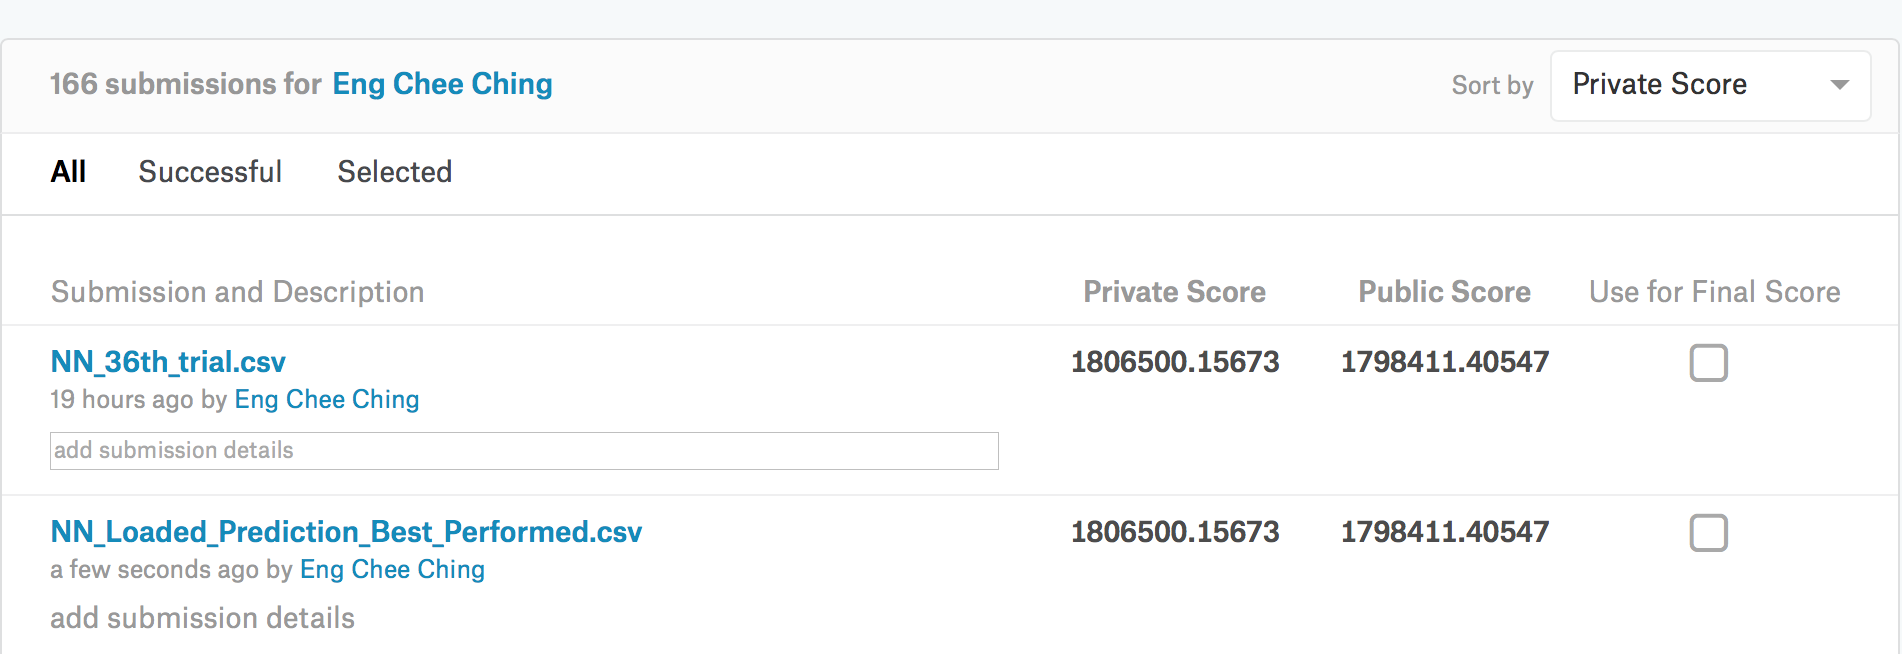

In [52]:
from IPython.display import Image
Image("Private LB Score.png")